<a href="https://colab.research.google.com/github/M4mbo/Generative-Colourization-Approaches-to-CIFAR10/blob/main/CIFAR10_CGAN_GS2C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using the CIFAR10 data provided below, create an alogrithm that takes in a gray scale image and coverts it to a color image.

Note for this problem we will define the grayscale image as the average of the three color channels.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models,transforms
from torchvision.utils import make_grid
from torchvision.datasets import CIFAR10
from torch.utils.data.sampler import SubsetRandomSampler
from mpl_toolkits.axes_grid1 import ImageGrid
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [ ]:
def cifar10(batch_sz, random_seed, valid_size=0.2, shuffle=True):

  if random_seed is not None:
    torch.manual_seed(random_seed)

  transform_train = transforms.Compose([
      transforms.ToTensor(),
  ])
  transform_valid = transforms.ToTensor()
  transform_test = transforms.ToTensor()

  train_dataset = CIFAR10(root='./datasets', train=True, download=True, transform=transform_train)
  valid_dataset = CIFAR10(root='./datasets', train=True, download=True, transform=transform_valid)

  num_train = len(train_dataset)
  indices = list(range(num_train))
  split = int(np.floor(valid_size * num_train))
  if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
  train_idx, valid_idx = indices[split:], indices[:split]

  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_sz, sampler=train_sampler, pin_memory=True)
  valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_sz, sampler=valid_sampler, pin_memory=True)

  test_dataset = CIFAR10(root='./datasets', train=False, download=True, transform=transform_test)
  test_loader = DataLoader(test_dataset, batch_size=batch_sz)

  return train_loader, valid_loader, test_loader


In [ ]:
def convert_to_grayscale(batch):

  grayscale_dataset = []
  for image in batch:
    # Convert colored image to grayscale by taking the average of all channels
    grayscale_image = torch.mean(image, dim=0, keepdim=True)
    grayscale_dataset.append((grayscale_image))

  grayscale_dataset = torch.stack(grayscale_dataset, dim=0)
  return grayscale_dataset


In [ ]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data
random_seed=2000
train_loader, valid_loader, test_loader = cifar10(batch_sz, random_seed)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
def visualize_dataset(dataloader):
  batch = next(iter(dataloader))
  images = batch[0]
  labels = batch[1]
  plt.figure(figsize=(15,15))
  for i in range(32):
    plt.subplot(8,8,i+1)
    img = np.transpose(images[i].numpy(), (1, 2, 0))  # Transpose the image dimensions
    plt.imshow(img)
    plt.title(classes[labels[i]])
    plt.axis("off")

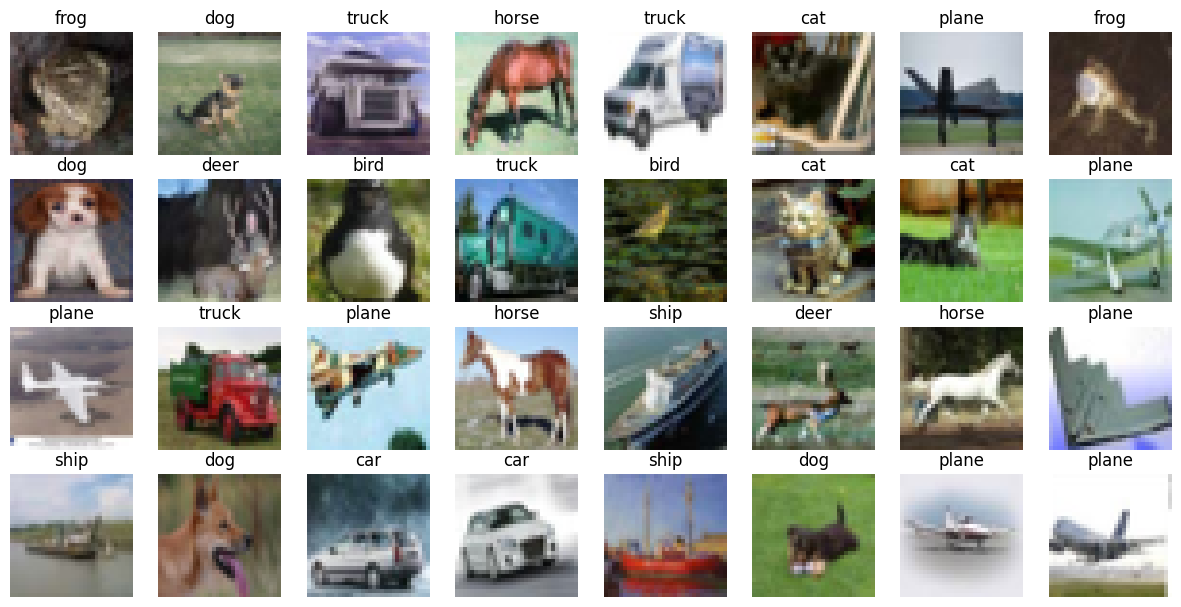

In [ ]:

visualize_dataset(train_loader)

In [ ]:
class Reshape(nn.Module):
  """A custom reshape layer."""
  def __init__(self, shape):
    super(Reshape, self).__init__()
    self.shape = shape

  def forward(self, x):
    return x.view(*self.shape)

def weights_init(m):
    """Reinitialize model weights. GAN authors recommend them to be sampled from N(0,0.2)"""
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


In [ ]:
class Generator(nn.Module):
  """Generator model"""
  def __init__(self):
    super(Generator, self).__init__()

    # U-Net architecture

    self.encoding_unit1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
    )

    self.encoding_unit2 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),
    )

    self.encoding_unit3 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(),
    )

    self.encoding_unit4 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(),
    )

    self.encoding_unit5 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(1024),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(1024),
        nn.LeakyReLU(),
    )

    self.decoding_unit1 = nn.Sequential(
        nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(),
    )

    self.decoding_unit2 = nn.Sequential(
        nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(),
    )

    self.decoding_unit3 = nn.Sequential(
        nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),
    )

    self.decoding_unit4 = nn.Sequential(
        nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),
    )
    self.decoding_unit5 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=3, kernel_size=1, stride=1, padding=0),
    )

    self.upsampling1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.upsampling2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.upsampling3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
    self.upsampling4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)

  def forward(self, x):

    x1 = self.encoding_unit1(x)
    x = F.max_pool2d(x1, (2,2))

    x2 = self.encoding_unit2(x)
    x = F.max_pool2d(x2, (2,2))

    x3 = self.encoding_unit3(x)
    x = F.max_pool2d(x3, (2,2))

    x4 = self.encoding_unit4(x)
    x = F.max_pool2d(x4, (2,2))

    x = self.encoding_unit5(x)

    x = self.upsampling1(x)
    x = torch.cat([x, x4], dim=1)
    x = self.decoding_unit1(x)

    x = self.upsampling2(x)
    x = torch.cat([x, x3], dim=1)
    x = self.decoding_unit2(x)

    x = self.upsampling3(x)
    x = torch.cat([x, x2], dim=1)
    x = self.decoding_unit3(x)

    x = self.upsampling4(x)
    x = torch.cat([x, x1], dim=1)
    x = self.decoding_unit4(x)

    x = self.decoding_unit5(x)

    x = F.tanh(x)

    return x

In [ ]:
class Discriminator(nn.Module):
  """Discriminator model"""
  def __init__(self):
    super(Discriminator, self).__init__()
    self.disc_model = nn.Sequential(
        nn.Conv2d(in_channels=4, out_channels=64, kernel_size=5, stride=2, padding=2),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(),

        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(),


        nn.Flatten(1,-1),

    )

    self.layer_1 = nn.Linear(512 * 2 * 2, 256)
    self.layer_1_b = nn.BatchNorm1d(256)
    self.layer_1_a = nn.LeakyReLU()

    self.layer_2 = nn.Linear(256, 128)
    self.layer_2_b = nn.BatchNorm1d(128)
    self.layer_2_a = nn.LeakyReLU()

    self.layer_3 = nn.Linear(128, 1)
    self.layer_3_a = nn.Sigmoid()

  def forward(self, x, condition):

    x = torch.cat([x,condition], 1)

    x = self.disc_model(x)

    x = self.layer_1_a(self.layer_1_b(self.layer_1(x)))
    x = self.layer_2_a(self.layer_2_b(self.layer_2(x)))
    x = self.layer_3_a(self.layer_3(x))

    return x

In [ ]:
def plot_losses(generator_losses_tr, discriminator_losses_tr, generator_losses_val, discriminator_losses_val):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    fig.suptitle('Generator and Discriminator Losses', fontsize=16)

    # Plot Generator Training Loss
    axes[0, 0].plot(generator_losses_tr, label='Generator Training Loss', color='blue')
    axes[0, 0].plot(generator_losses_val, label='Generator Validation Loss', color='red')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Generator Losses')
    axes[0, 0].legend()
    axes[0, 0].grid(True)

    # Plot Generator Validation Loss
    axes[0, 1].plot(discriminator_losses_tr, label='Discriminator Training Loss', color='blue')
    axes[0, 1].plot(discriminator_losses_val, label='Discriminator Validation Loss', color='red')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].set_title('Discriminator Losses')
    axes[0, 1].legend()
    axes[0, 1].grid(True)

    # Plot Discriminator Training Loss
    axes[1, 0].plot(discriminator_losses_tr, label='Discriminator Training Loss', color='blue')
    axes[1, 0].plot(generator_losses_tr, label='Generator Training Loss', color='red')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Loss')
    axes[1, 0].set_title('Training Losses')
    axes[1, 0].legend()
    axes[1, 0].grid(True)

    # Plot Discriminator Validation Loss
    axes[1, 1].plot(discriminator_losses_val, label='Discriminator Validation Loss', color='blue')
    axes[1, 1].plot(generator_losses_val, label='Generator Validation Loss', color='red')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].set_title('Validation Losses')
    axes[1, 1].legend()
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

In [ ]:
# Helper function to display results
def display_image_grid(images, labels, num_rows, num_cols, title_text):

  fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
  grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

  for ax, im, l in zip(grid, images, labels):
    if im.size(0) == 1:
      if im.dtype == torch.float32 or im.dtype == torch.float64:
        ax.imshow(np.clip(im.permute(1,2,0).numpy(), 0, 1), cmap = 'gray')
      else:
        ax.imshow(np.clip(im.permute(1,2,0).numpy(), 0, 255), cmap = 'gray')
    else:
      if im.dtype == torch.float32 or im.dtype == torch.float64:
        ax.imshow(np.clip(im.permute(1,2,0).numpy(), 0, 1))
      else:
        ax.imshow(np.clip(im.permute(1,2,0).numpy(), 0, 255))

    ax.axis("off")
    ax.set_title(classes[l])

  plt.suptitle(title_text, fontsize=20)
  plt.tight_layout()
  plt.show()

In [ ]:
def train_GAN(EPOCHS, lr, l1_reg):

  display_image_grid(sample_images, sample_labels, 1, 10, f"Original images")
  display_image_grid(sample_images_gray, sample_labels, 1, 10, f"Grayscale images")

  discriminator.train()
  generator.train()

  writer = SummaryWriter("runs/lr_1")

  # Defining the optimizer and loss function here
  optimizer_gen = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
  optimizer_disc = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

  lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer_gen, gamma=0.98, verbose=True)

  loss_fn = nn.BCELoss()

  generator_losses_tr = []
  discriminator_losses_tr = []
  generator_losses_val = []
  discriminator_losses_val = []

  ## Training
  for i in range(1,EPOCHS+1):
    pbar = tqdm(train_loader)

    total_gen_loss = 0.0
    total_disc_loss = 0.0
    num_samples = 0

    for b, batch in enumerate(pbar):
      # Every data instance is an input + label pair. We don't need the label
      inputs, _ = batch
      inputs = inputs.to(device)
      # Create a copy of the inputs but in grayscale
      inputs_gray = convert_to_grayscale(inputs)
      condition = inputs_gray.to(device)

      inputs = (inputs - 0.5) * 2 # setting data range to [-1,1]
      condition = (condition - 0.5) * 2

      ############################
      # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
      ###########################

      ## Train with all-real batch
      discriminator.zero_grad()
      # Set up labels
      label = torch.full((inputs.shape[0],1), real_label, dtype=torch.float, device=device)
      # Forward pass real batch through D
      output_real = discriminator(inputs, condition)
      # Calculate loss on all-real batch
      errD_real = loss_fn(output_real, label)
      # Calculate gradients for D in backward pass
      errD_real.backward()
      D_x = output_real.mean().item()

      ## Train with all-fake batch

      # Generate fake image batch with G
      fake = generator(condition)
      label.fill_(fake_label)
      # Classify all fake batch with D
      output_fake = discriminator(fake.detach(), condition)
      # Calculate D's loss on the all-fake batch
      errD_fake = loss_fn(output_fake, label)
      # Calculate the gradients for this batch, accumulated (summed) with previous gradients
      errD_fake.backward()
      D_G_z1 = output_fake.mean().item()
      # Compute error of D as sum over the fake and the real batches
      errD = errD_real + errD_fake
      # Update D
      optimizer_disc.step()
      ############################
      # (2) Update G network: maximize log(D(G(z)))
      ###########################
      generator.zero_grad()
      label.fill_(real_label)  # fake labels are real for generator cost
      # Since we just updated D, perform another forward pass of all-fake batch through D
      output_fake = discriminator(fake, condition)
      # Calculate G's loss based on this output
      errG = loss_fn(output_fake, label) + (l1_reg * torch.mean(torch.abs(fake - inputs)))
      # Calculate gradients for G
      errG.backward()
      D_G_z2 = output_fake.mean().item()
      # Update G
      optimizer_gen.step()

      total_gen_loss += errG.item()
      total_disc_loss += errD.item()
      num_samples += inputs.size(0)

      pbar.set_description(f"Epoch {i}/{EPOCHS}: ")
      pbar.set_postfix({"generator_loss": errG.item(), "discriminator_loss": errD.item(), "D(x)": D_x, "D(G(z1))": D_G_z1, "D(G(z2))": D_G_z2})

    generator_losses_tr.append(total_gen_loss / num_samples)
    discriminator_losses_tr.append(total_disc_loss / num_samples)

    ## Validation
    with torch.no_grad():

      total_gen_loss = 0.0
      total_disc_loss = 0.0
      num_samples = 0

      for batch in valid_loader:
        inputs, _ = batch
        inputs = inputs.to(device)
        inputs_gray = convert_to_grayscale(inputs)
        condition = inputs_gray.to(device)

        inputs = (inputs - 0.5) * 2
        condition = (condition - 0.5) * 2

        # Validation loss for discriminator
        label = torch.full((inputs.shape[0], 1), real_label, dtype=torch.float, device=device)
        output_real = discriminator(inputs, condition)

        fake = generator(condition)

        output_fake = discriminator(fake, condition)
        errD = loss_fn(output_real, label) + loss_fn(output_fake, label)

        # Validation loss for generator
        label.fill_(real_label)
        output_fake = discriminator(fake, condition)
        errG = loss_fn(output_fake, label) + (l1_reg * torch.mean(torch.abs(fake - inputs)))

        total_disc_loss += errD.item()
        total_gen_loss += errG.item()
        num_samples += inputs.size(0)

      generator_losses_val.append(total_gen_loss / num_samples)
      discriminator_losses_val.append(total_disc_loss / num_samples)

      # Visualization of validation images
      generations = generator(sample_conditions).cpu()
      generations = (generations + 1) / 2   #[0,1]
      generations = (generations * 255).clamp(0, 255).to(torch.uint8)
      display_image_grid(generations.squeeze(1), sample_labels, 1, 10, f"Generated images at epoch {i}")

    lr_scheduler.step()

  return generator_losses_tr, discriminator_losses_tr, generator_losses_val, discriminator_losses_val


In [ ]:
device = "cuda"

generator = Generator()
generator.apply(weights_init)
generator.to(device)

discriminator = Discriminator()
discriminator.apply(weights_init)
discriminator.to(device)

real_label = 1
fake_label = 0

In [ ]:
# Visualization Purposes
batch = next(iter(valid_loader))
inputs, labels = batch
# Convert the first 10 images to grayscale
sample_images = inputs[:10]
sample_images_gray = convert_to_grayscale(sample_images)
sample_conditions = sample_images_gray.to(device)

# Keep the first 10 labels for visualization
sample_labels = labels[:10]


We will be passing the grayscale image as the condition for our GAN.

<ipython-input-64-ed980bec2877>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


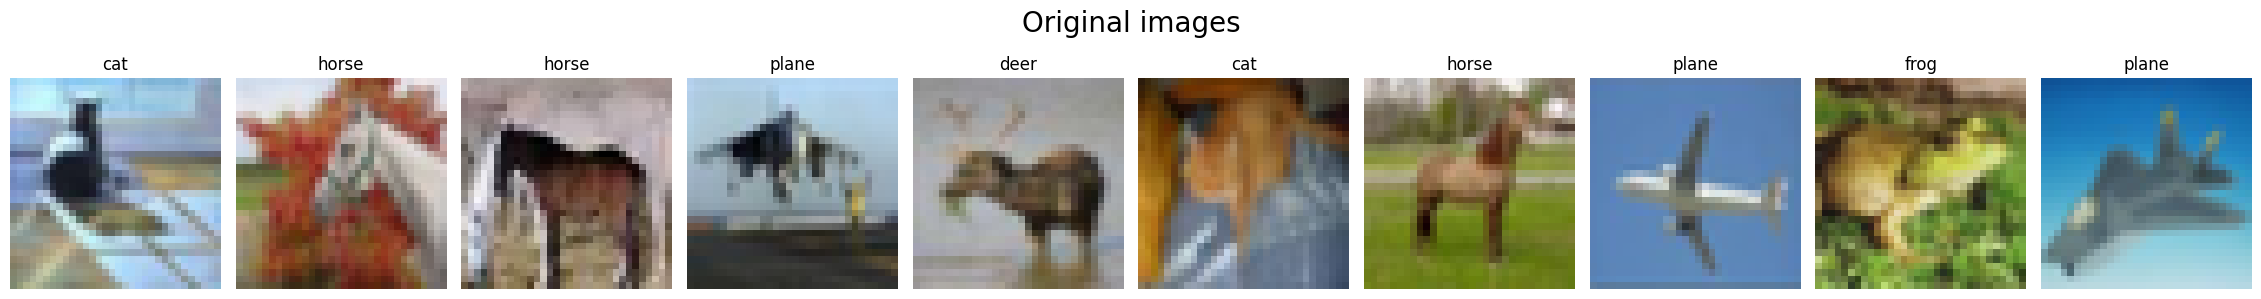

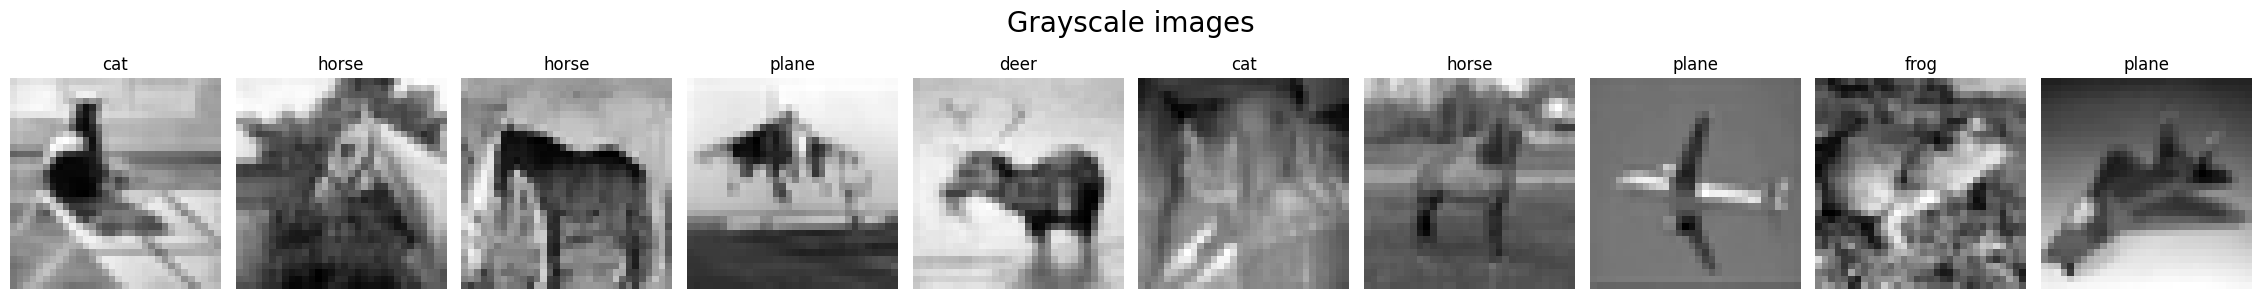

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 1/20: : 100%|██████████| 625/625 [01:14<00:00,  8.38it/s, generator_loss=9.29, discriminator_loss=0.614, D(x)=0.757, D(G(z1))=0.281, D(G(z2))=0.276]


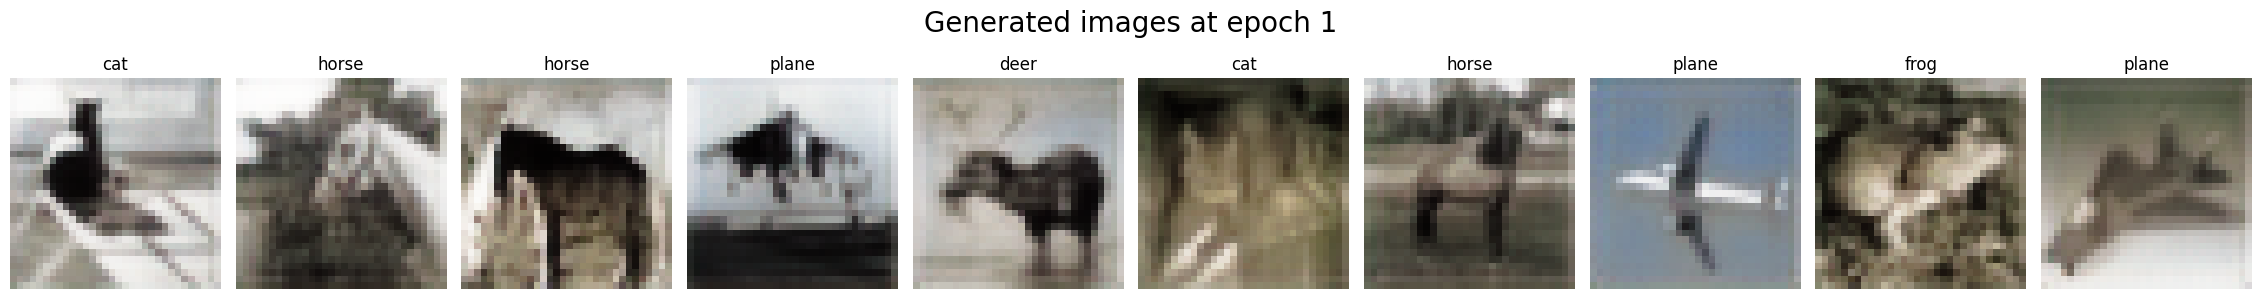

Adjusting learning rate of group 0 to 4.9000e-05.


Epoch 2/20: : 100%|██████████| 625/625 [01:14<00:00,  8.44it/s, generator_loss=10, discriminator_loss=0.253, D(x)=0.884, D(G(z1))=0.121, D(G(z2))=0.118]


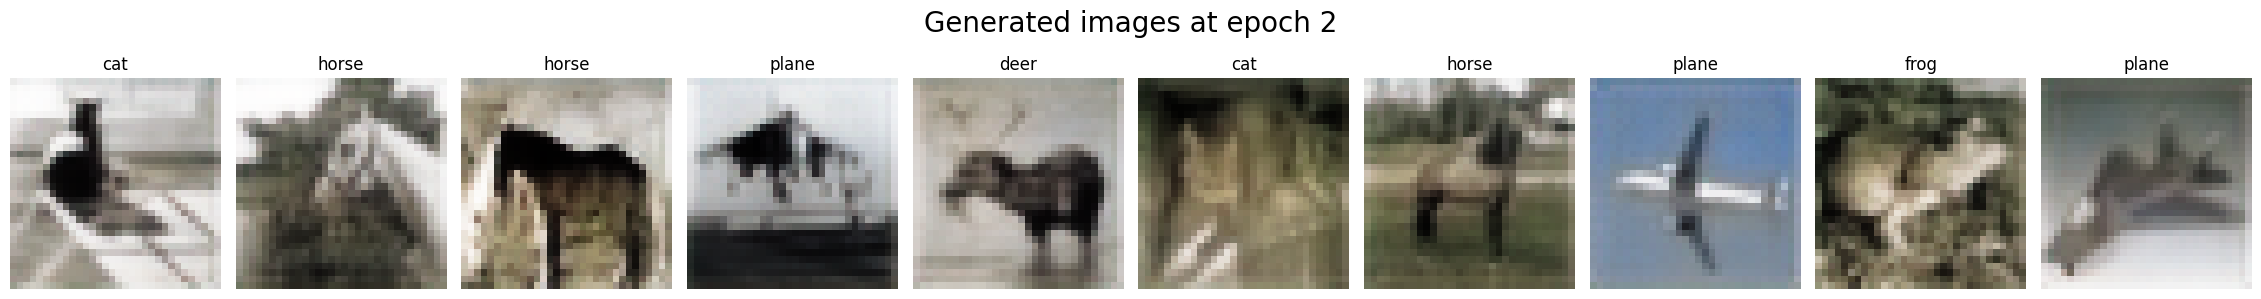

Adjusting learning rate of group 0 to 4.8020e-05.


Epoch 3/20: : 100%|██████████| 625/625 [01:14<00:00,  8.39it/s, generator_loss=10.3, discriminator_loss=0.729, D(x)=0.62, D(G(z1))=0.214, D(G(z2))=0.194]


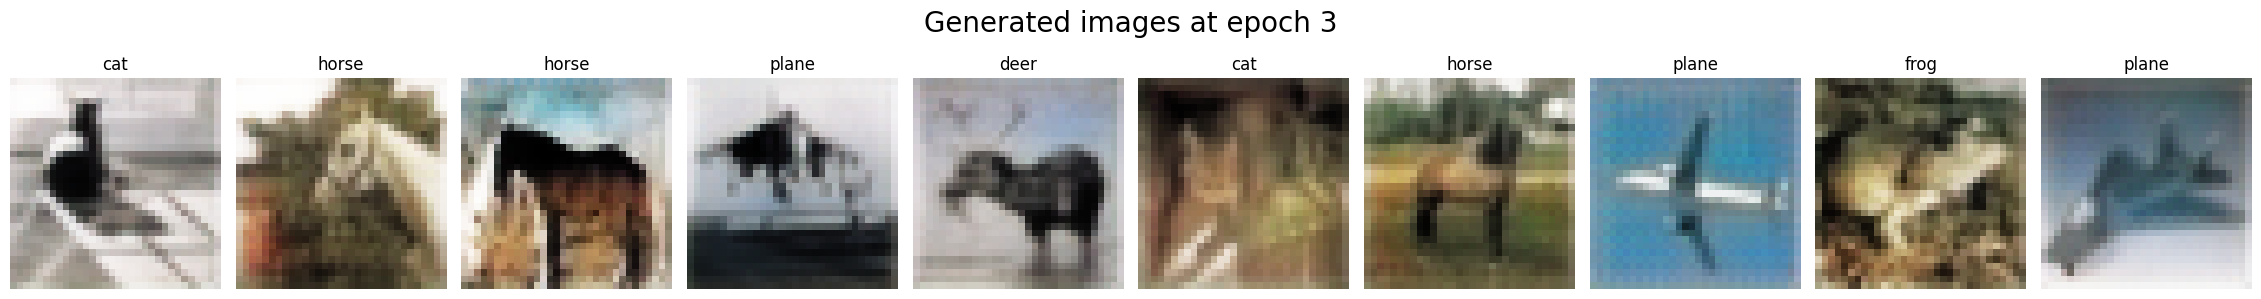

Adjusting learning rate of group 0 to 4.7060e-05.


Epoch 4/20: : 100%|██████████| 625/625 [01:14<00:00,  8.40it/s, generator_loss=8.99, discriminator_loss=0.243, D(x)=0.888, D(G(z1))=0.116, D(G(z2))=0.114]


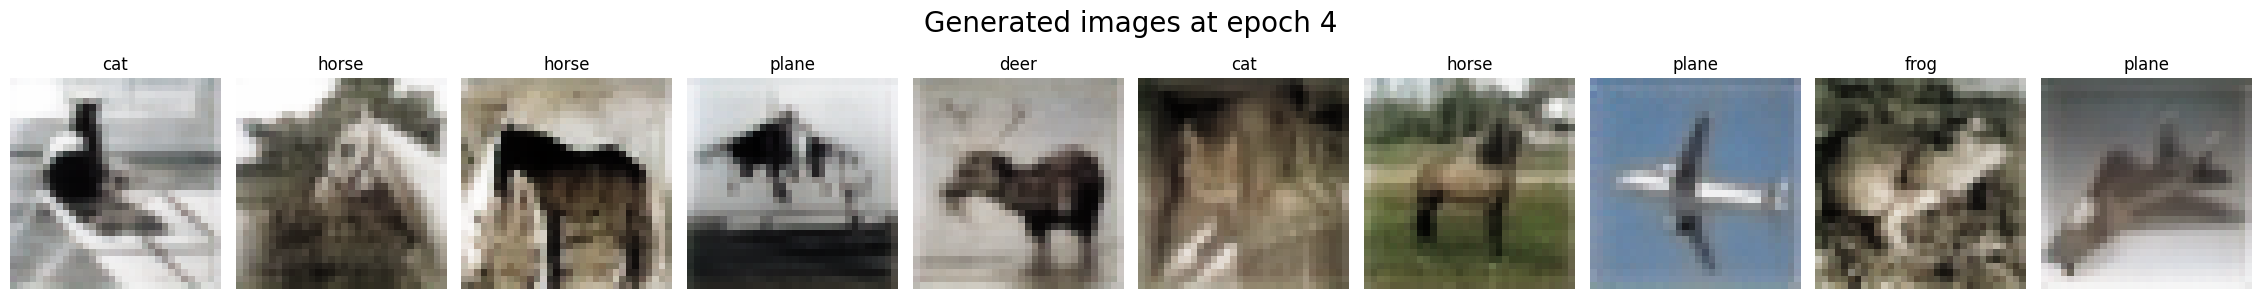

Adjusting learning rate of group 0 to 4.6118e-05.


Epoch 5/20: : 100%|██████████| 625/625 [01:14<00:00,  8.38it/s, generator_loss=9.2, discriminator_loss=0.963, D(x)=0.533, D(G(z1))=0.268, D(G(z2))=0.281]


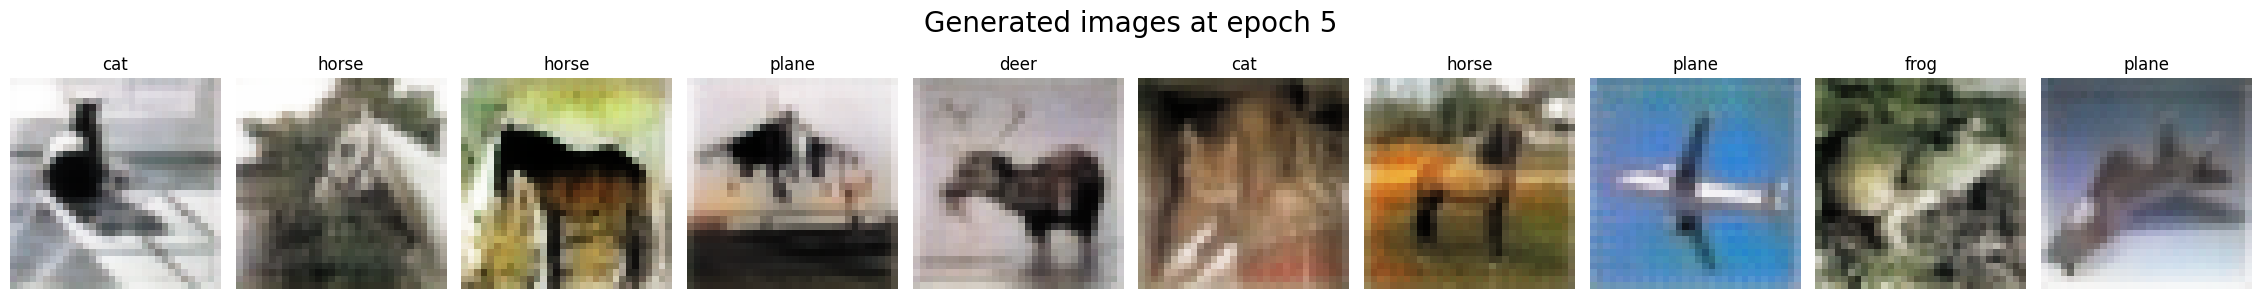

Adjusting learning rate of group 0 to 4.5196e-05.


Epoch 6/20: : 100%|██████████| 625/625 [01:15<00:00,  8.32it/s, generator_loss=8.43, discriminator_loss=1.36, D(x)=0.443, D(G(z1))=0.408, D(G(z2))=0.437]


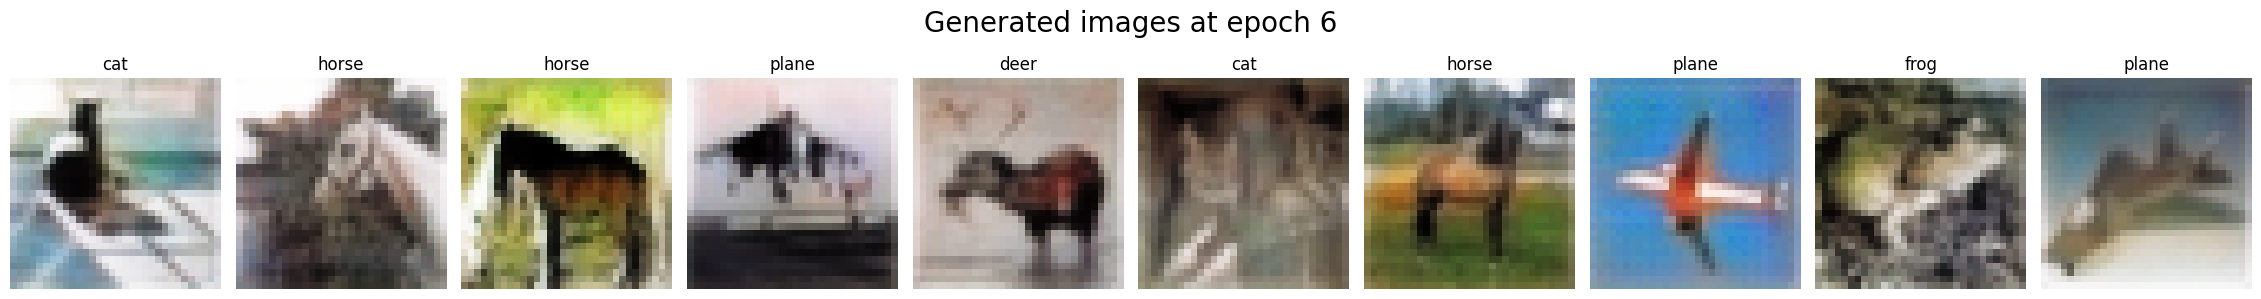

Adjusting learning rate of group 0 to 4.4292e-05.


Epoch 7/20: : 100%|██████████| 625/625 [01:14<00:00,  8.36it/s, generator_loss=10.1, discriminator_loss=0.88, D(x)=0.654, D(G(z1))=0.355, D(G(z2))=0.343]


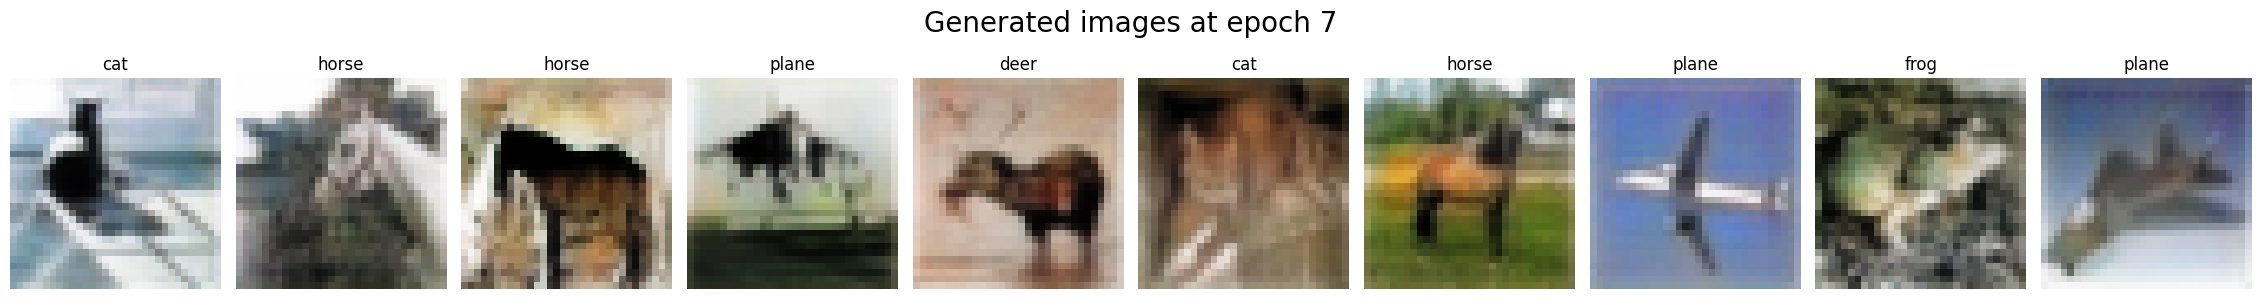

Adjusting learning rate of group 0 to 4.3406e-05.


Epoch 8/20: : 100%|██████████| 625/625 [01:14<00:00,  8.34it/s, generator_loss=8.64, discriminator_loss=1.19, D(x)=0.506, D(G(z1))=0.387, D(G(z2))=0.382]


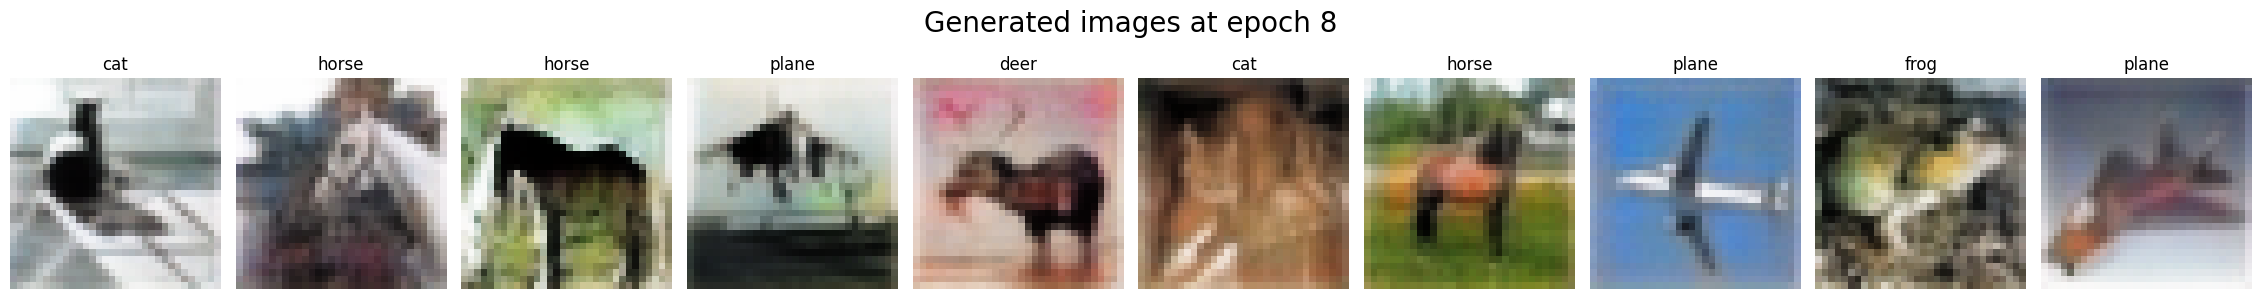

Adjusting learning rate of group 0 to 4.2538e-05.


Epoch 9/20: : 100%|██████████| 625/625 [01:14<00:00,  8.33it/s, generator_loss=8.56, discriminator_loss=1.27, D(x)=0.628, D(G(z1))=0.543, D(G(z2))=0.327]


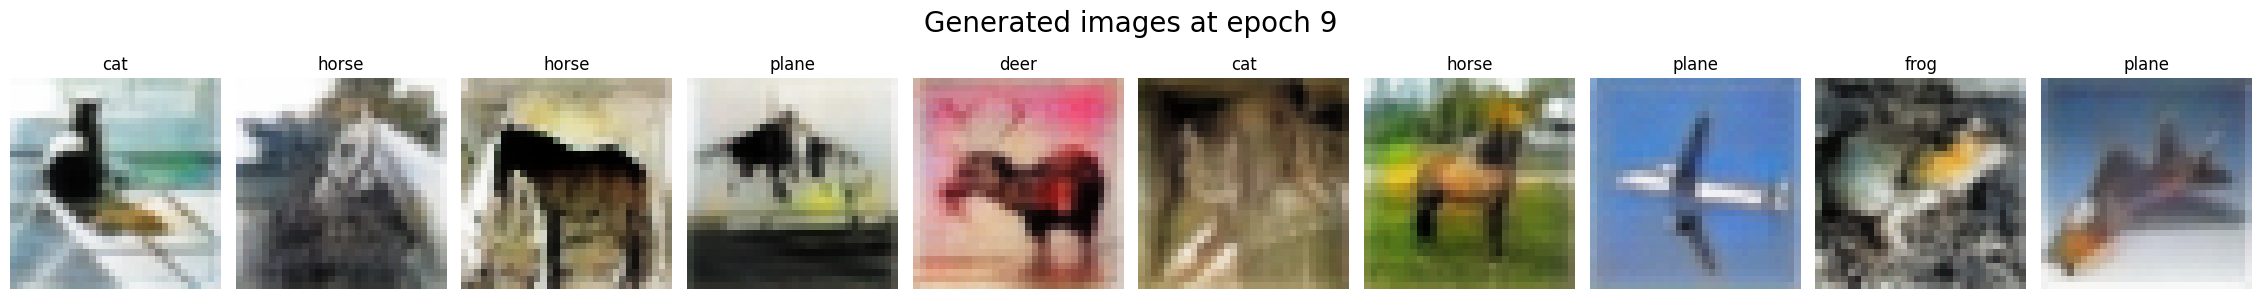

Adjusting learning rate of group 0 to 4.1687e-05.


Epoch 10/20: : 100%|██████████| 625/625 [01:15<00:00,  8.32it/s, generator_loss=8.25, discriminator_loss=0.719, D(x)=0.86, D(G(z1))=0.425, D(G(z2))=0.283]


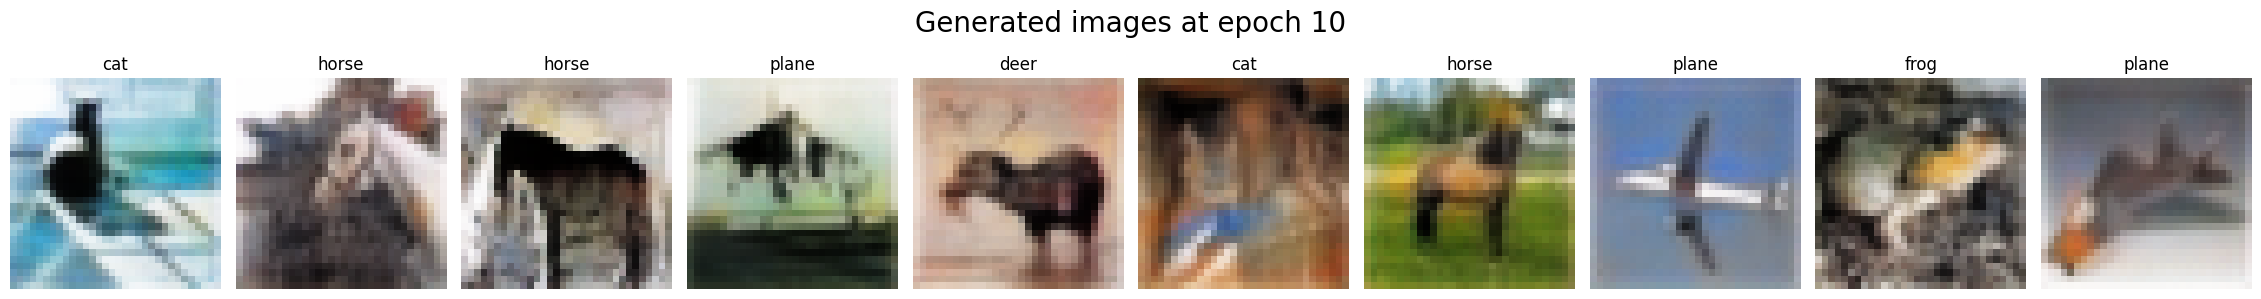

Adjusting learning rate of group 0 to 4.0854e-05.


Epoch 11/20: : 100%|██████████| 625/625 [01:15<00:00,  8.26it/s, generator_loss=7.72, discriminator_loss=0.893, D(x)=0.717, D(G(z1))=0.422, D(G(z2))=0.423]


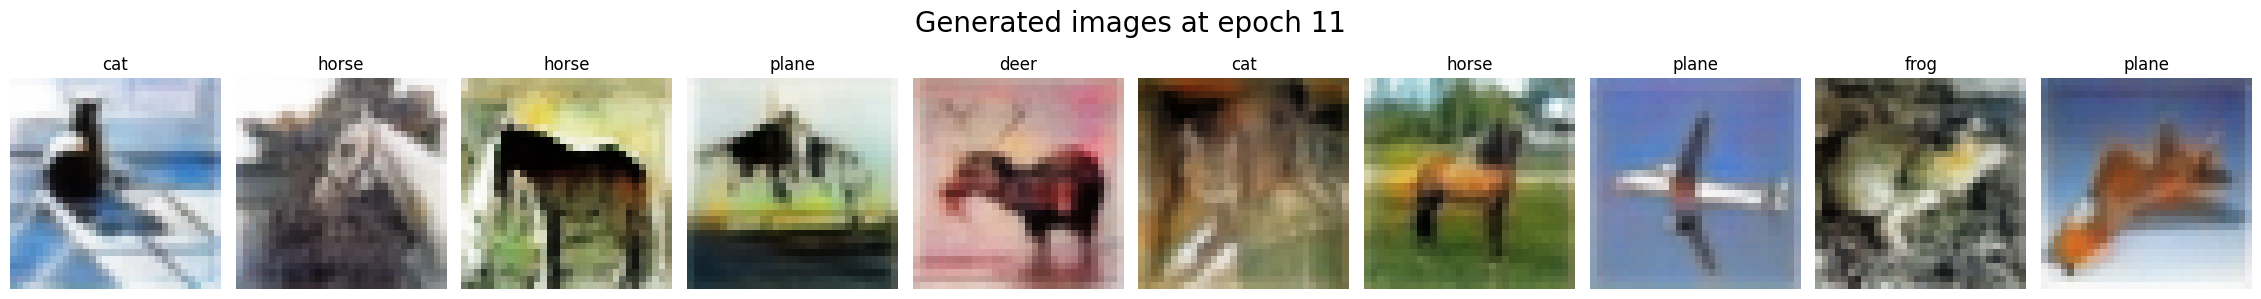

Adjusting learning rate of group 0 to 4.0037e-05.


Epoch 12/20: : 100%|██████████| 625/625 [01:16<00:00,  8.16it/s, generator_loss=7.55, discriminator_loss=0.763, D(x)=0.862, D(G(z1))=0.45, D(G(z2))=0.33]


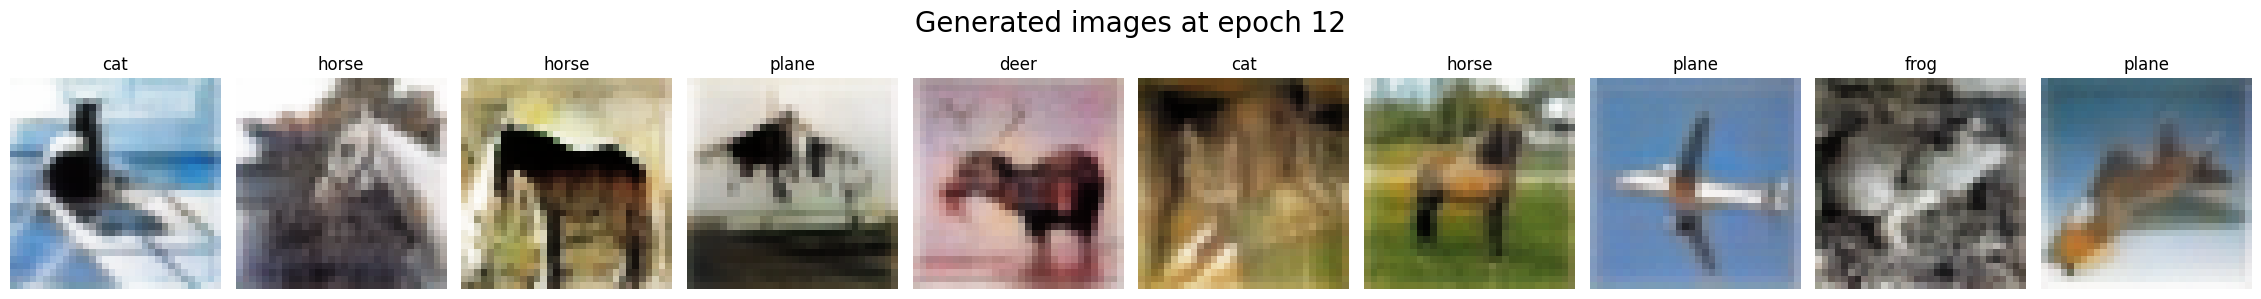

Adjusting learning rate of group 0 to 3.9236e-05.


Epoch 13/20: : 100%|██████████| 625/625 [01:15<00:00,  8.25it/s, generator_loss=6.9, discriminator_loss=1.21, D(x)=0.479, D(G(z1))=0.364, D(G(z2))=0.458]


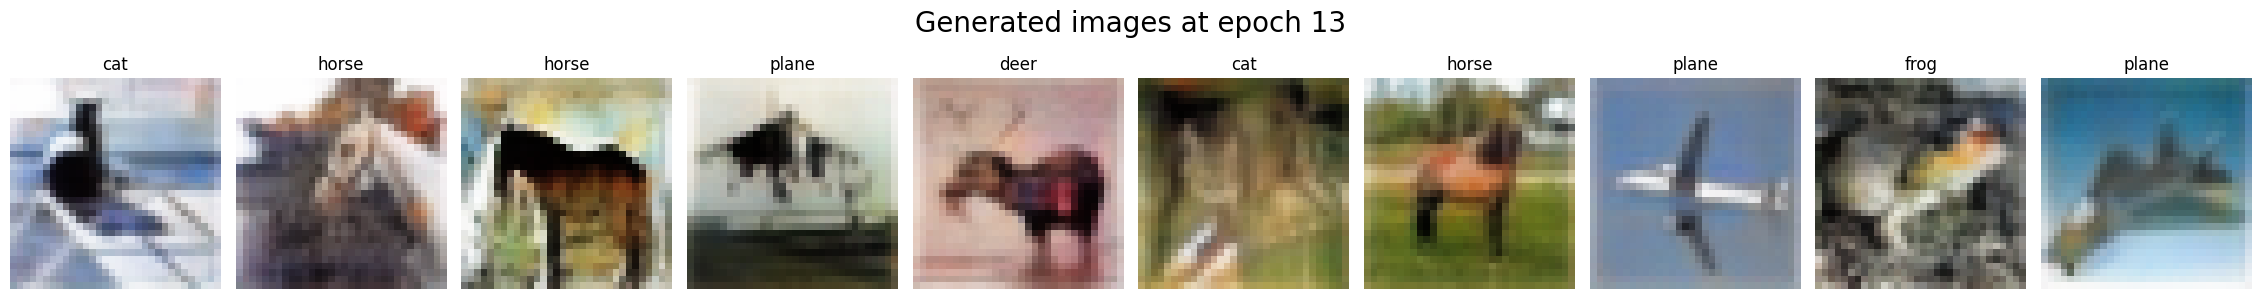

Adjusting learning rate of group 0 to 3.8451e-05.


Epoch 14/20: : 100%|██████████| 625/625 [01:15<00:00,  8.27it/s, generator_loss=7.02, discriminator_loss=1.16, D(x)=0.513, D(G(z1))=0.375, D(G(z2))=0.406]


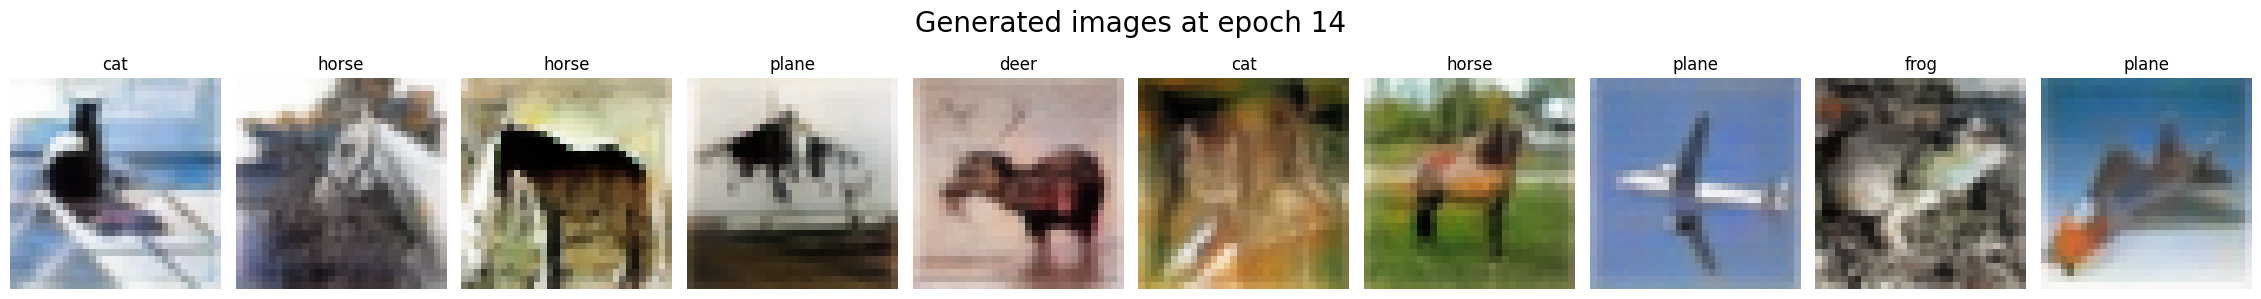

Adjusting learning rate of group 0 to 3.7682e-05.


Epoch 15/20: : 100%|██████████| 625/625 [01:15<00:00,  8.32it/s, generator_loss=7.34, discriminator_loss=1.38, D(x)=0.56, D(G(z1))=0.533, D(G(z2))=0.432]


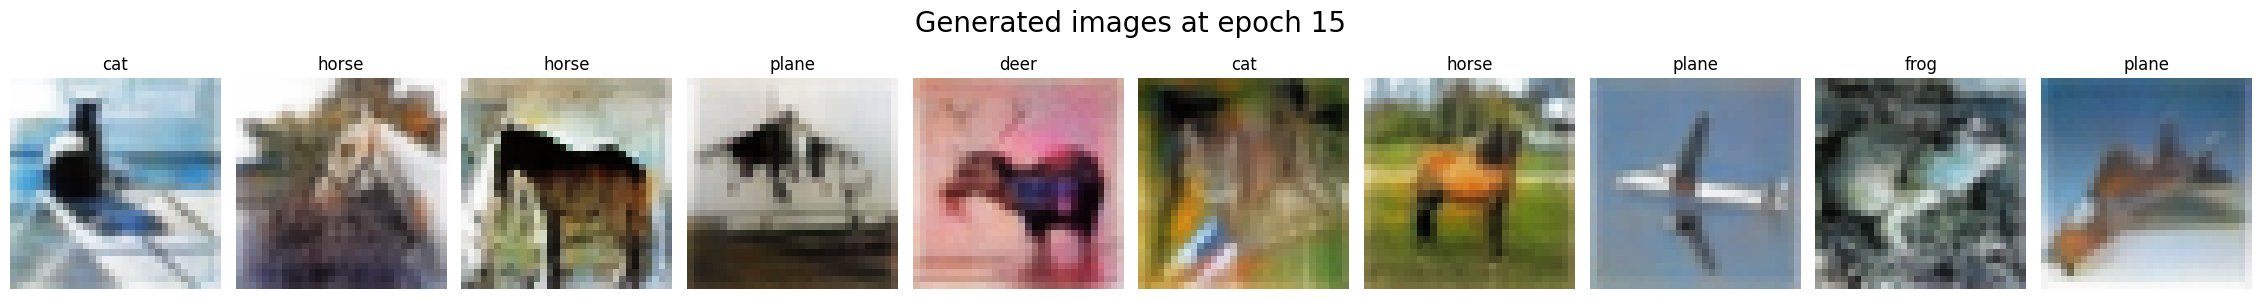

Adjusting learning rate of group 0 to 3.6928e-05.


Epoch 16/20: : 100%|██████████| 625/625 [01:15<00:00,  8.31it/s, generator_loss=7.17, discriminator_loss=1.02, D(x)=0.578, D(G(z1))=0.362, D(G(z2))=0.348]


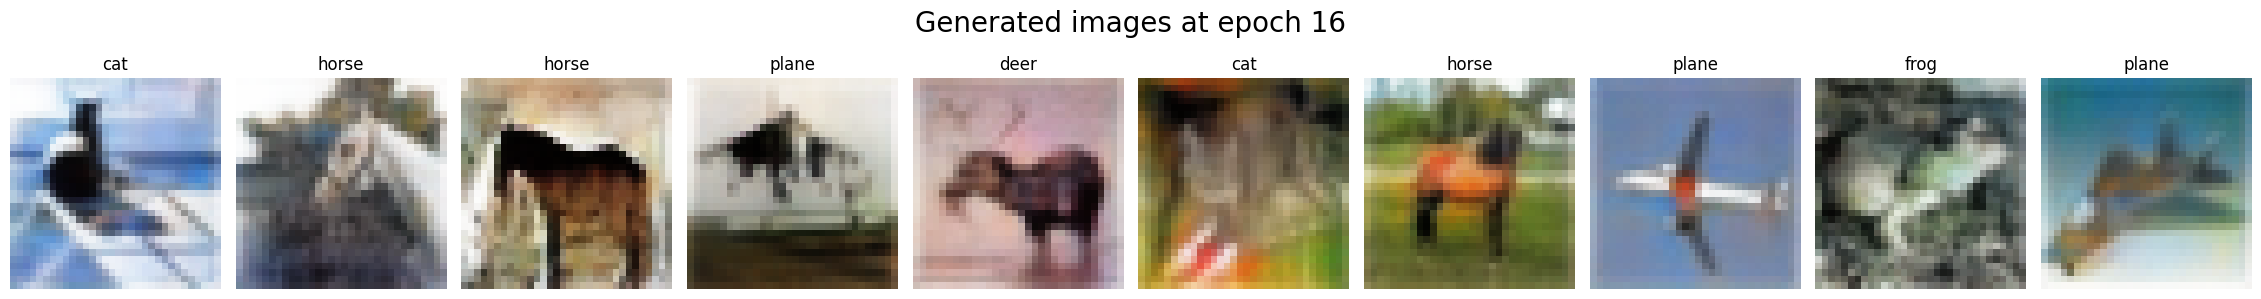

Adjusting learning rate of group 0 to 3.6190e-05.


Epoch 17/20: : 100%|██████████| 625/625 [01:15<00:00,  8.33it/s, generator_loss=7.37, discriminator_loss=0.991, D(x)=0.545, D(G(z1))=0.307, D(G(z2))=0.351]


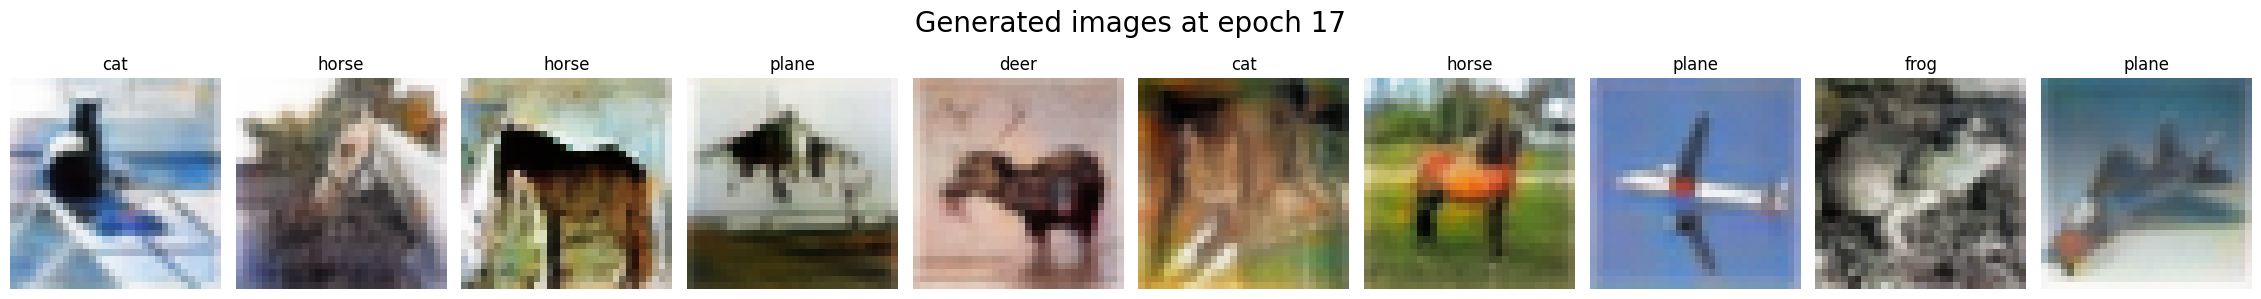

Adjusting learning rate of group 0 to 3.5466e-05.


Epoch 18/20: : 100%|██████████| 625/625 [01:15<00:00,  8.29it/s, generator_loss=6.6, discriminator_loss=1.19, D(x)=0.772, D(G(z1))=0.598, D(G(z2))=0.414]


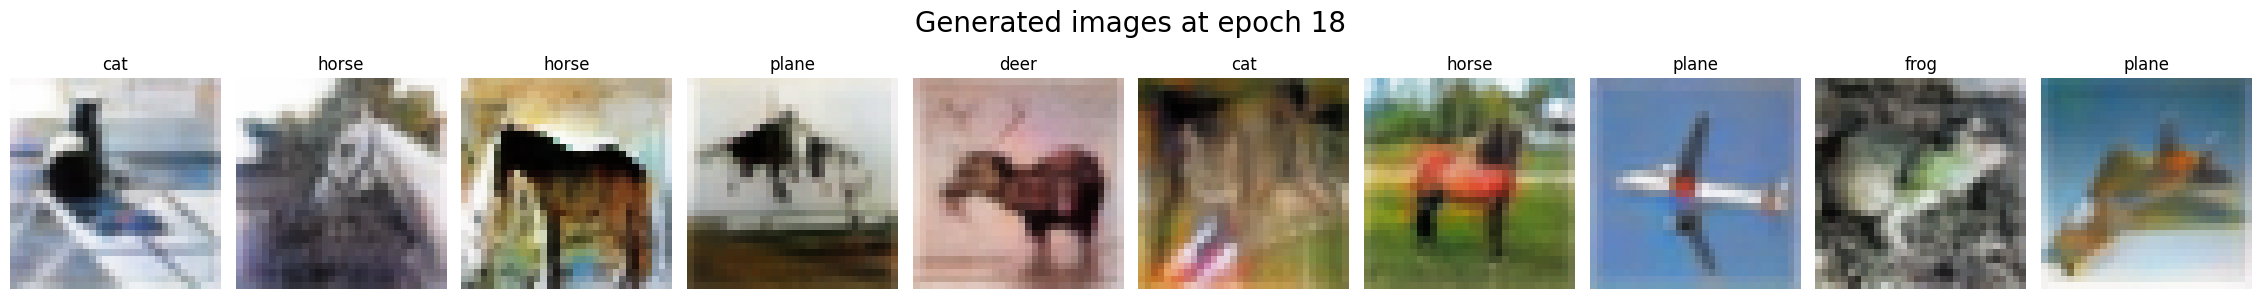

Adjusting learning rate of group 0 to 3.4757e-05.


Epoch 19/20: : 100%|██████████| 625/625 [01:15<00:00,  8.30it/s, generator_loss=6.81, discriminator_loss=1.32, D(x)=0.635, D(G(z1))=0.564, D(G(z2))=0.406]


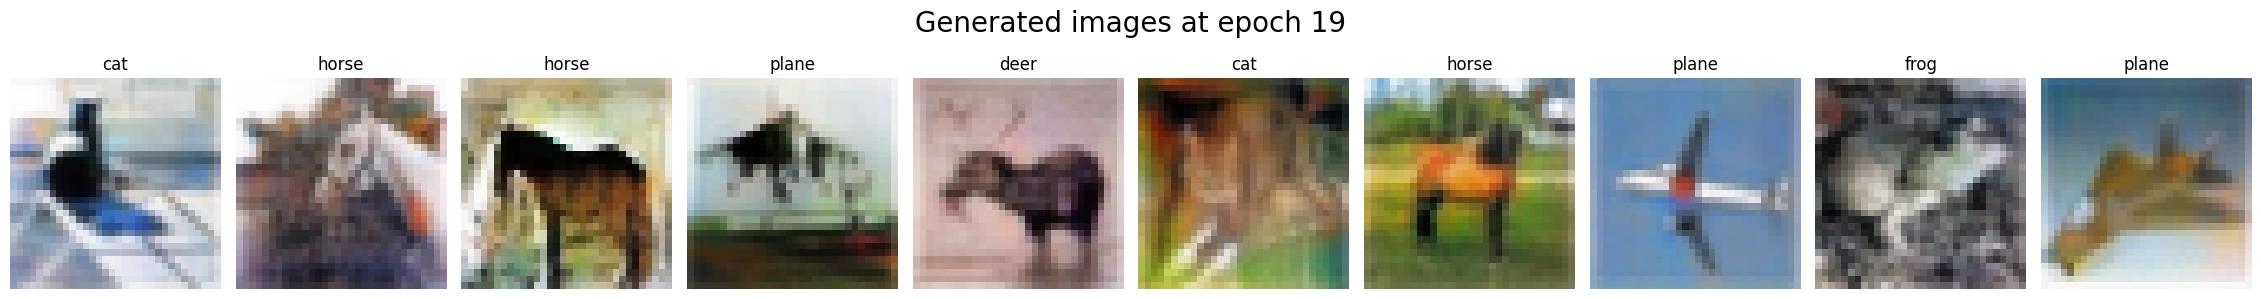

Adjusting learning rate of group 0 to 3.4062e-05.


Epoch 20/20: : 100%|██████████| 625/625 [01:15<00:00,  8.31it/s, generator_loss=6.23, discriminator_loss=1.51, D(x)=0.312, D(G(z1))=0.281, D(G(z2))=0.295]


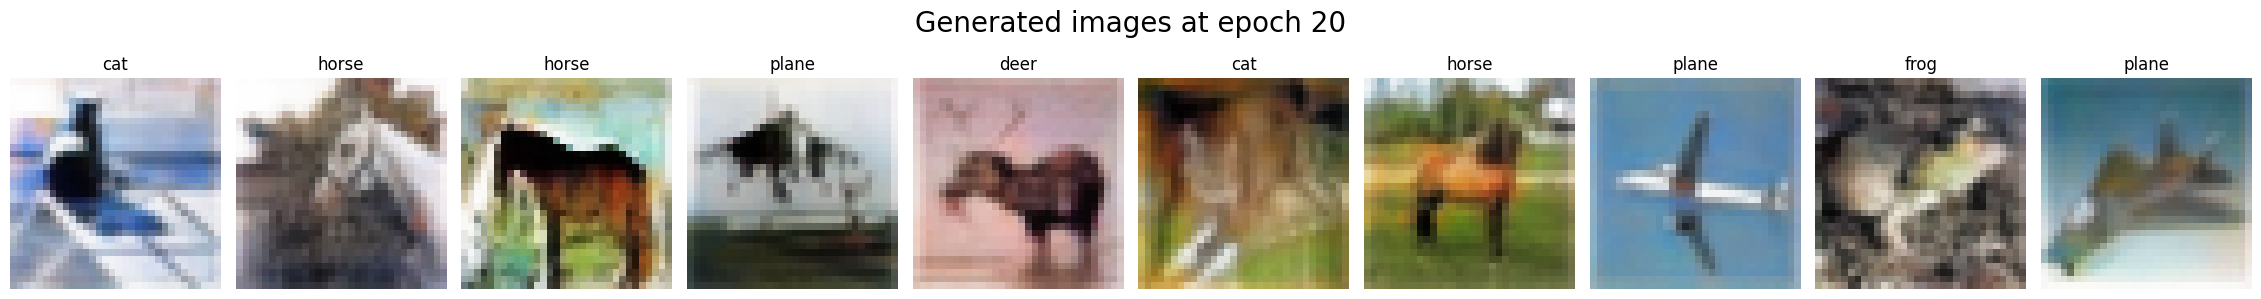

Adjusting learning rate of group 0 to 3.3380e-05.


In [ ]:
generator_losses_tr, discriminator_losses_tr, generator_losses_val, discriminator_losses_val = train_GAN(20, 5e-5, 80)

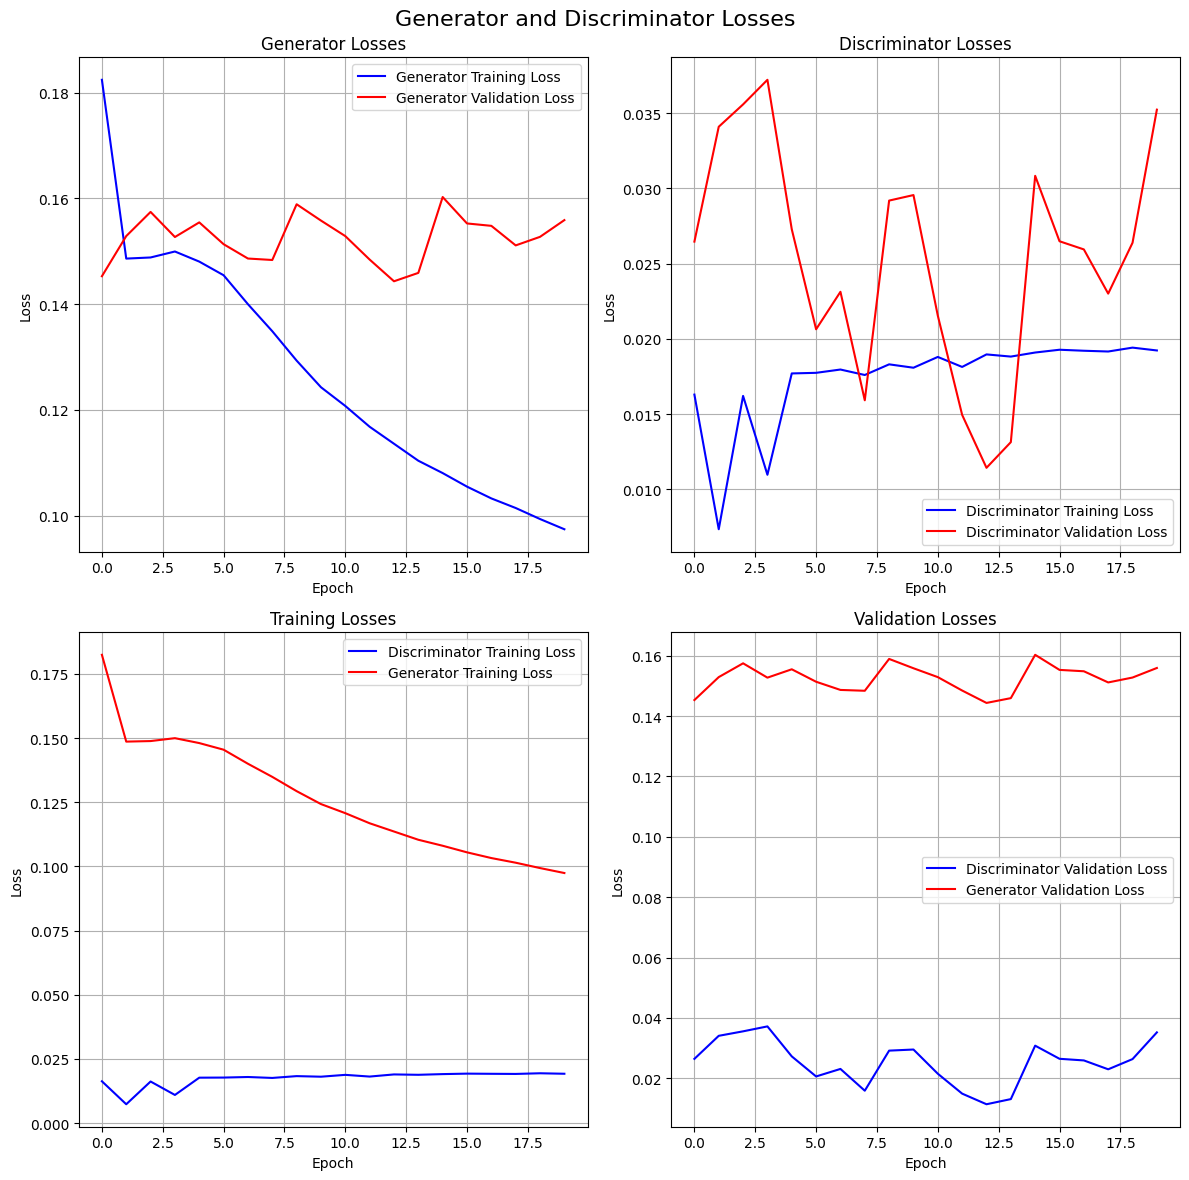

In [ ]:
plot_losses(generator_losses_tr, discriminator_losses_tr, generator_losses_val, discriminator_losses_val)

In [ ]:
def test_GAN(generator, discriminator, l1_reg):
    generator.eval()
    discriminator.eval()
    loss_fn = nn.BCELoss()

    n_batch = 0
    total_gen_loss = 0.0
    total_disc_loss = 0.0
    num_samples = 0

    with torch.no_grad():
      for batch in test_loader:
        original_images, classes = batch
        inputs = original_images.to(device)
        classes = classes.to(device)
        grayscale_images = convert_to_grayscale(original_images)
        condition = grayscale_images.to(device)

        inputs = (inputs - 0.5) * 2
        condition = (condition - 0.5) * 2

        label = torch.full((inputs.shape[0], 1), real_label, dtype=torch.float, device=device)
        output_real = discriminator(inputs, condition)

        fake = generator(condition)

        output_fake = discriminator(fake, condition)
        errD = loss_fn(output_real, label) + loss_fn(output_fake, label)

        label.fill_(real_label)
        output_fake = discriminator(fake, condition)
        errG = loss_fn(output_fake, label) + (l1_reg * torch.mean(torch.abs(fake - inputs)))

        total_disc_loss += errD.item()
        total_gen_loss += errG.item()
        num_samples += inputs.size(0)

        if (n_batch <= 10):
          print("Batch", n_batch+1)
          # Extract labels from the test_loader
          labels = classes.cpu().numpy()
          generated_batch = generator(condition).cpu()
          generated_batch = (generated_batch + 1) /2
          generated_batch = (generated_batch * 255).clamp(0, 255).to(torch.uint8)

          # Display original images
          display_image_grid(original_images, labels, 1, 10, "Original Images")

          # Display grayscale images
          display_image_grid(grayscale_images, labels, 1, 10, "Grayscale Images")

          # Display generated images
          display_image_grid(generated_batch.squeeze(1), labels, 1, 10, "Generated Images")

          n_batch+=1

    gen_test_loss = total_gen_loss / num_samples
    disc_test_loss = total_disc_loss / num_samples

    print("Generator test loss:", gen_test_loss)
    print("Discriminator test loss:", disc_test_loss)


Batch 1


<ipython-input-64-ed980bec2877>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


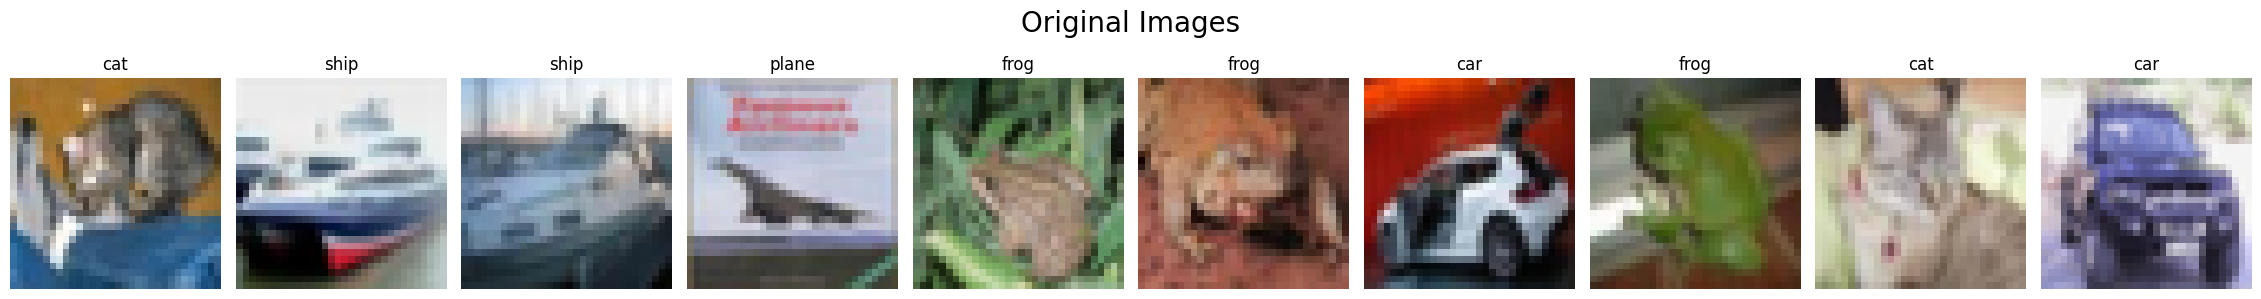

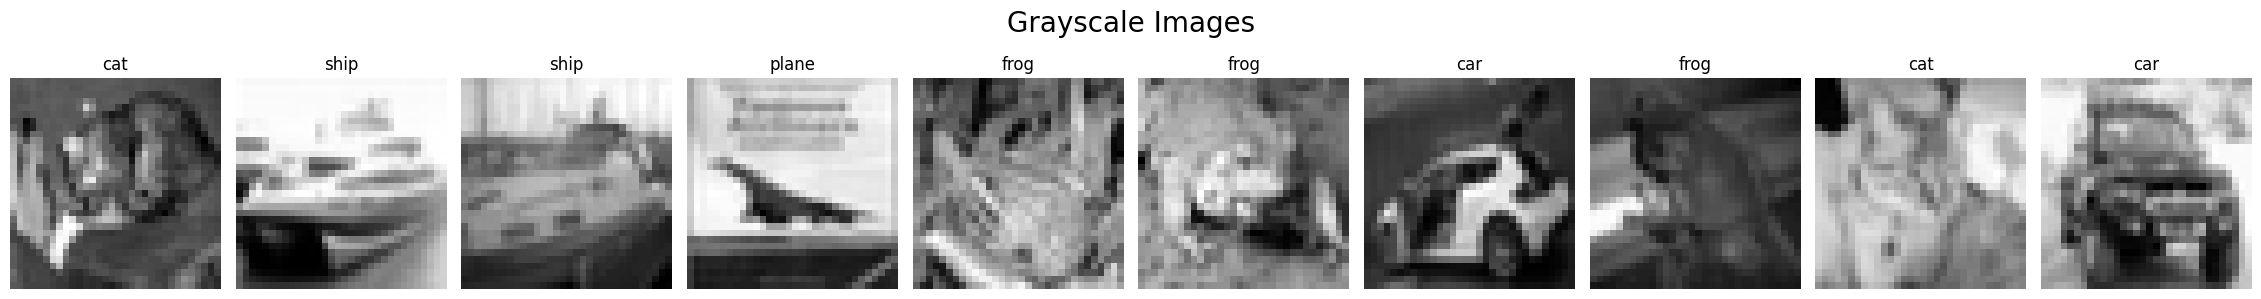

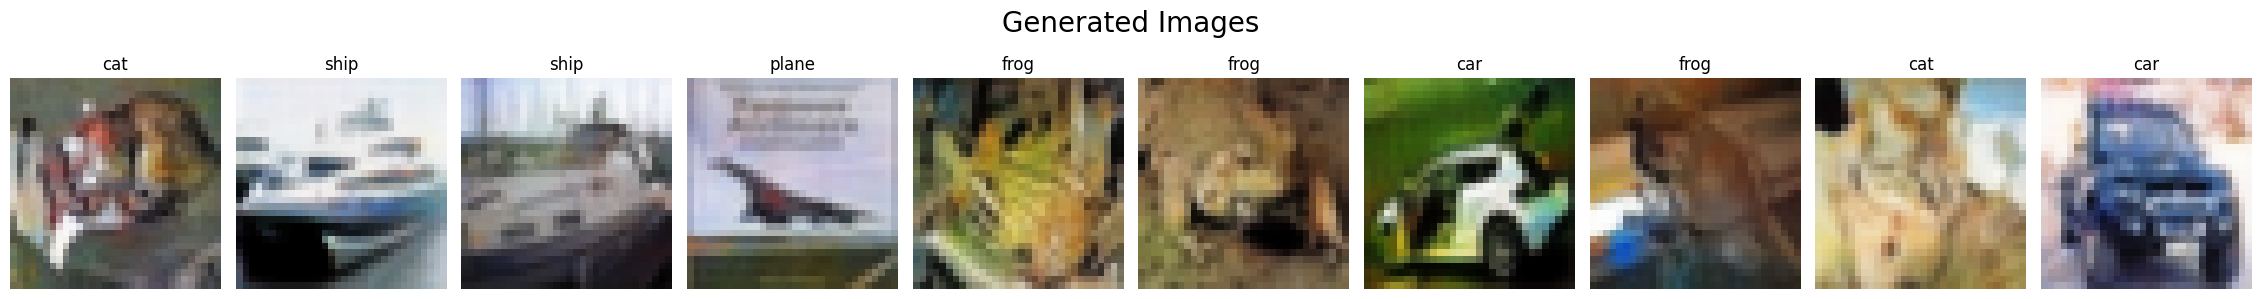

Batch 2


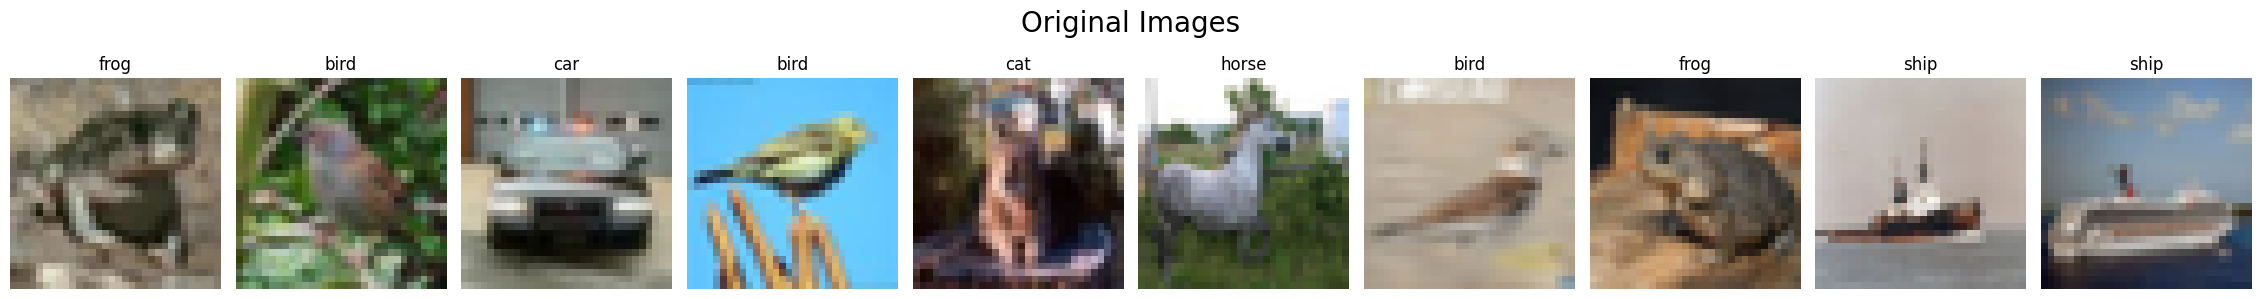

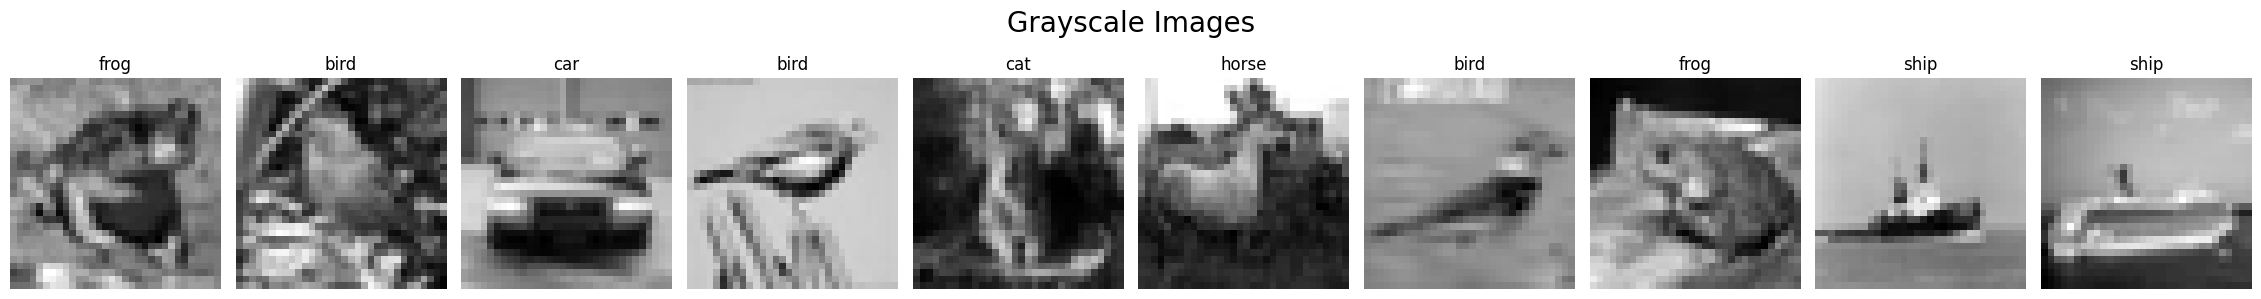

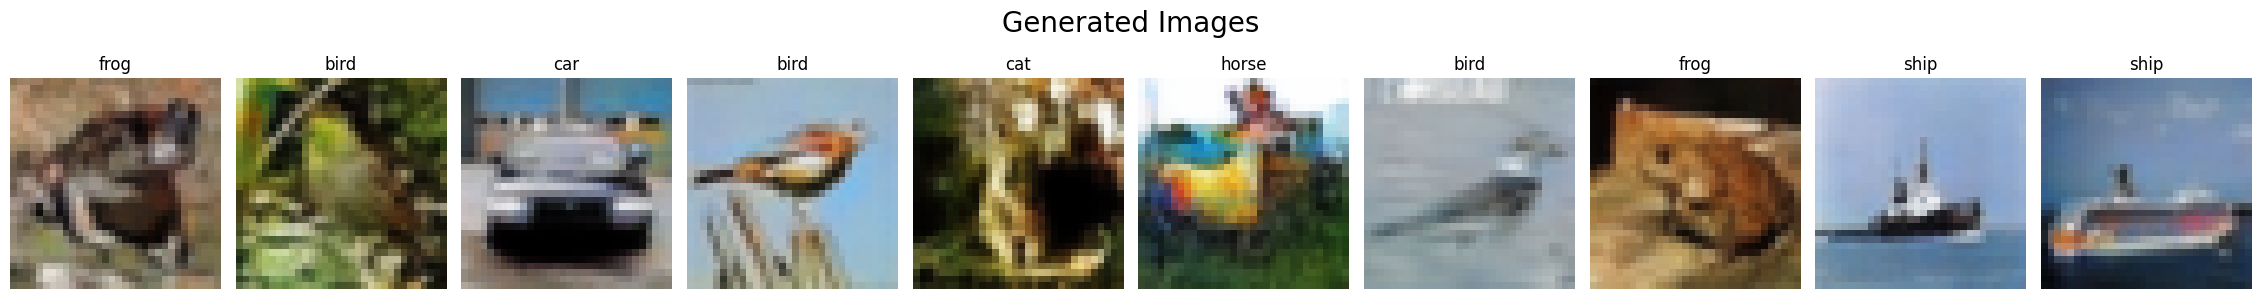

Batch 3


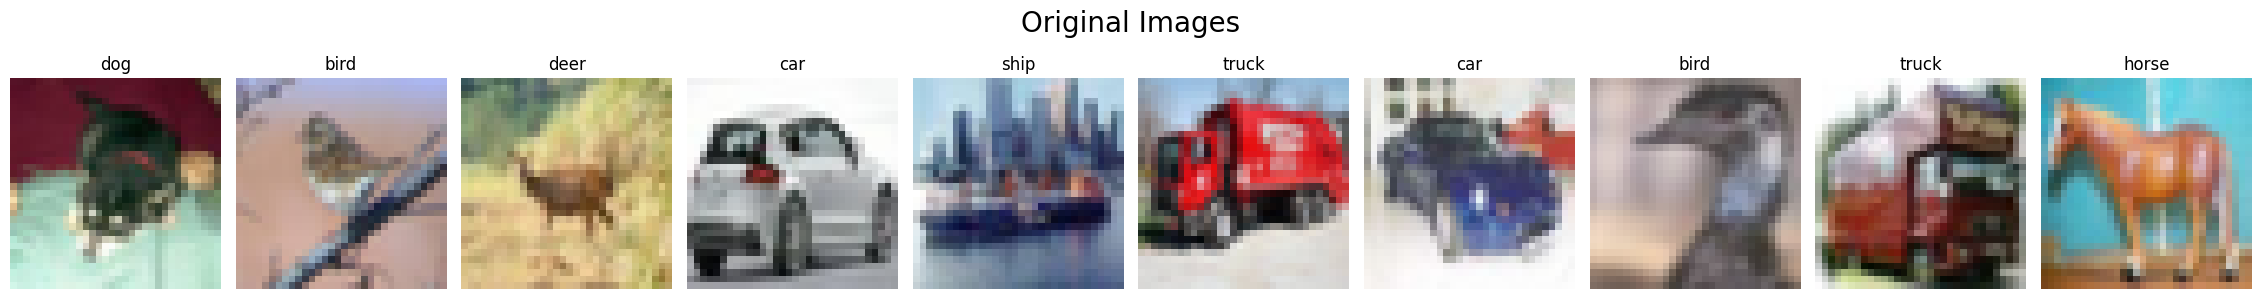

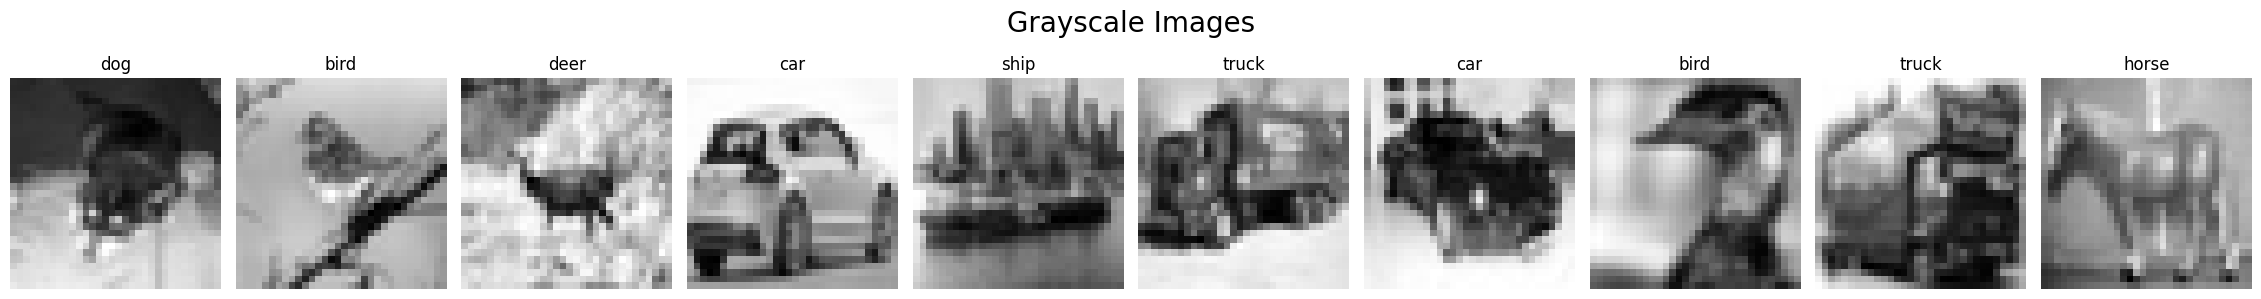

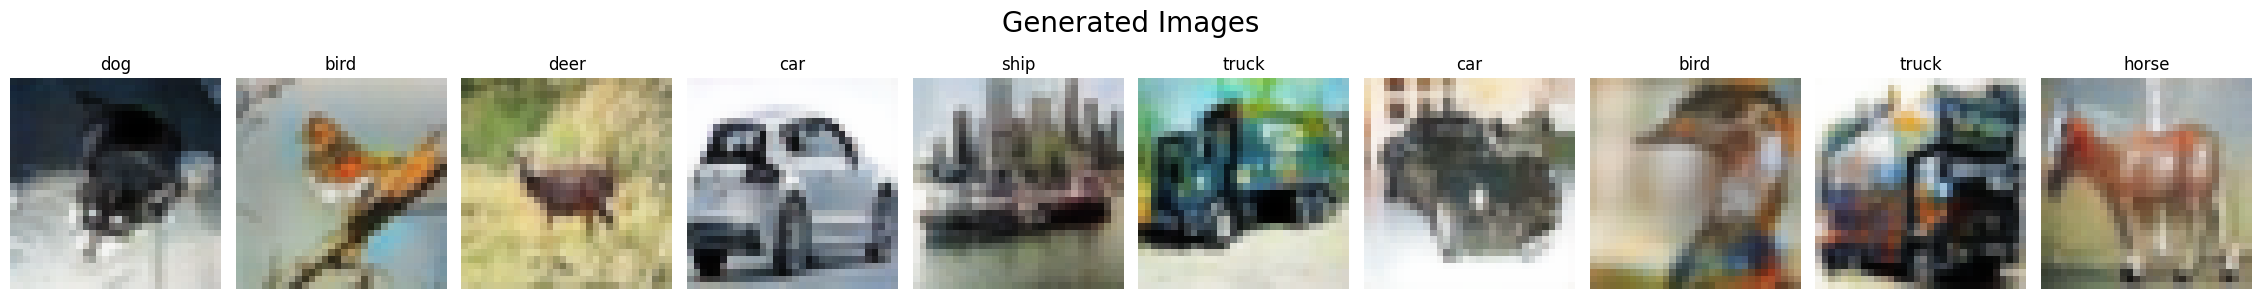

Batch 4


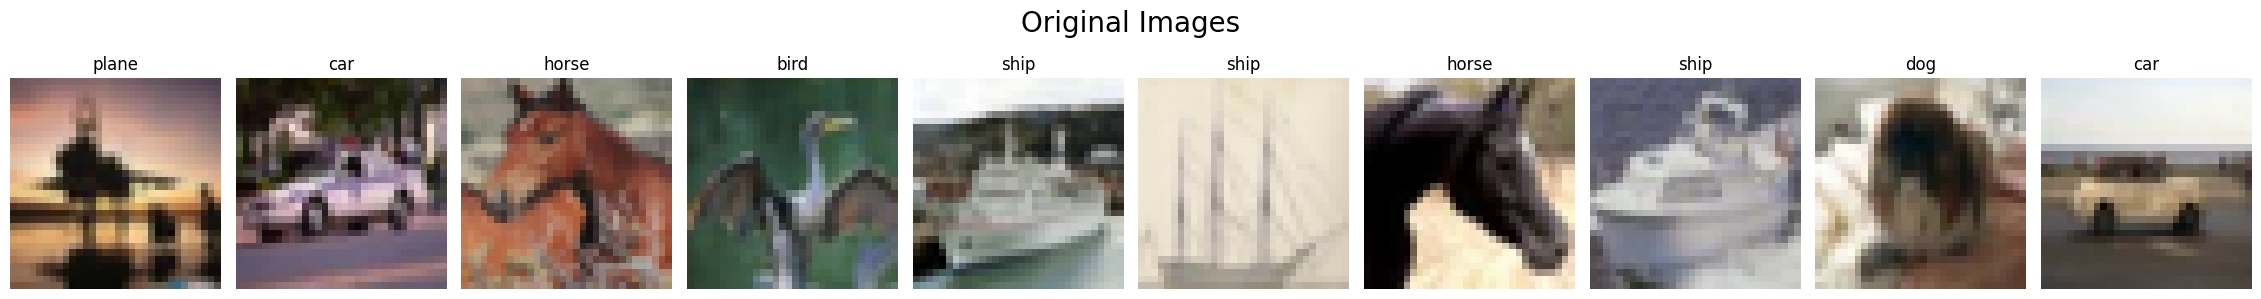

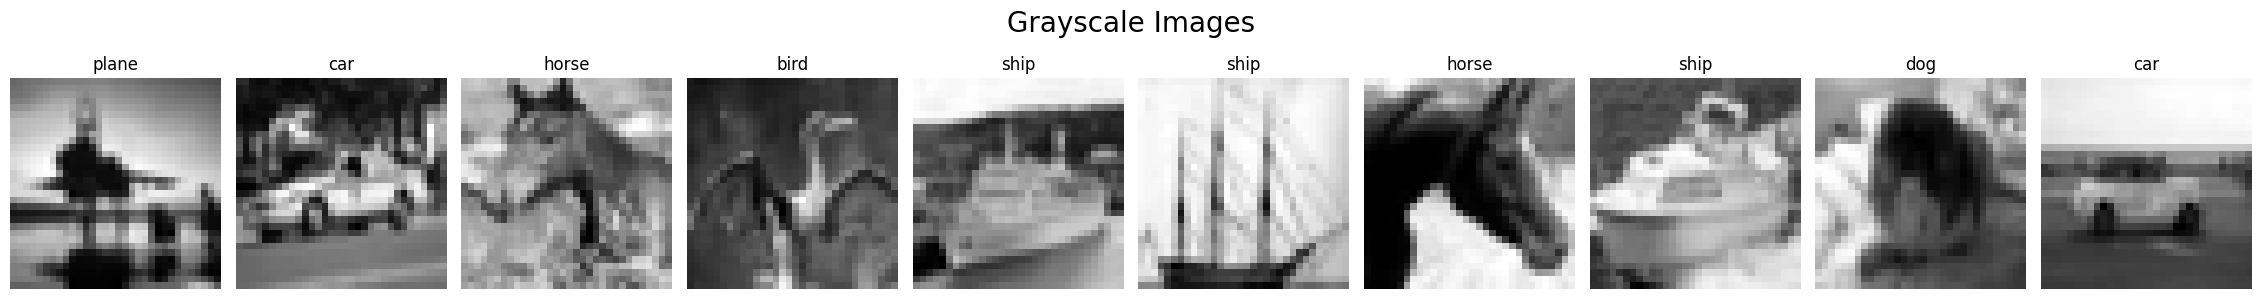

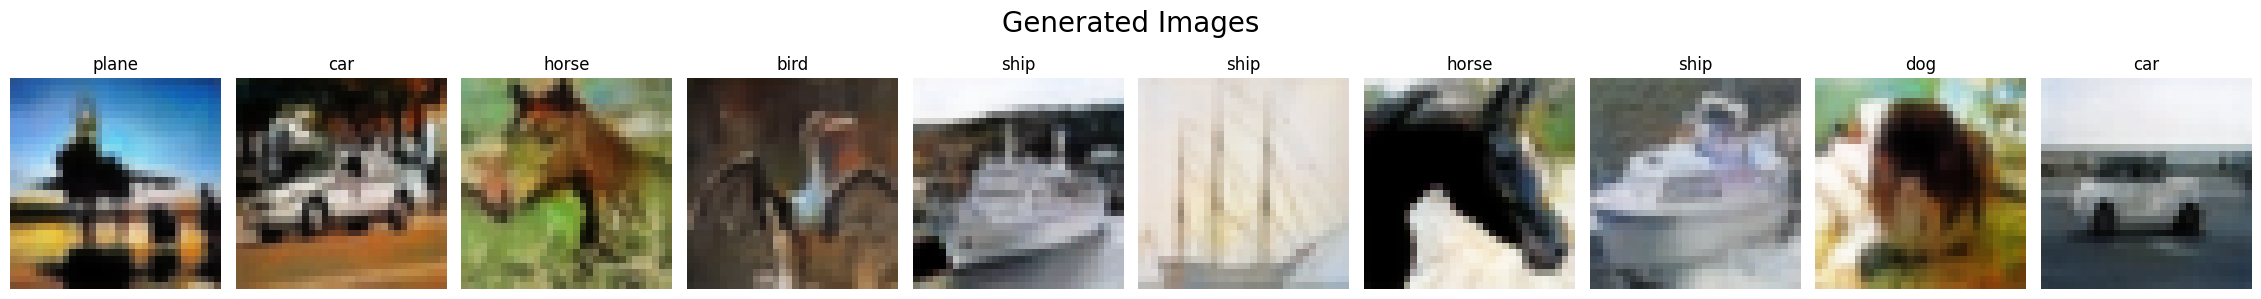

Batch 5


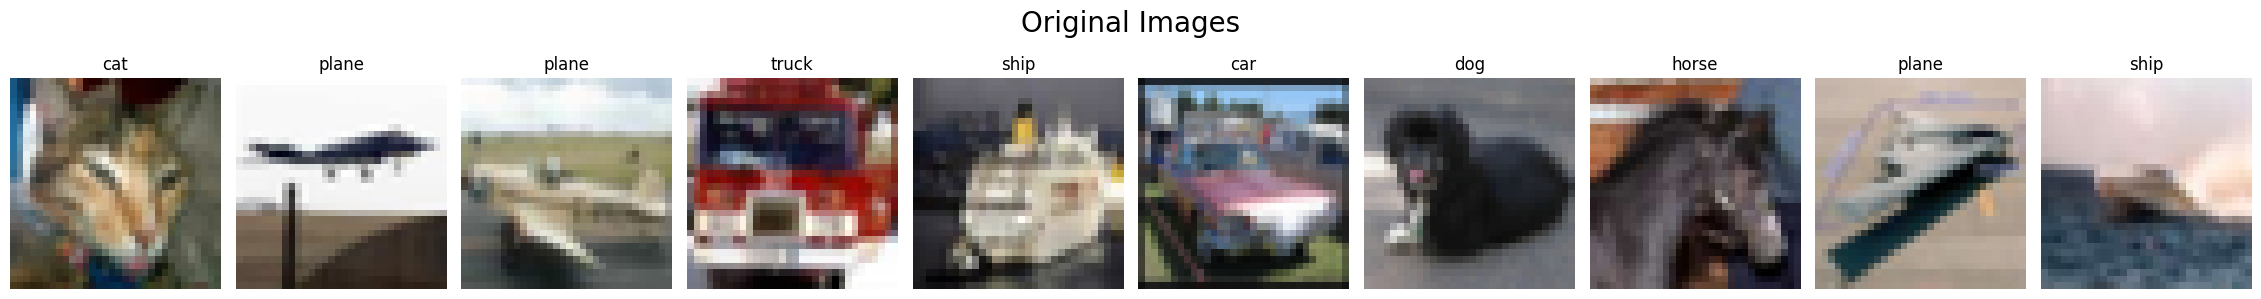

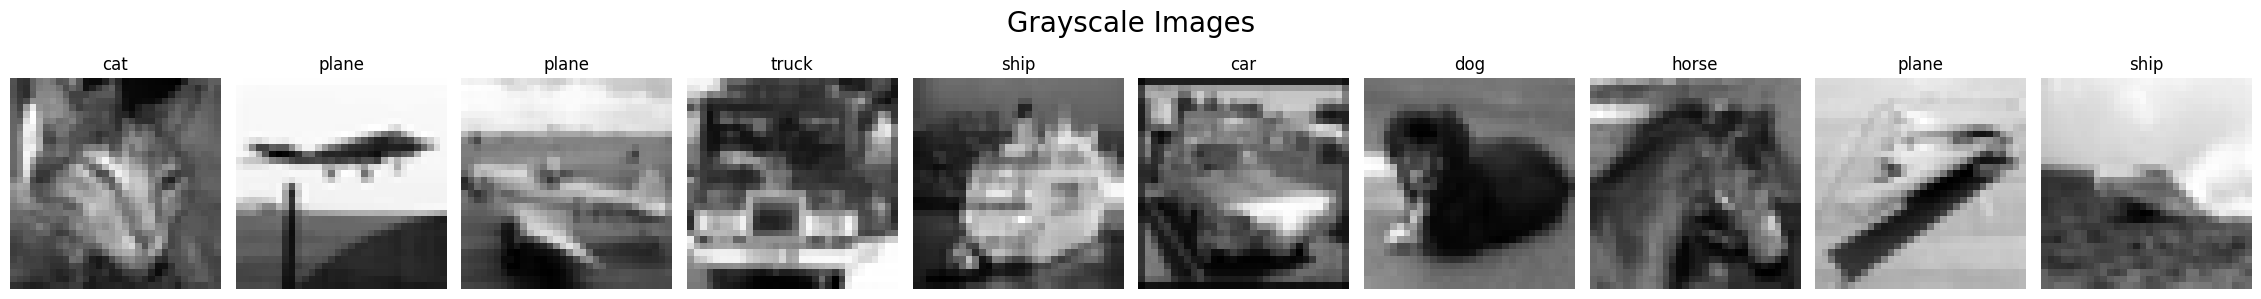

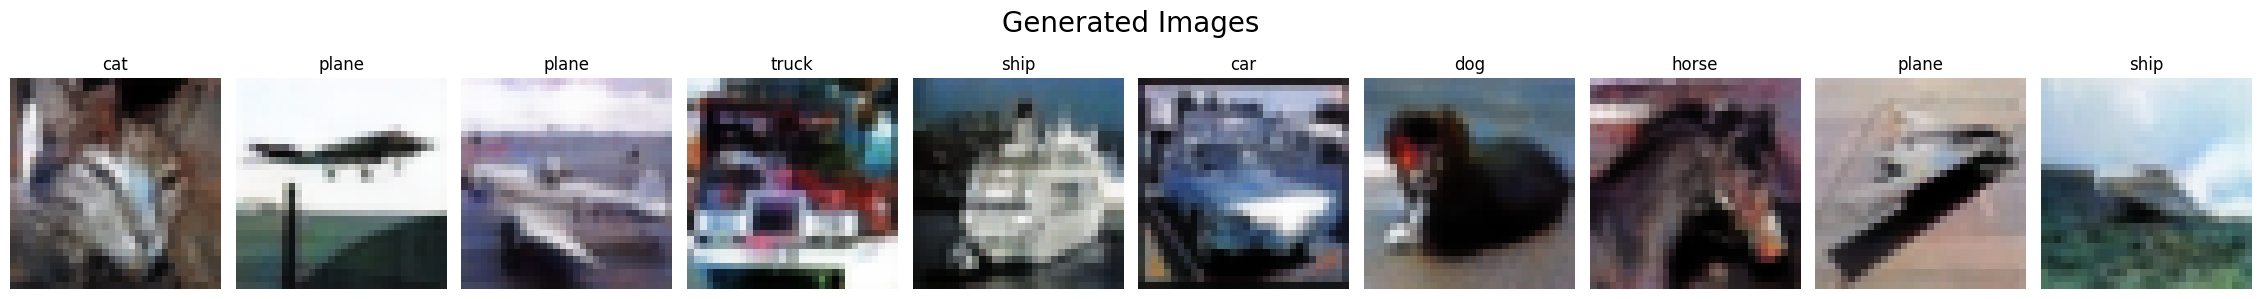

Batch 6


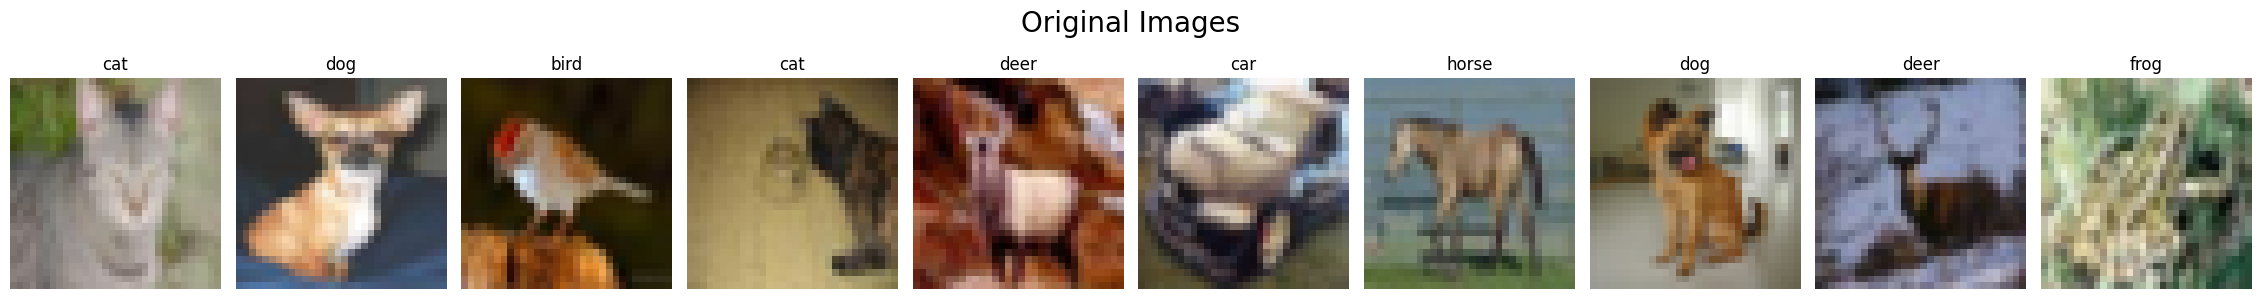

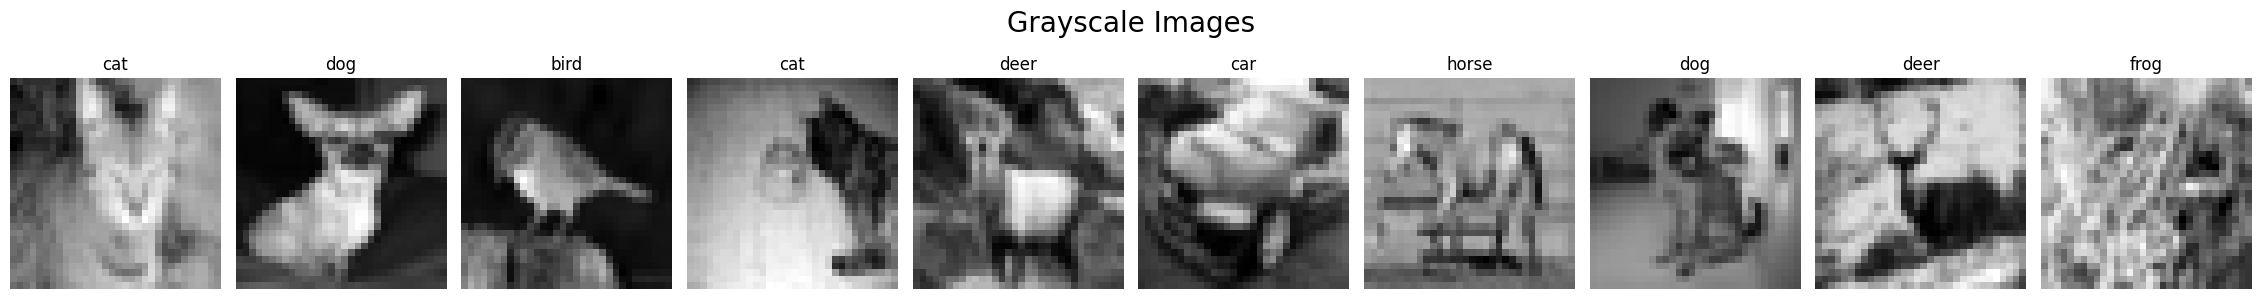

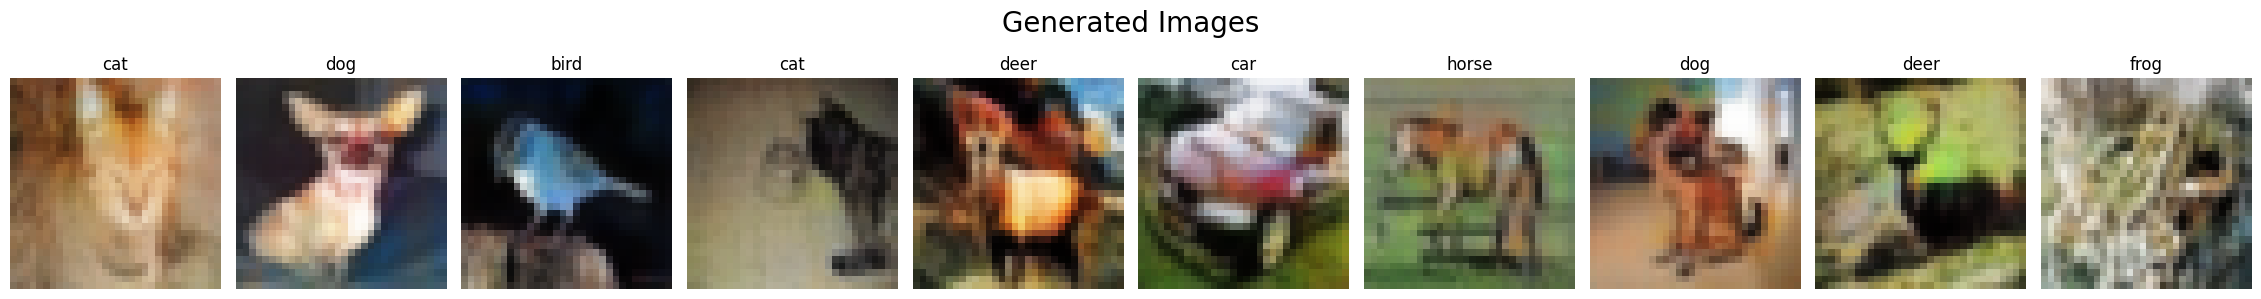

Batch 7


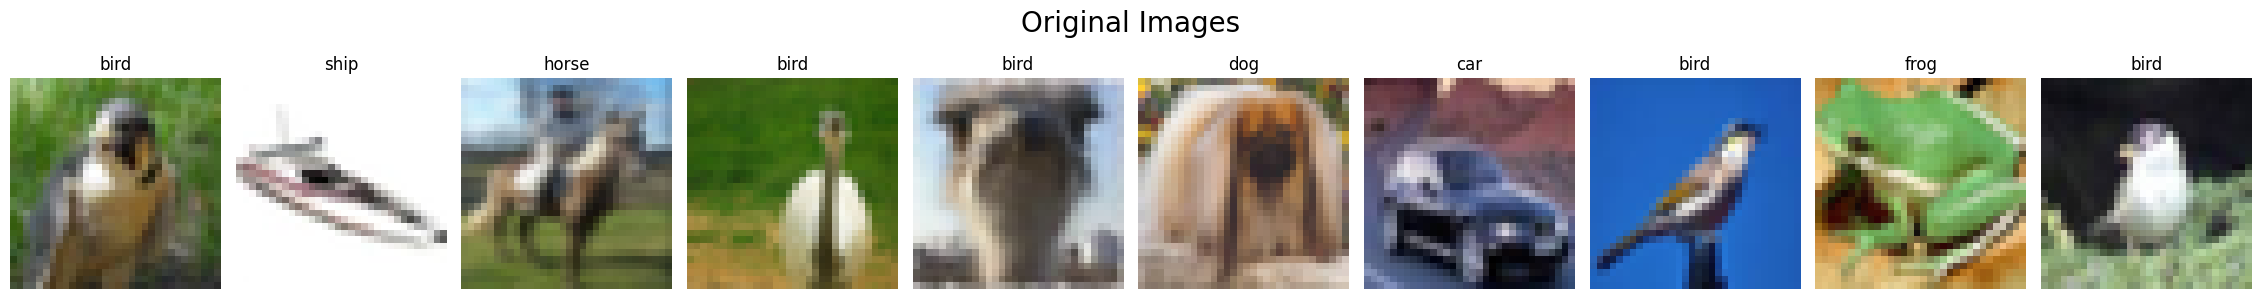

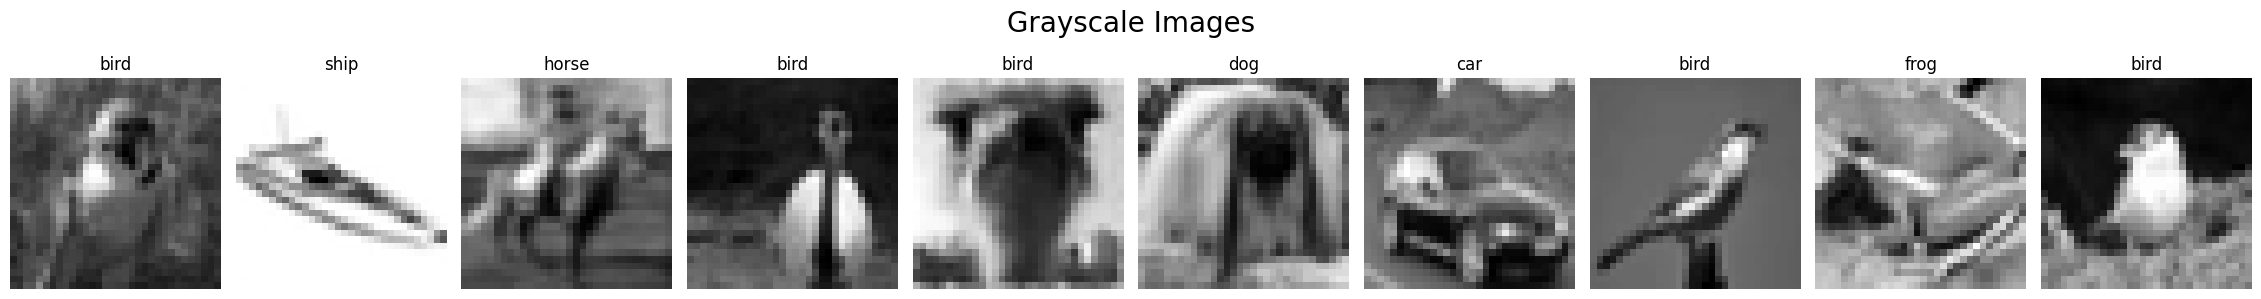

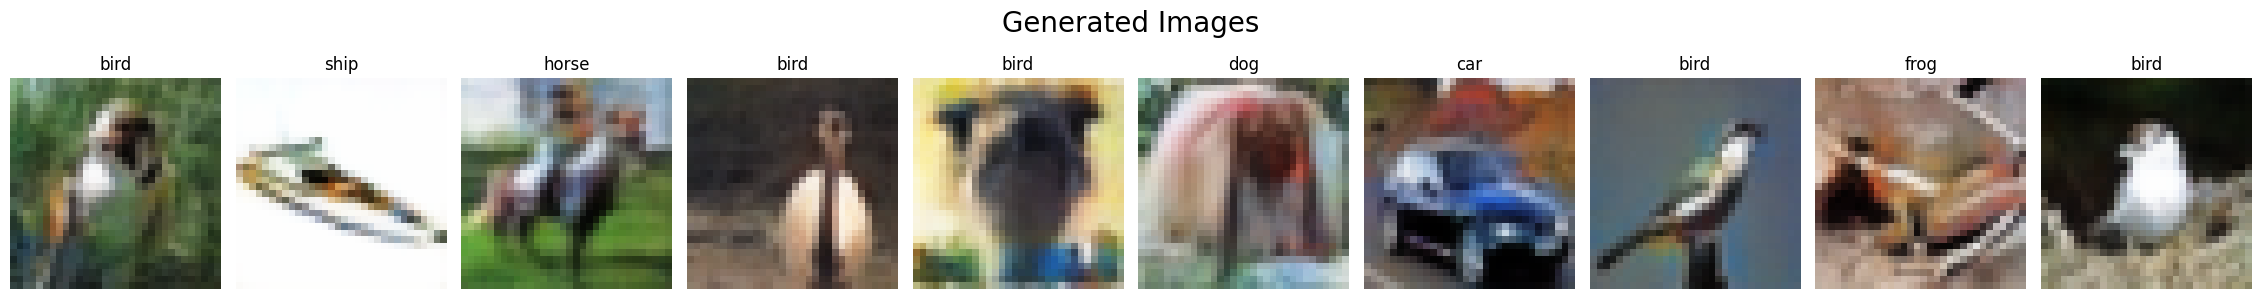

Batch 8


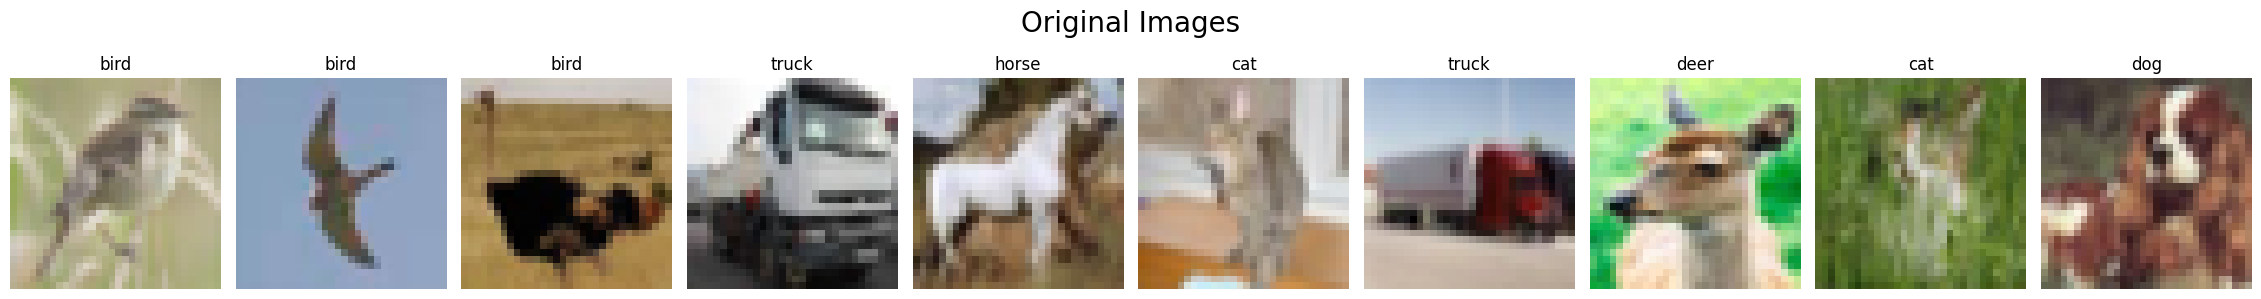

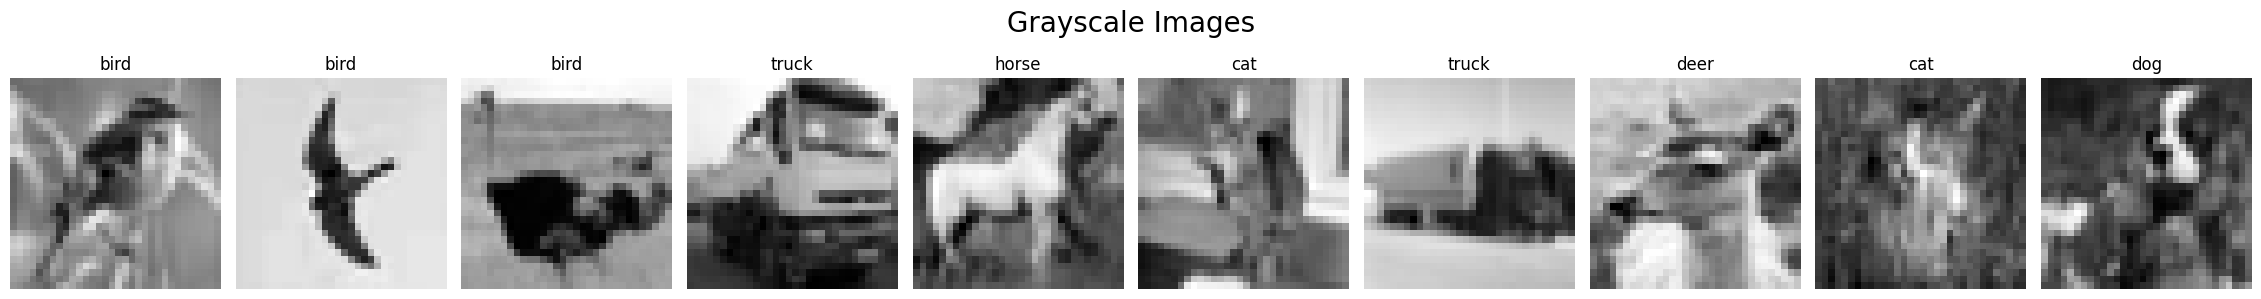

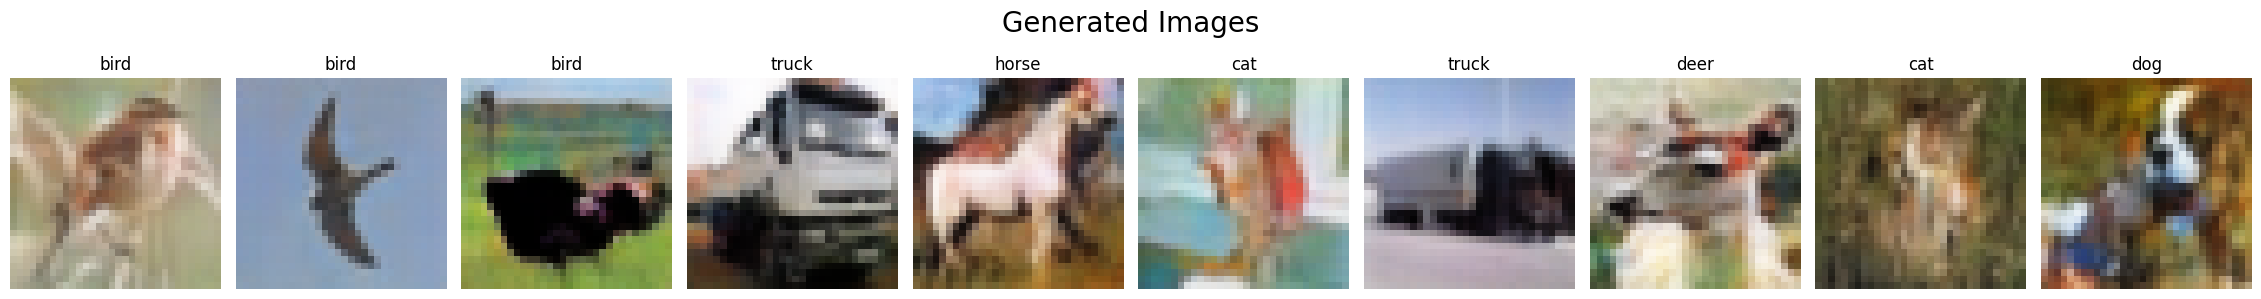

Batch 9


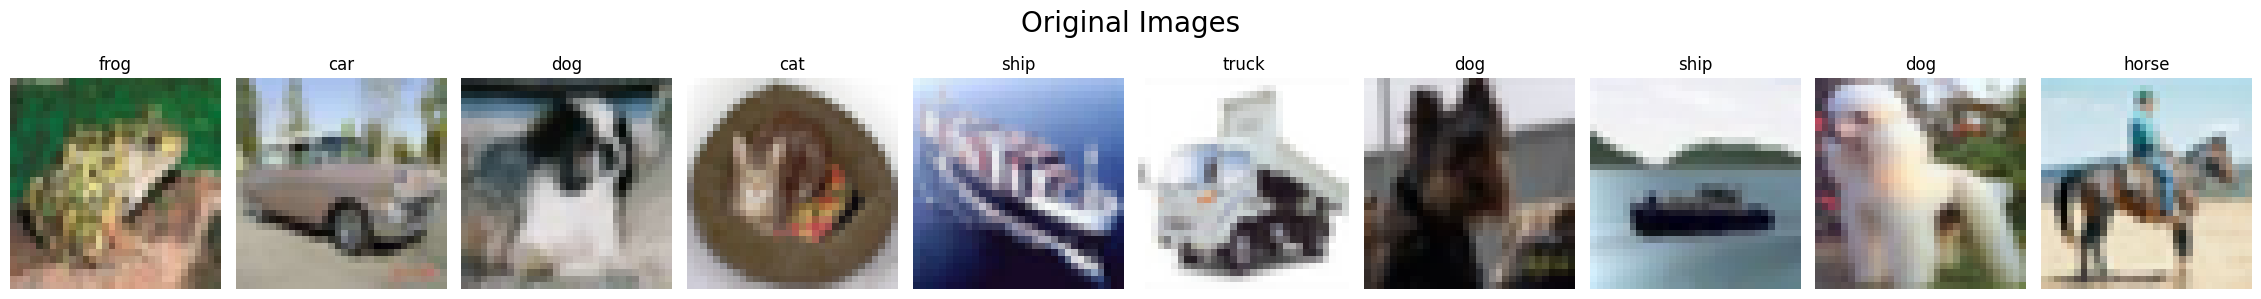

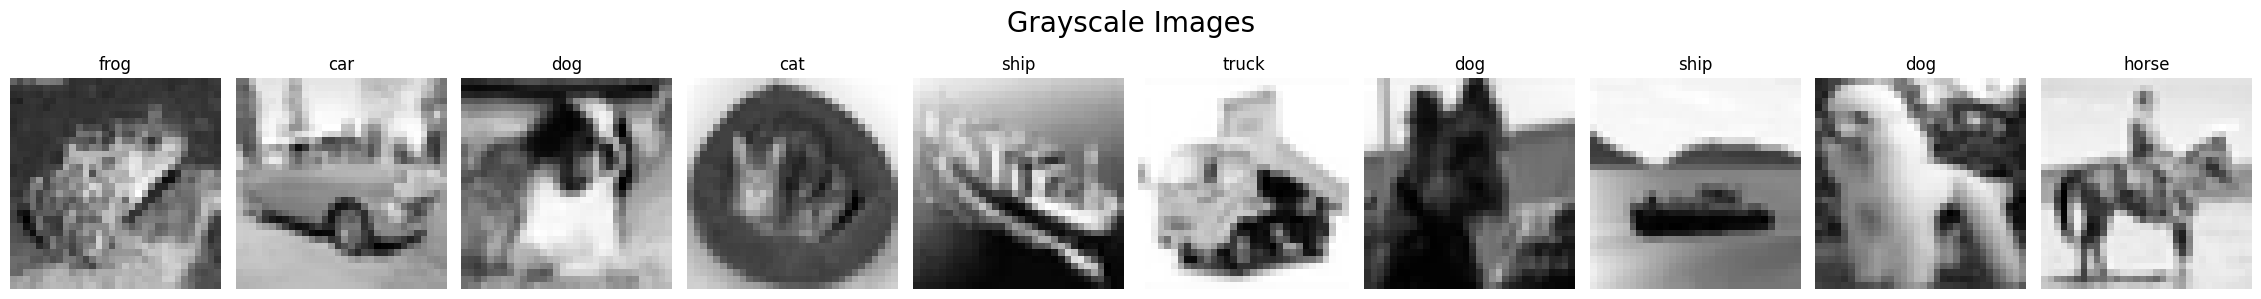

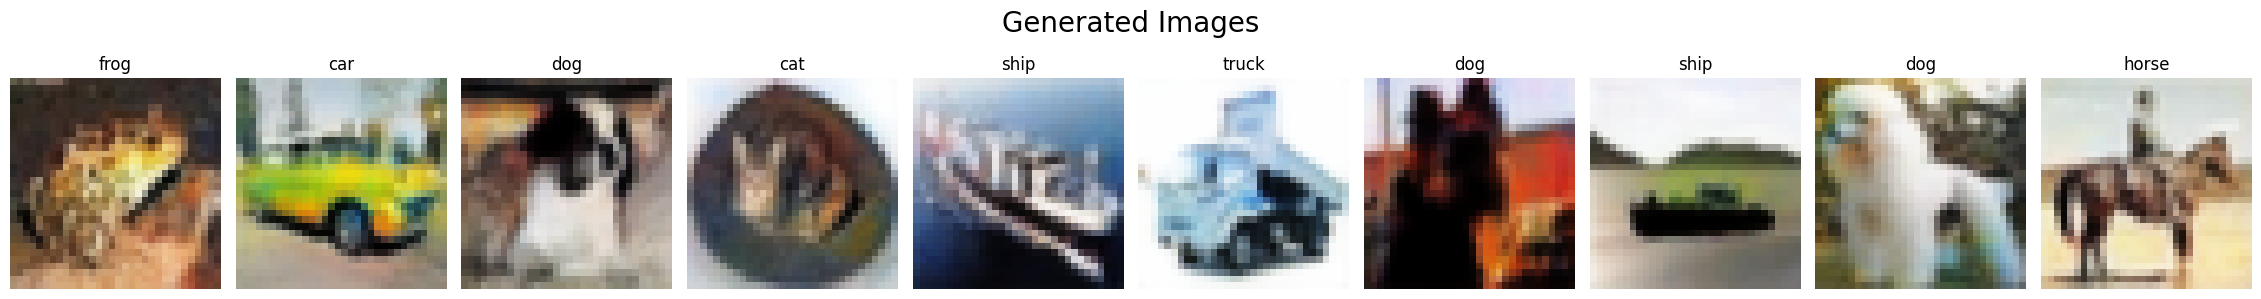

Batch 10


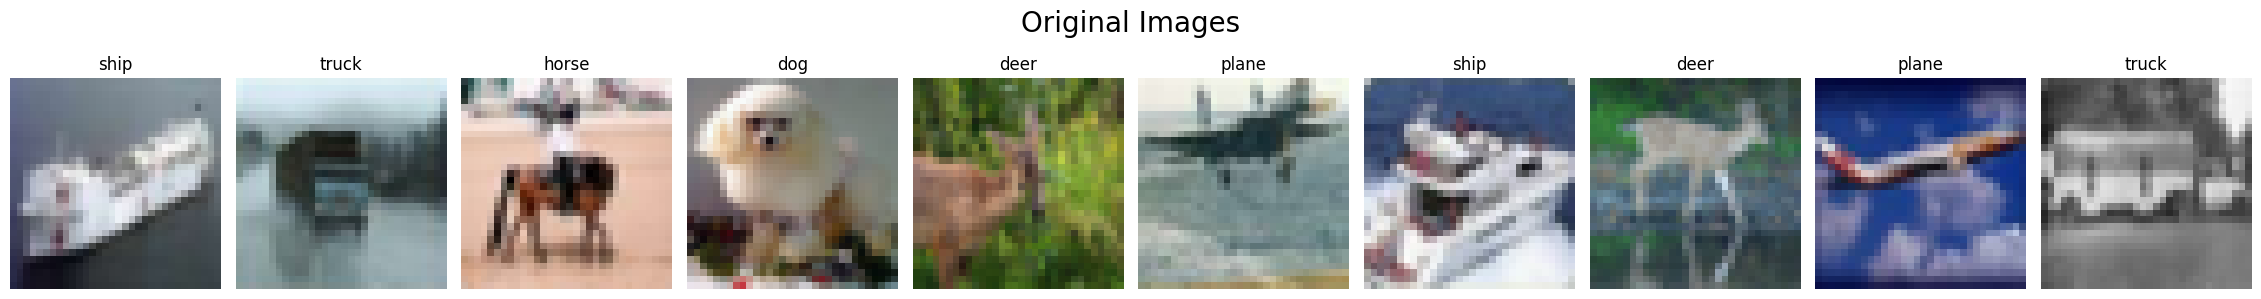

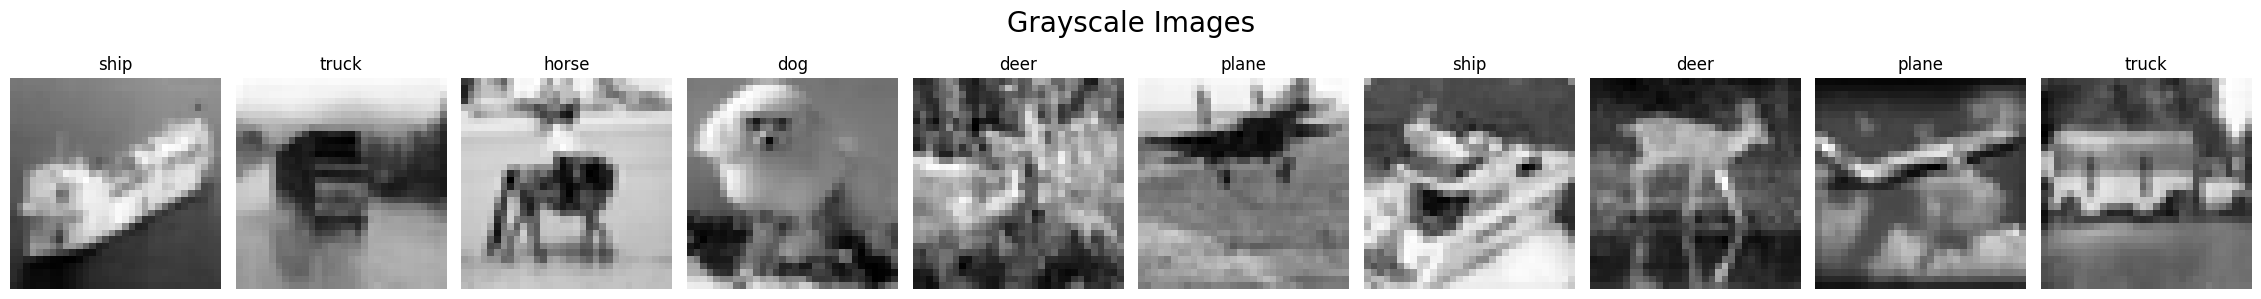

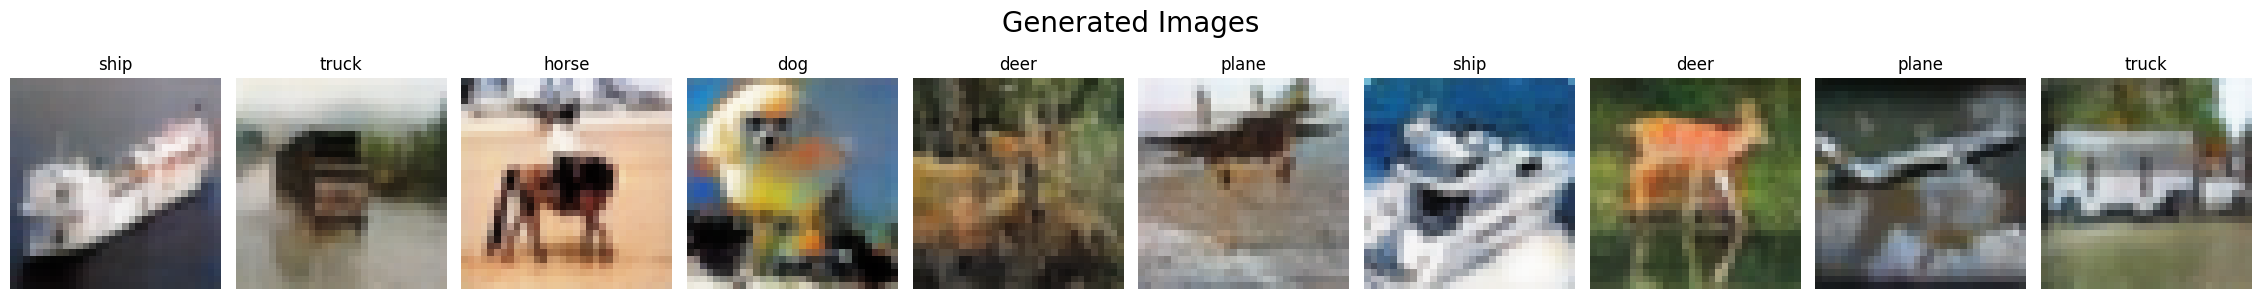

Batch 11


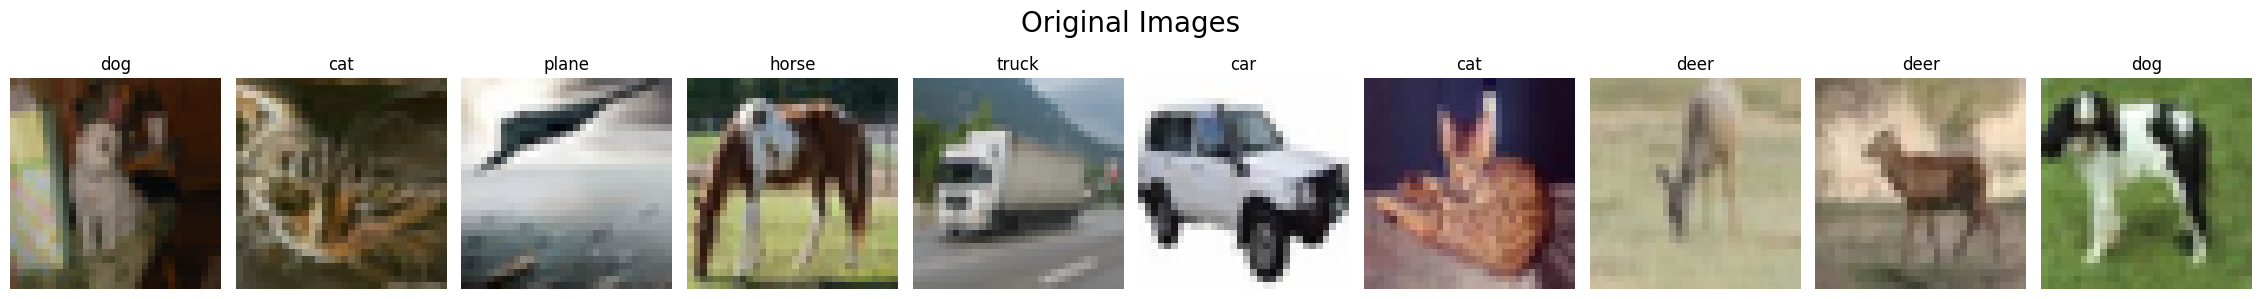

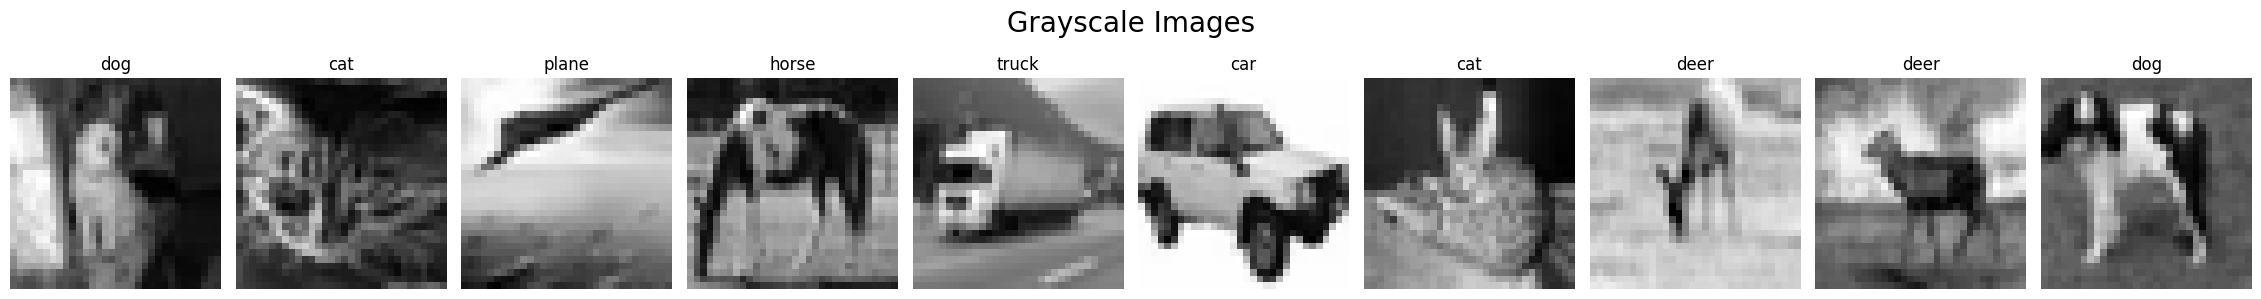

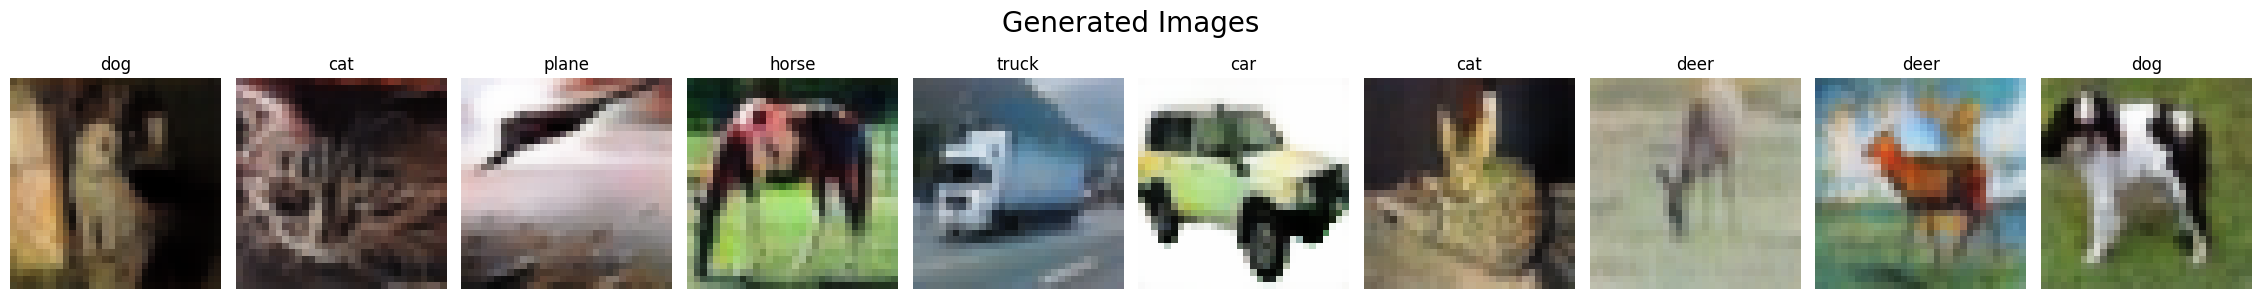

Generator test loss: 0.16941349830627442
Discriminator test loss: 0.034766302824020386


In [ ]:
test_GAN(generator, discriminator, 80)

In [ ]:
def cifar10_augmented(batch_sz, valid_size=0.2, shuffle=True, random_seed=2500):
  transform_train = transforms.Compose([
      transforms.RandomRotation(5),
      transforms.RandomHorizontalFlip(0.1),
      transforms.ColorJitter(brightness=0.2),
      transforms.ToTensor(),
  ])
  transform_valid = transforms.ToTensor()
  transform_test = transforms.ToTensor()

  train_dataset = CIFAR10(root='./datasets', train=True, download=True, transform=transform_train)
  valid_dataset = CIFAR10(root='./datasets', train=True, download=True, transform=transform_valid)

  num_train = len(train_dataset)
  indices = list(range(num_train))
  split = int(np.floor(valid_size * num_train))
  if shuffle:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
  train_idx, valid_idx = indices[split:], indices[:split]

  train_sampler = SubsetRandomSampler(train_idx)
  valid_sampler = SubsetRandomSampler(valid_idx)
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_sz, sampler=train_sampler, pin_memory=True)
  valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_sz, sampler=valid_sampler, pin_memory=True)

  test_dataset = CIFAR10(root='./datasets', train=False, download=True, transform=transform_test)
  test_loader = DataLoader(test_dataset, batch_size=batch_sz)

  return train_loader, valid_loader, test_loader

3 transformation have been applied: random rotations, random horizontal flips and brightness variations.

In [ ]:
batch_sz=64 # this is batch size i.e. the number of rows in a batch of data

train_loader, valid_loader, test_loader = cifar10_augmented(batch_sz)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


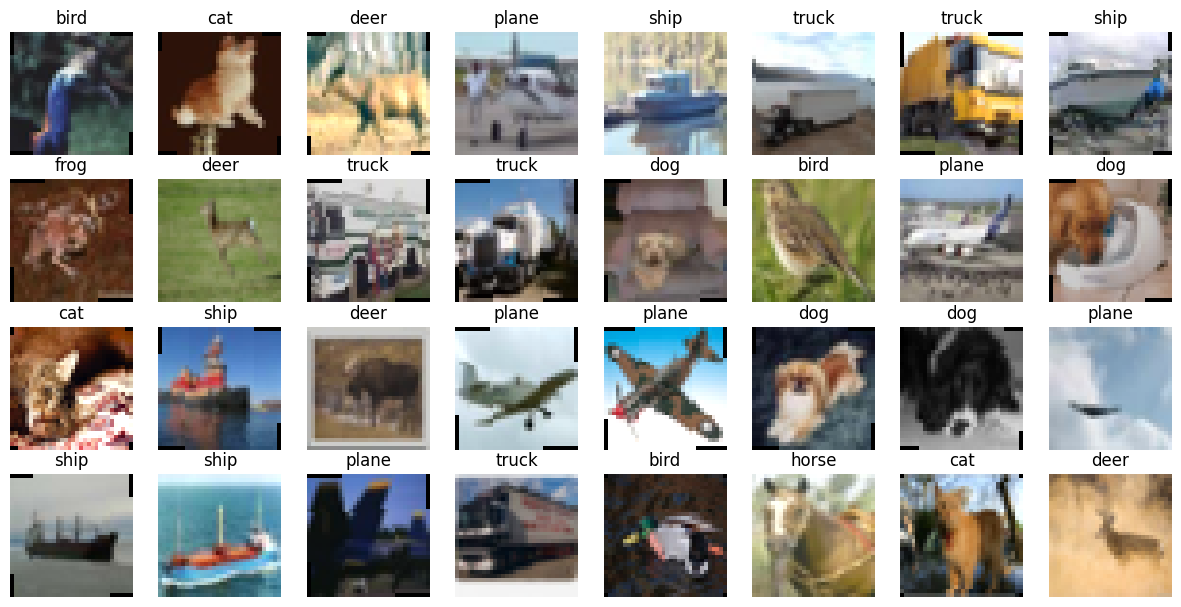

In [ ]:
visualize_dataset(train_loader)

In [ ]:
device = "cuda"

generator = Generator()
generator.apply(weights_init)
generator.to(device)

discriminator = Discriminator()
discriminator.apply(weights_init)
discriminator.to(device)

real_label = 1
fake_label = 0

<ipython-input-64-ed980bec2877>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


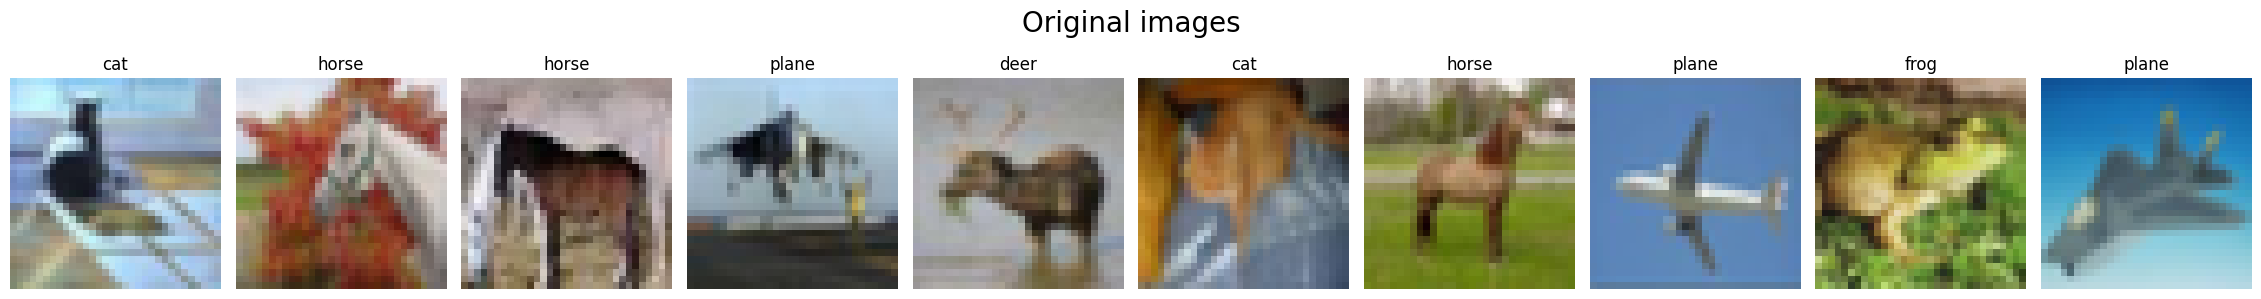

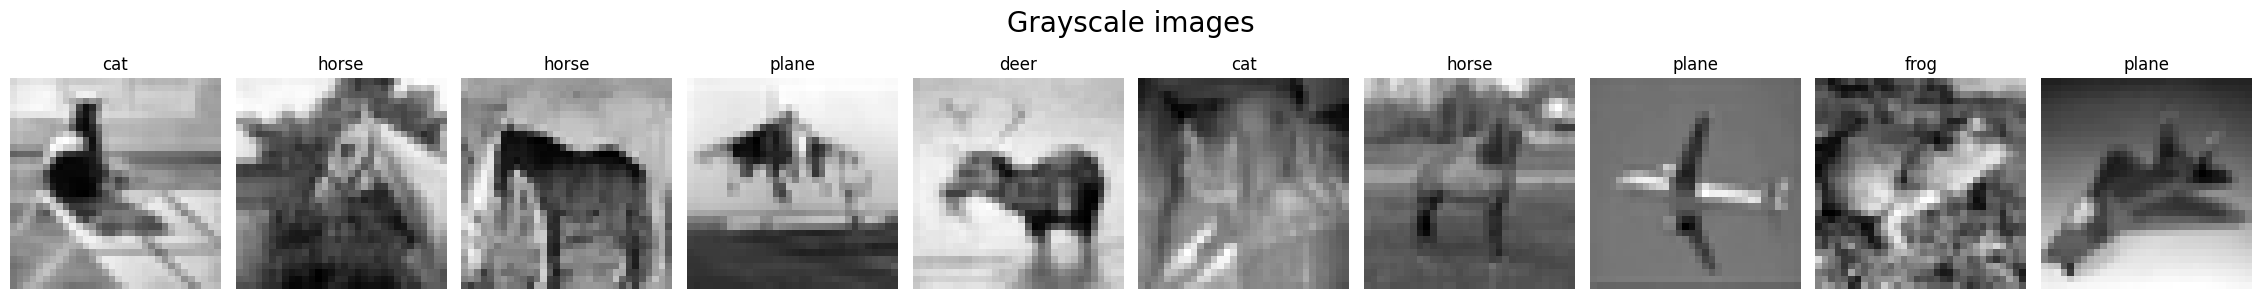

Adjusting learning rate of group 0 to 5.0000e-05.


Epoch 1/20: : 100%|██████████| 625/625 [01:25<00:00,  7.29it/s, generator_loss=9.28, discriminator_loss=0.735, D(x)=0.672, D(G(z1))=0.282, D(G(z2))=0.277]


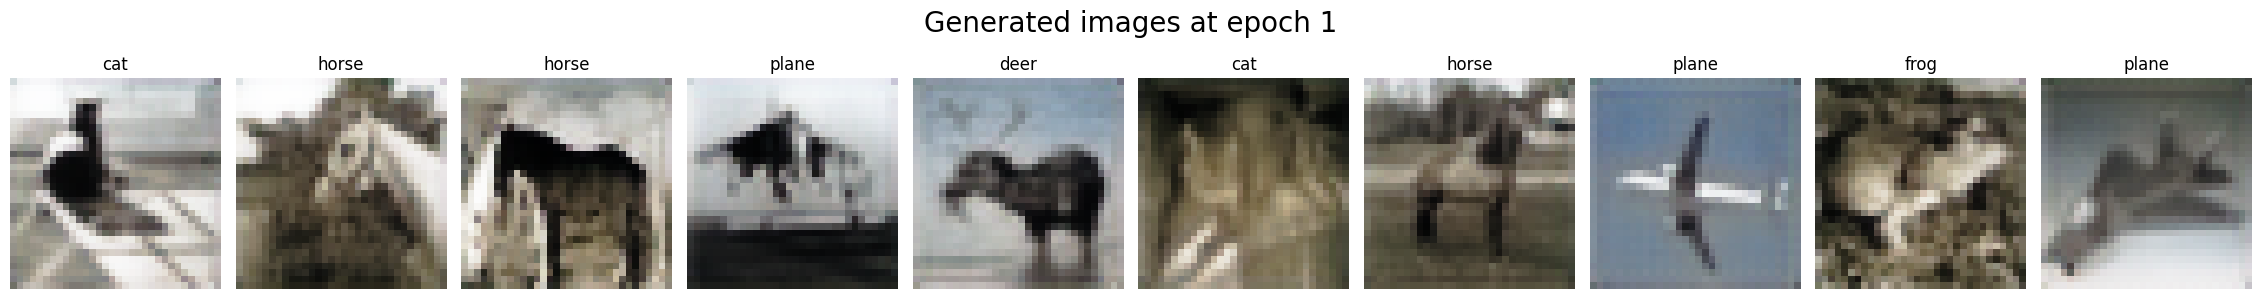

Adjusting learning rate of group 0 to 4.9000e-05.


Epoch 2/20: : 100%|██████████| 625/625 [01:26<00:00,  7.24it/s, generator_loss=9.25, discriminator_loss=0.903, D(x)=0.689, D(G(z1))=0.399, D(G(z2))=0.41]


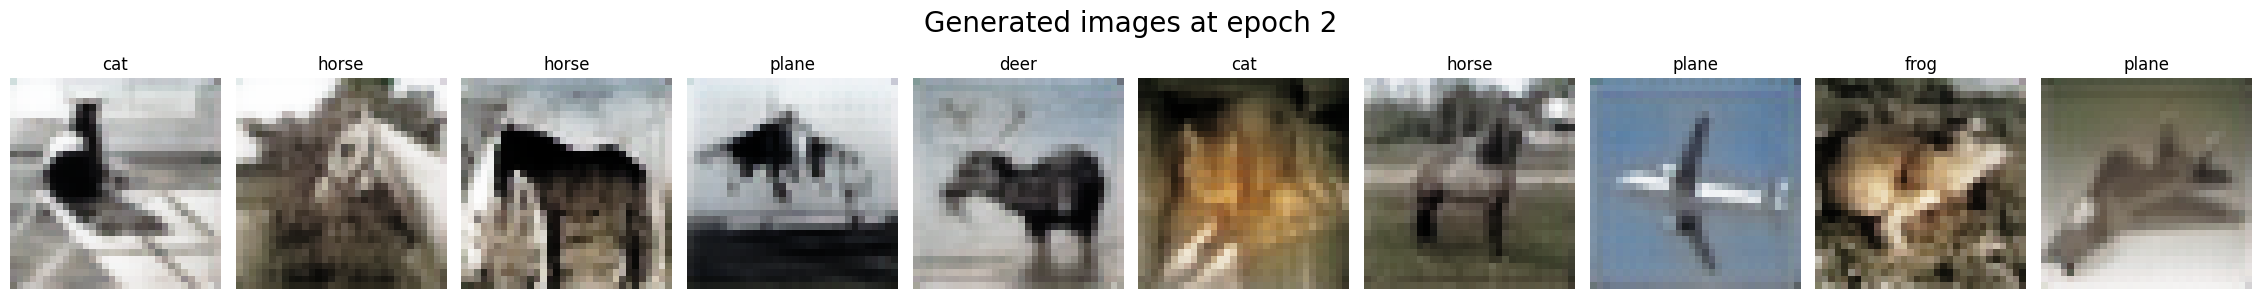

Adjusting learning rate of group 0 to 4.8020e-05.


Epoch 3/20: : 100%|██████████| 625/625 [01:26<00:00,  7.27it/s, generator_loss=9.35, discriminator_loss=0.236, D(x)=0.888, D(G(z1))=0.11, D(G(z2))=0.105]


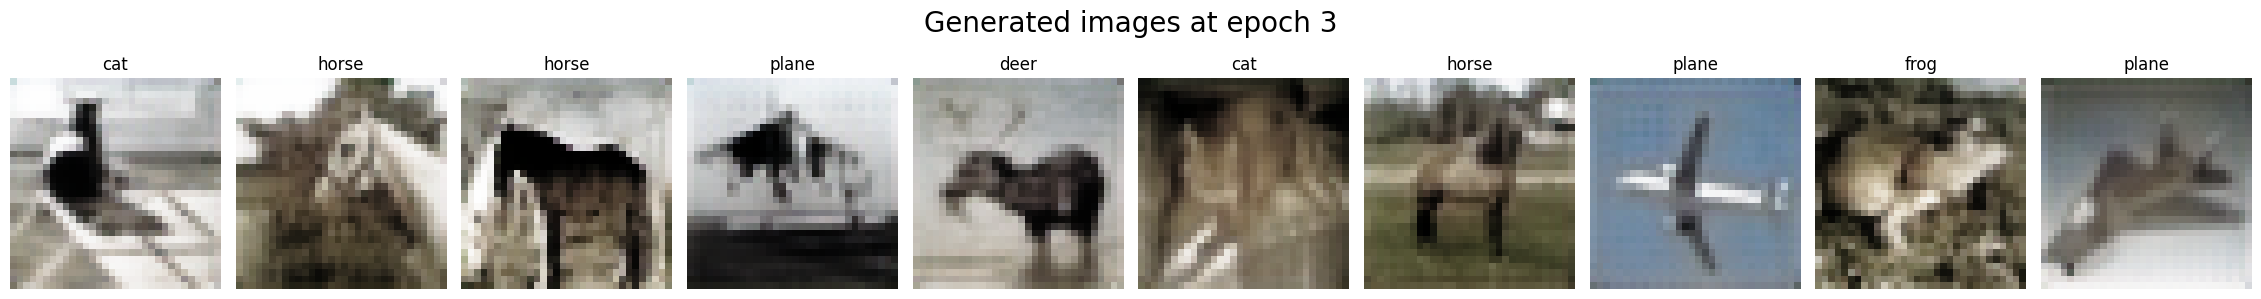

Adjusting learning rate of group 0 to 4.7060e-05.


Epoch 4/20: : 100%|██████████| 625/625 [01:26<00:00,  7.26it/s, generator_loss=9.51, discriminator_loss=0.729, D(x)=0.789, D(G(z1))=0.384, D(G(z2))=0.229]


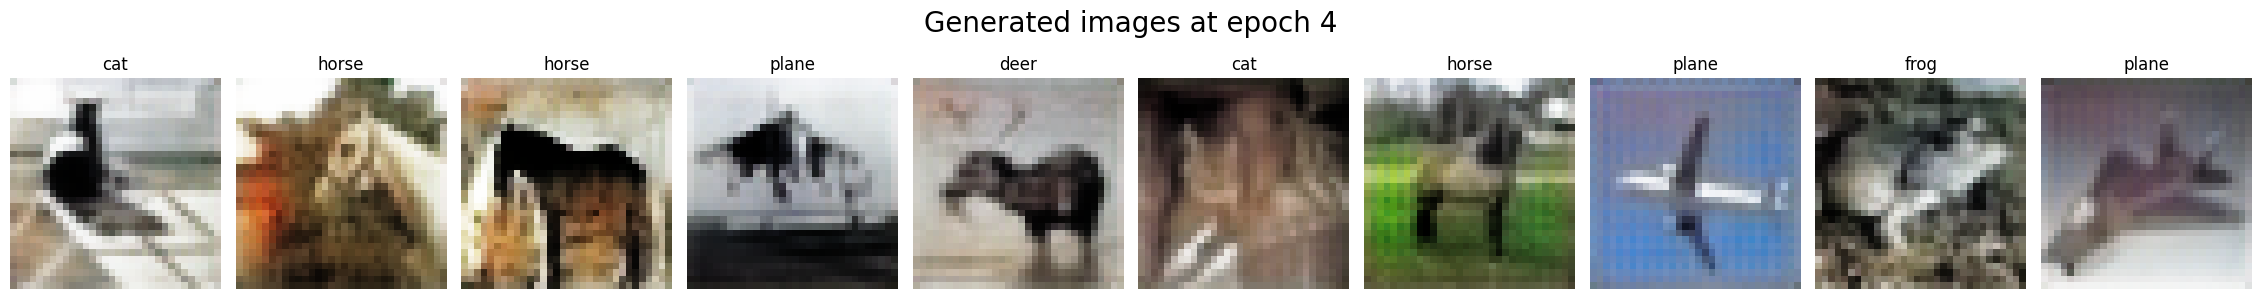

Adjusting learning rate of group 0 to 4.6118e-05.


Epoch 5/20: : 100%|██████████| 625/625 [01:25<00:00,  7.28it/s, generator_loss=9.38, discriminator_loss=1.38, D(x)=0.421, D(G(z1))=0.388, D(G(z2))=0.364]


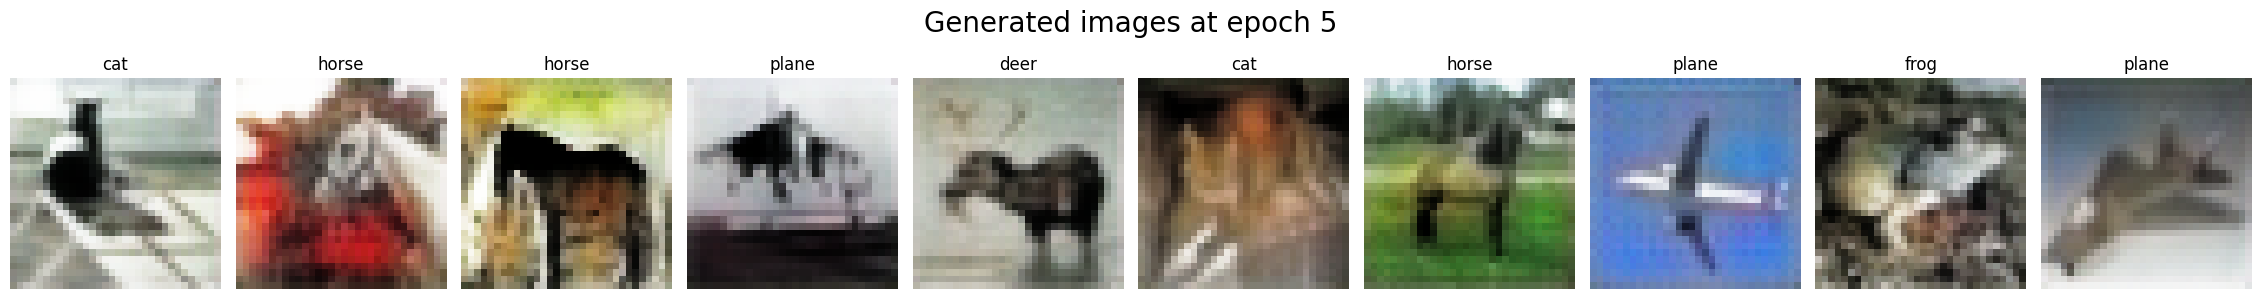

Adjusting learning rate of group 0 to 4.5196e-05.


Epoch 6/20: : 100%|██████████| 625/625 [01:25<00:00,  7.33it/s, generator_loss=9.69, discriminator_loss=0.316, D(x)=0.909, D(G(z1))=0.193, D(G(z2))=0.17]


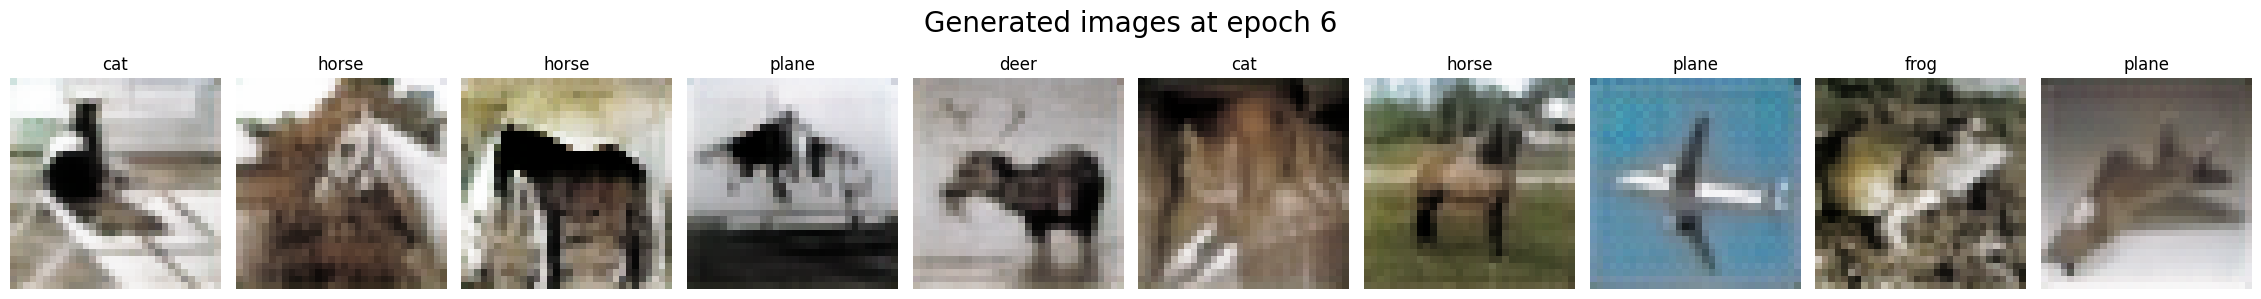

Adjusting learning rate of group 0 to 4.4292e-05.


Epoch 7/20: : 100%|██████████| 625/625 [01:25<00:00,  7.27it/s, generator_loss=10.2, discriminator_loss=1.82, D(x)=0.268, D(G(z1))=0.372, D(G(z2))=0.34]


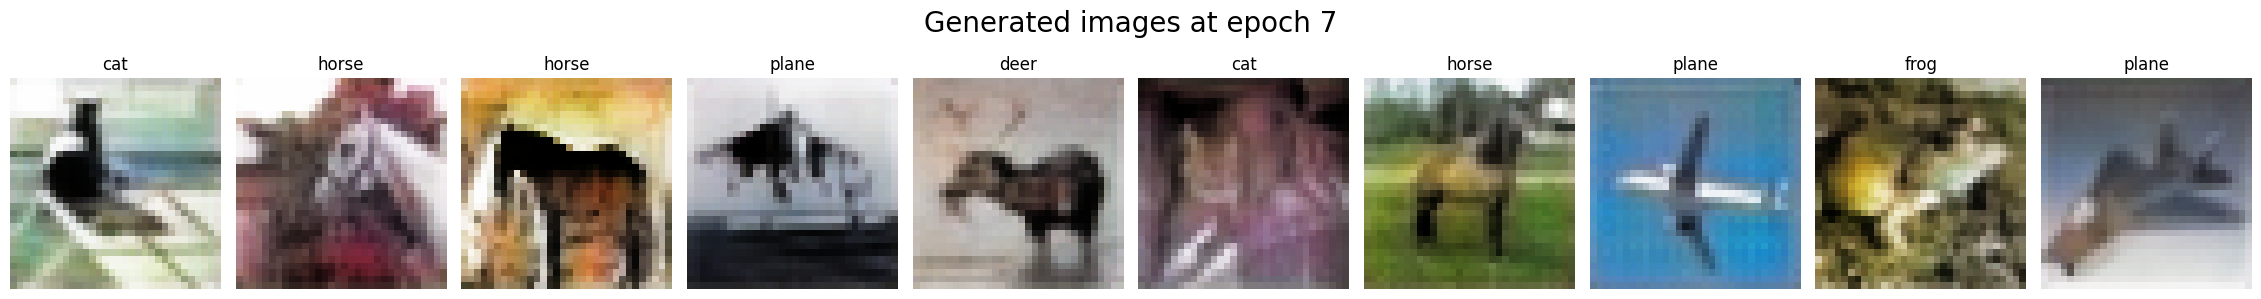

Adjusting learning rate of group 0 to 4.3406e-05.


Epoch 8/20: : 100%|██████████| 625/625 [01:25<00:00,  7.28it/s, generator_loss=8.62, discriminator_loss=1.01, D(x)=0.674, D(G(z1))=0.451, D(G(z2))=0.439]


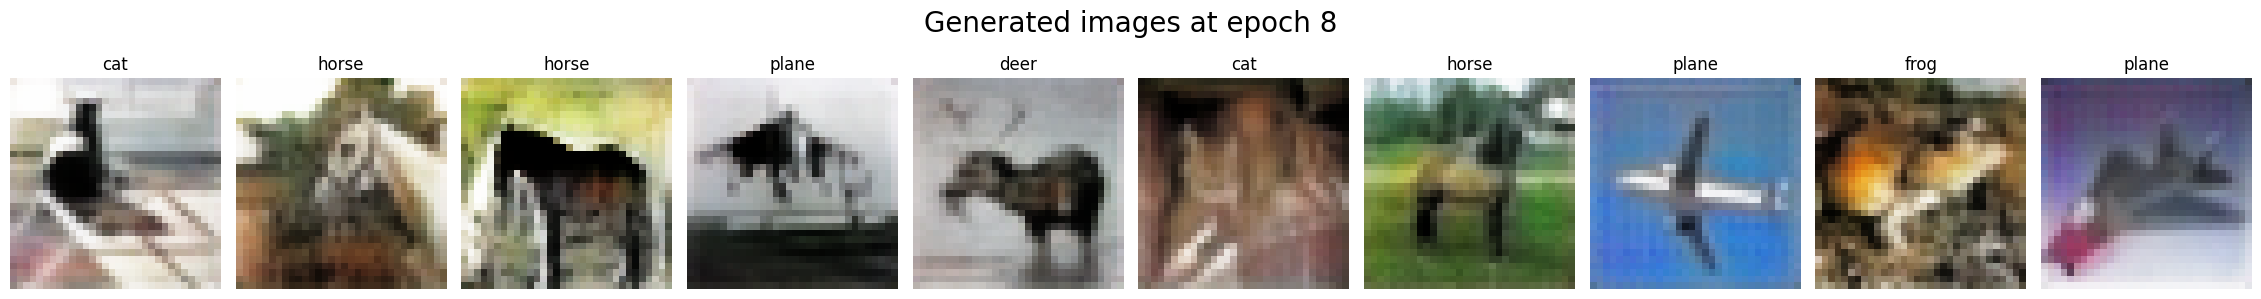

Adjusting learning rate of group 0 to 4.2538e-05.


Epoch 9/20: : 100%|██████████| 625/625 [01:26<00:00,  7.26it/s, generator_loss=9.14, discriminator_loss=0.193, D(x)=0.942, D(G(z1))=0.124, D(G(z2))=0.122]


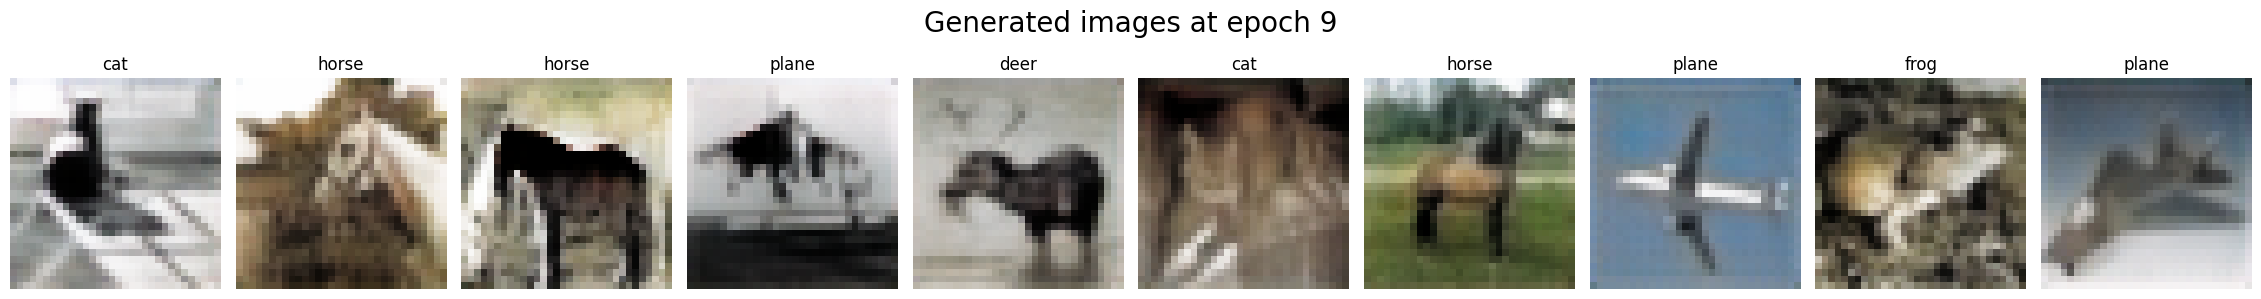

Adjusting learning rate of group 0 to 4.1687e-05.


Epoch 10/20: : 100%|██████████| 625/625 [01:26<00:00,  7.25it/s, generator_loss=9.49, discriminator_loss=1.58, D(x)=0.339, D(G(z1))=0.371, D(G(z2))=0.319]


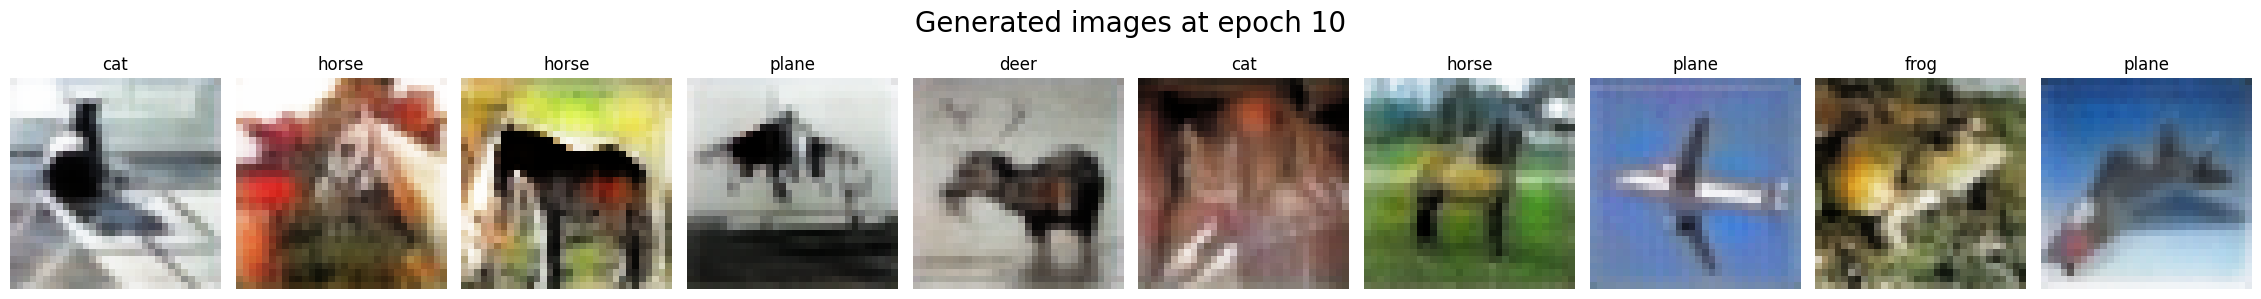

Adjusting learning rate of group 0 to 4.0854e-05.


Epoch 11/20: : 100%|██████████| 625/625 [01:26<00:00,  7.26it/s, generator_loss=9.97, discriminator_loss=1.71, D(x)=0.3, D(G(z1))=0.381, D(G(z2))=0.312]


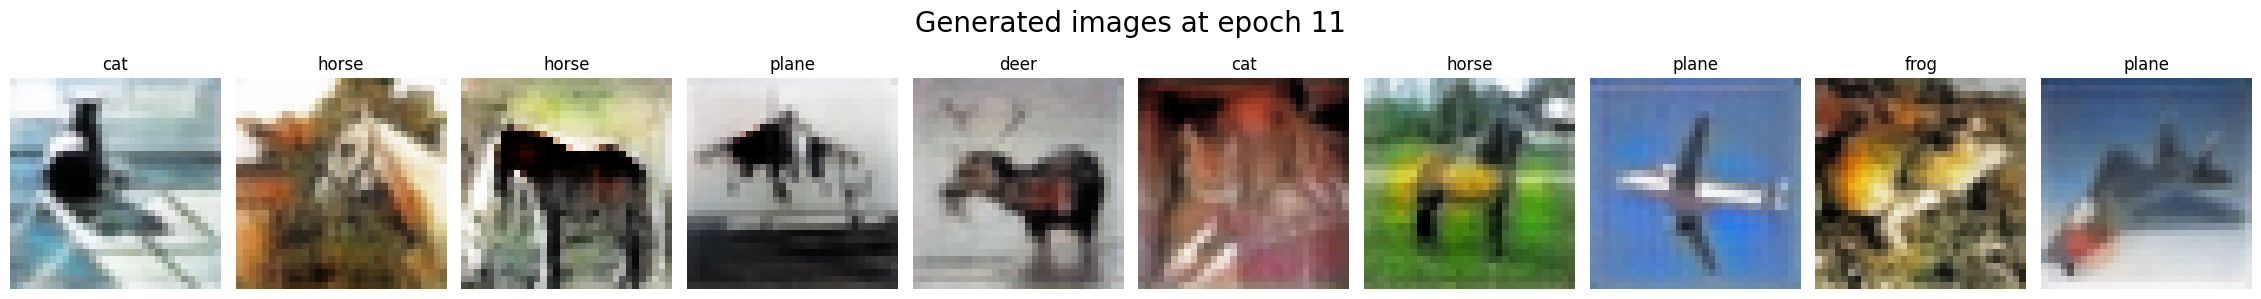

Adjusting learning rate of group 0 to 4.0037e-05.


Epoch 12/20: : 100%|██████████| 625/625 [01:26<00:00,  7.24it/s, generator_loss=8.07, discriminator_loss=1.32, D(x)=0.498, D(G(z1))=0.452, D(G(z2))=0.484]


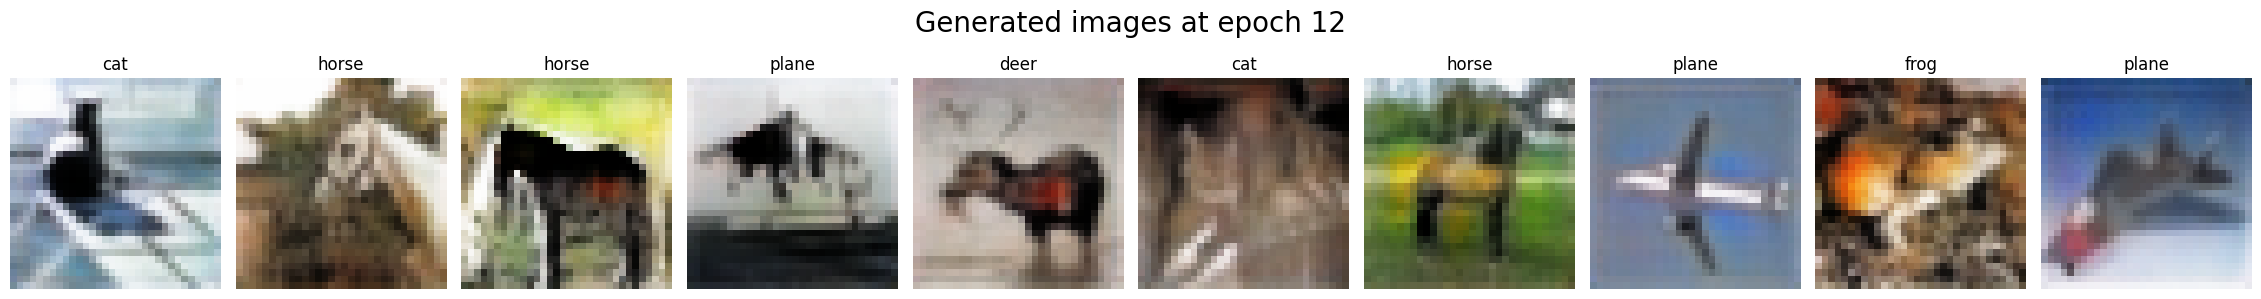

Adjusting learning rate of group 0 to 3.9236e-05.


Epoch 13/20: : 100%|██████████| 625/625 [01:26<00:00,  7.27it/s, generator_loss=8.1, discriminator_loss=1.83, D(x)=0.3, D(G(z1))=0.451, D(G(z2))=0.374]


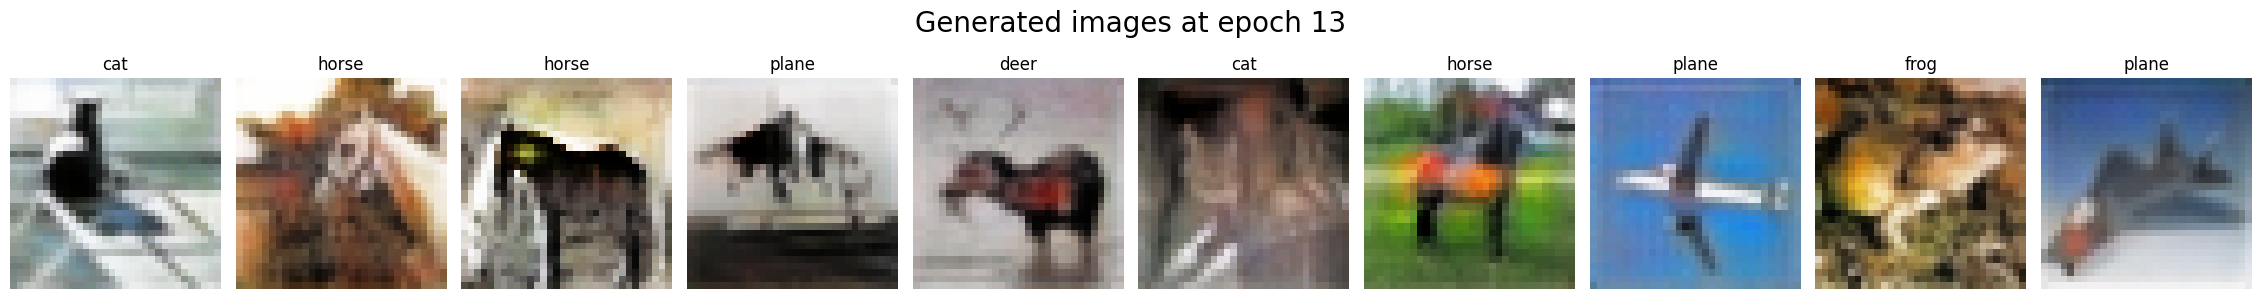

Adjusting learning rate of group 0 to 3.8451e-05.


Epoch 14/20: : 100%|██████████| 625/625 [01:26<00:00,  7.25it/s, generator_loss=8.74, discriminator_loss=1.12, D(x)=0.666, D(G(z1))=0.497, D(G(z2))=0.461]


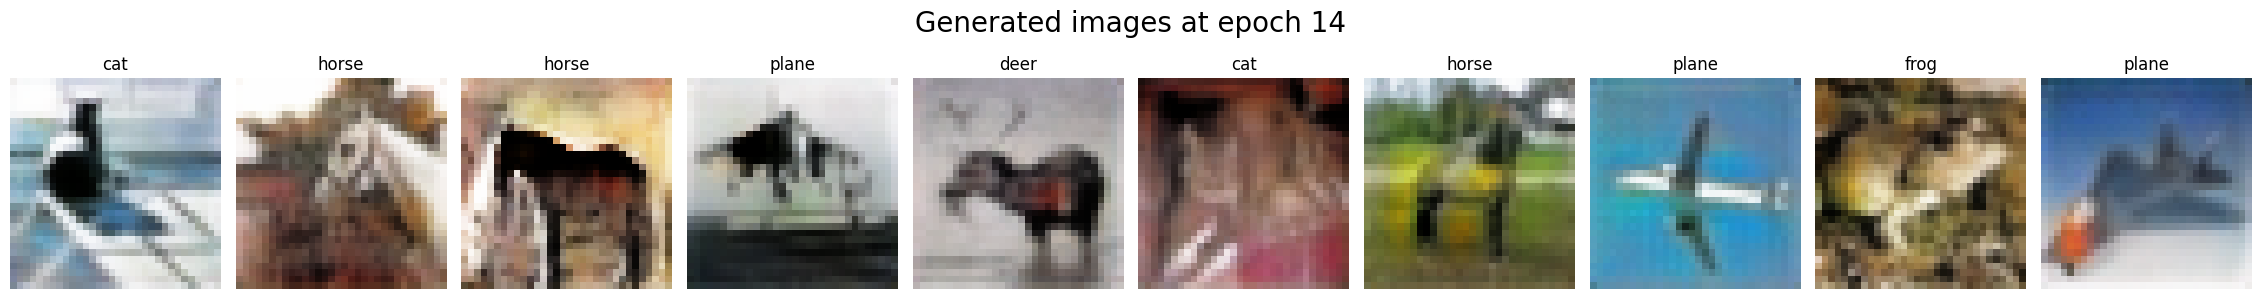

Adjusting learning rate of group 0 to 3.7682e-05.


Epoch 15/20: : 100%|██████████| 625/625 [01:25<00:00,  7.27it/s, generator_loss=7.93, discriminator_loss=1.34, D(x)=0.425, D(G(z1))=0.373, D(G(z2))=0.464]


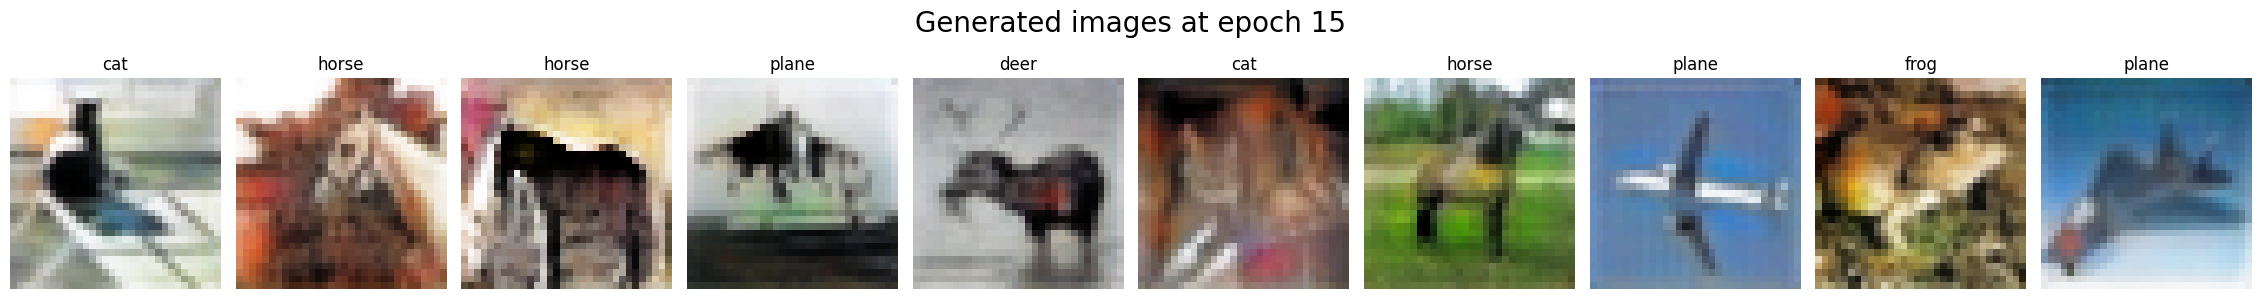

Adjusting learning rate of group 0 to 3.6928e-05.


Epoch 16/20: : 100%|██████████| 625/625 [01:26<00:00,  7.24it/s, generator_loss=8.99, discriminator_loss=0.886, D(x)=0.78, D(G(z1))=0.463, D(G(z2))=0.374]


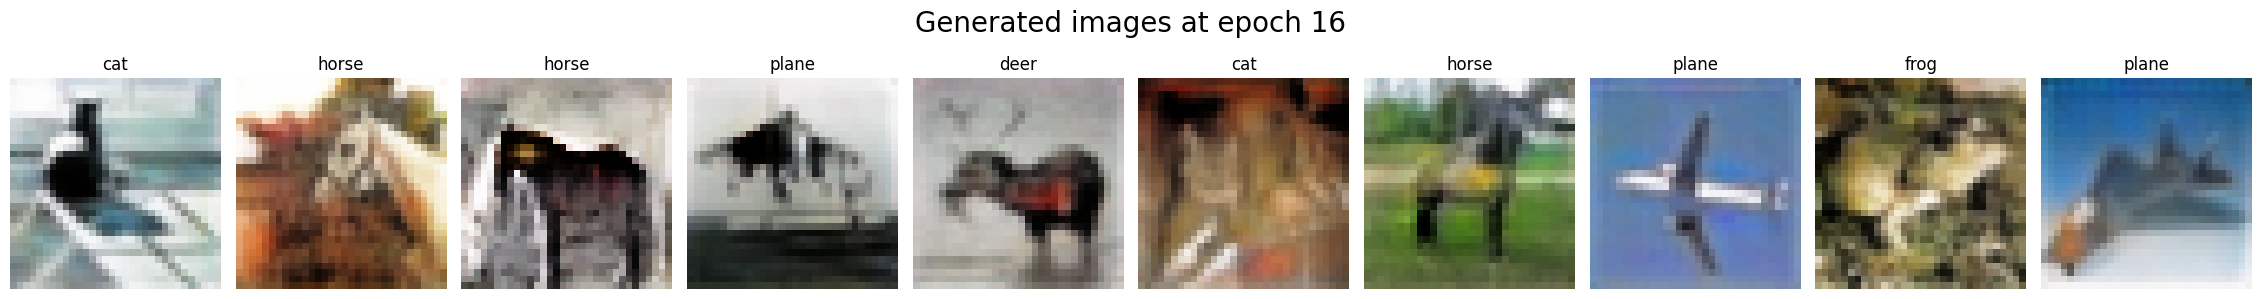

Adjusting learning rate of group 0 to 3.6190e-05.


Epoch 17/20: : 100%|██████████| 625/625 [01:26<00:00,  7.25it/s, generator_loss=8.25, discriminator_loss=1.45, D(x)=0.336, D(G(z1))=0.286, D(G(z2))=0.308]


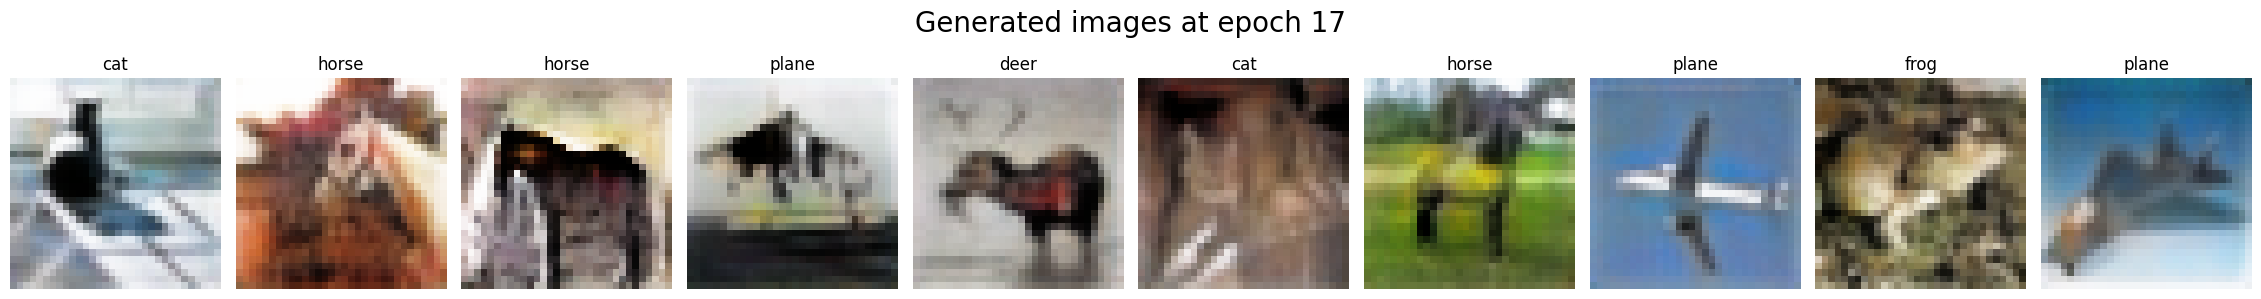

Adjusting learning rate of group 0 to 3.5466e-05.


Epoch 18/20: : 100%|██████████| 625/625 [01:26<00:00,  7.24it/s, generator_loss=7.41, discriminator_loss=1.6, D(x)=0.364, D(G(z1))=0.435, D(G(z2))=0.44]


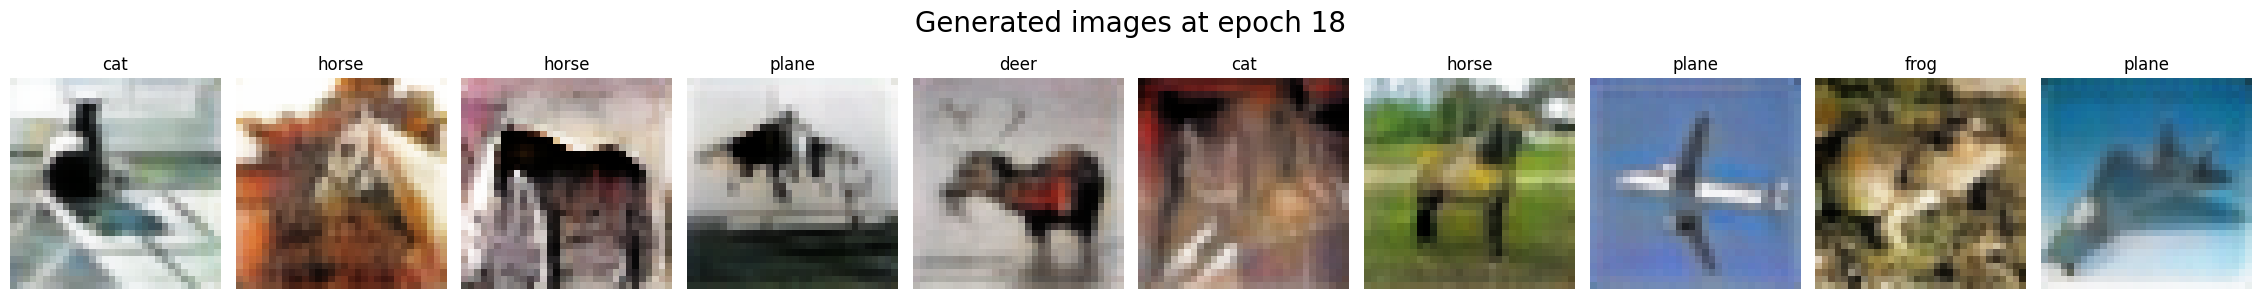

Adjusting learning rate of group 0 to 3.4757e-05.


Epoch 19/20: : 100%|██████████| 625/625 [01:26<00:00,  7.21it/s, generator_loss=7.75, discriminator_loss=1.34, D(x)=0.381, D(G(z1))=0.305, D(G(z2))=0.406]


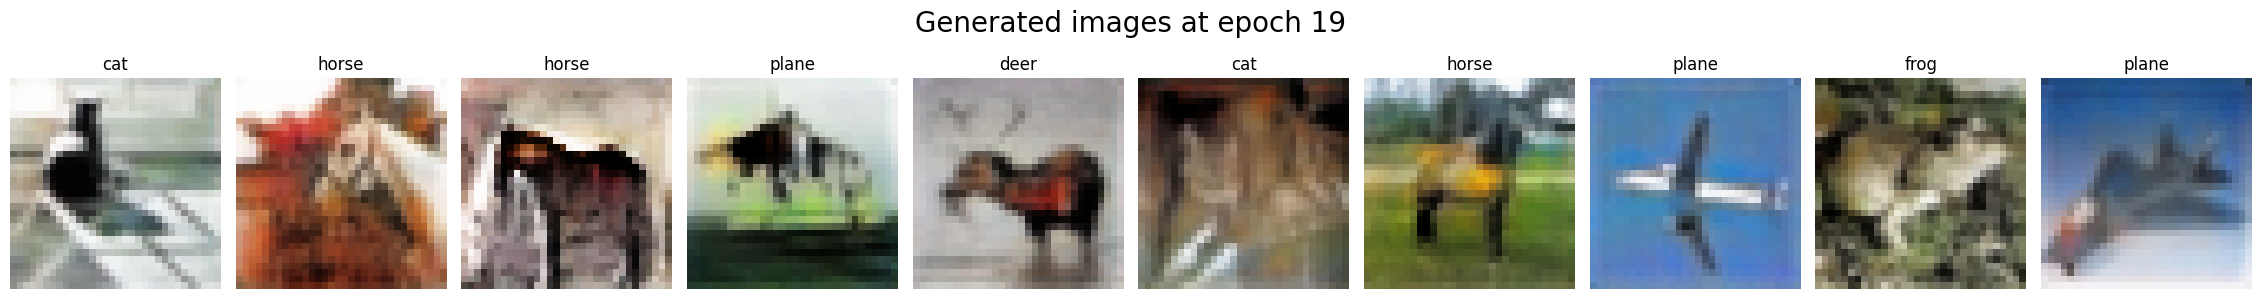

Adjusting learning rate of group 0 to 3.4062e-05.


Epoch 20/20: : 100%|██████████| 625/625 [01:26<00:00,  7.20it/s, generator_loss=7.58, discriminator_loss=1.04, D(x)=0.637, D(G(z1))=0.441, D(G(z2))=0.464]


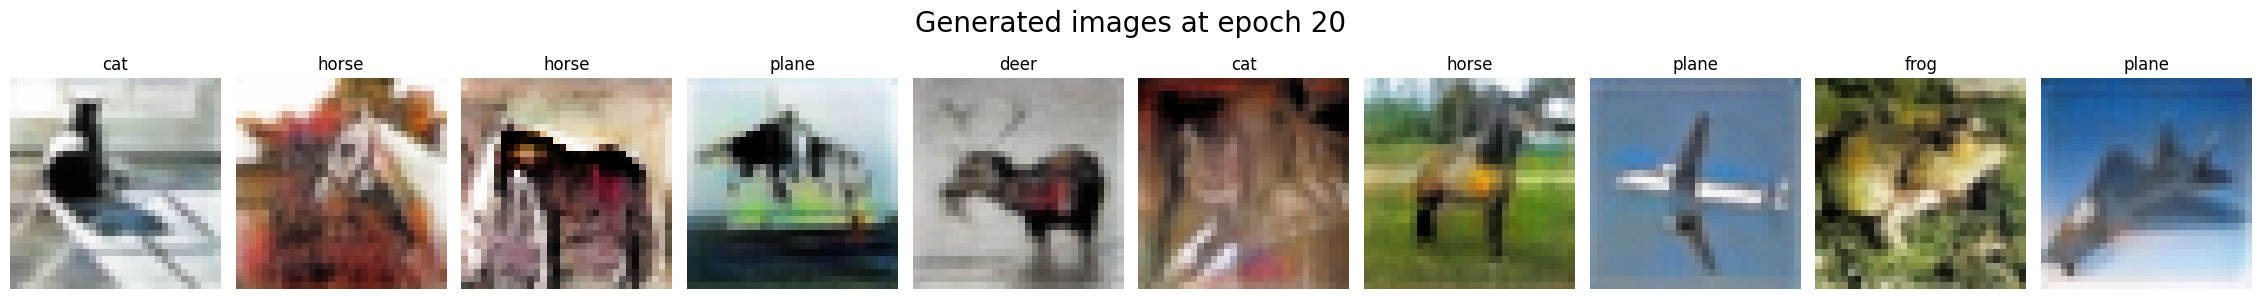

Adjusting learning rate of group 0 to 3.3380e-05.


In [ ]:
generator_losses_tr, discriminator_losses_tr, generator_losses_val, discriminator_losses_val = train_GAN(20, 5e-5, 80)

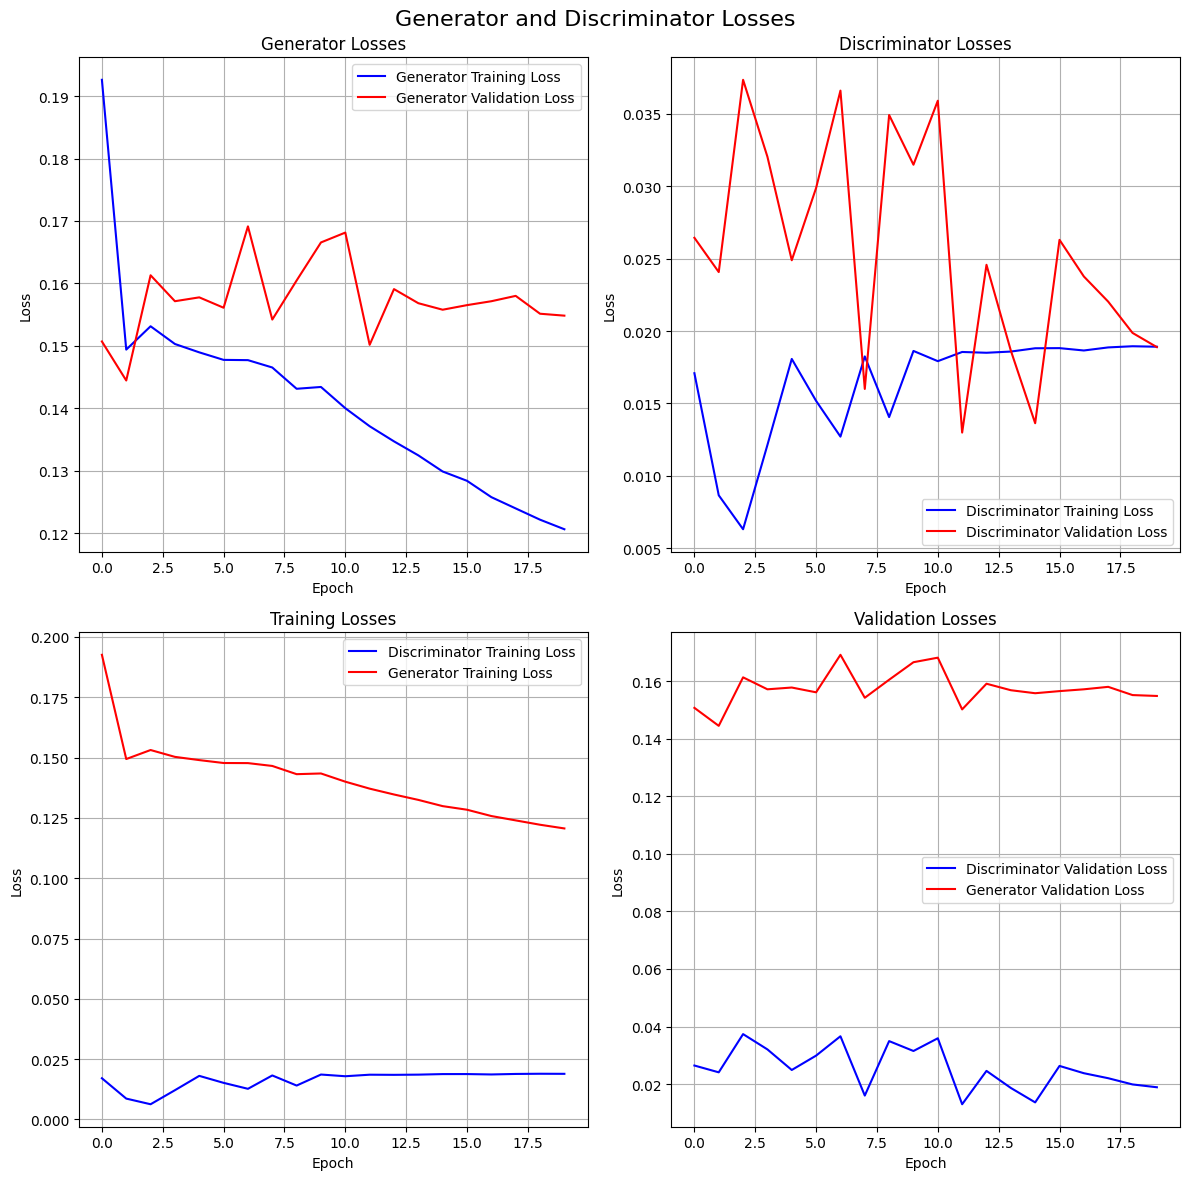

In [ ]:
plot_losses(generator_losses_tr, discriminator_losses_tr, generator_losses_val, discriminator_losses_val)

Batch 1


<ipython-input-64-ed980bec2877>:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


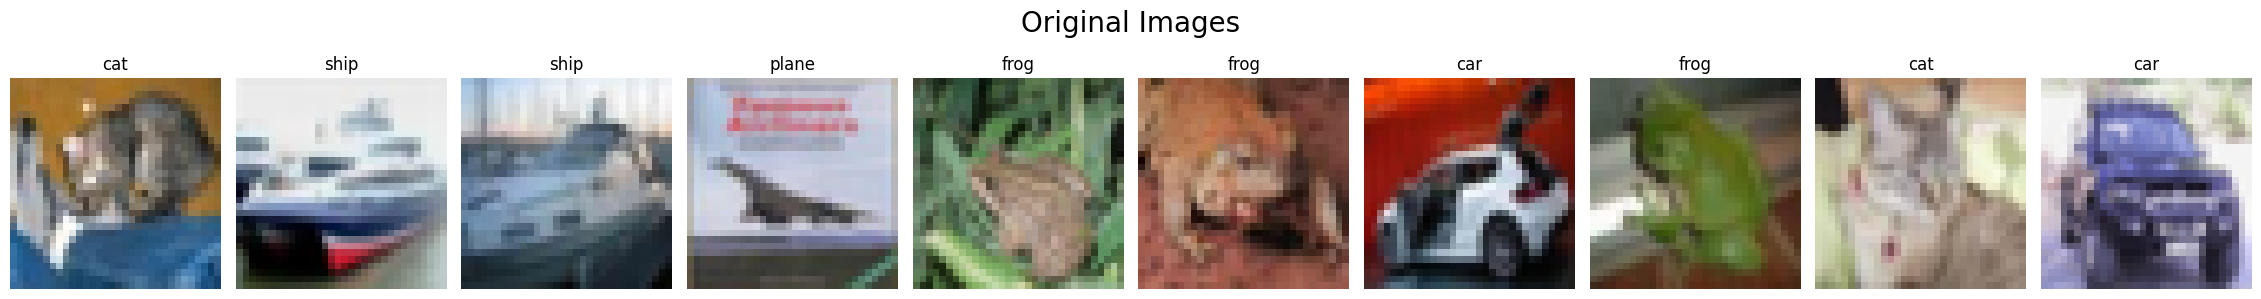

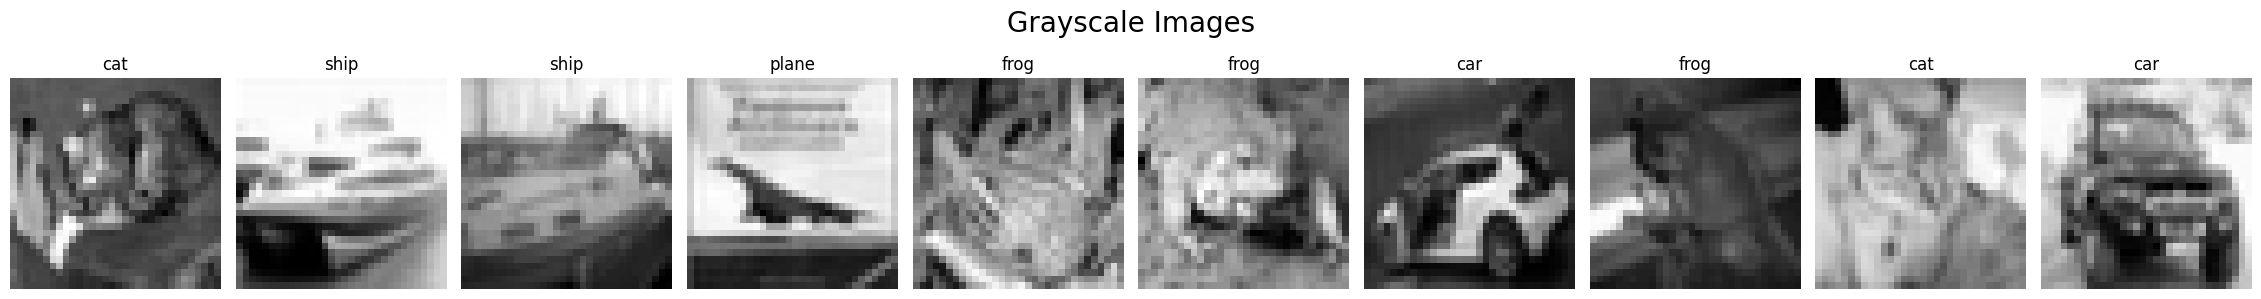

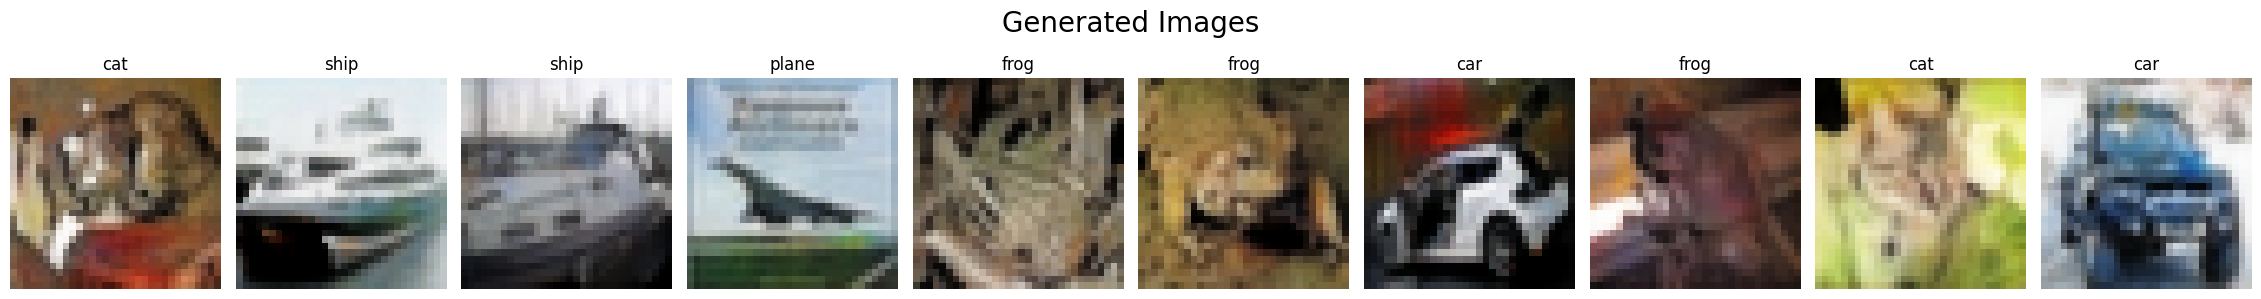

Batch 2


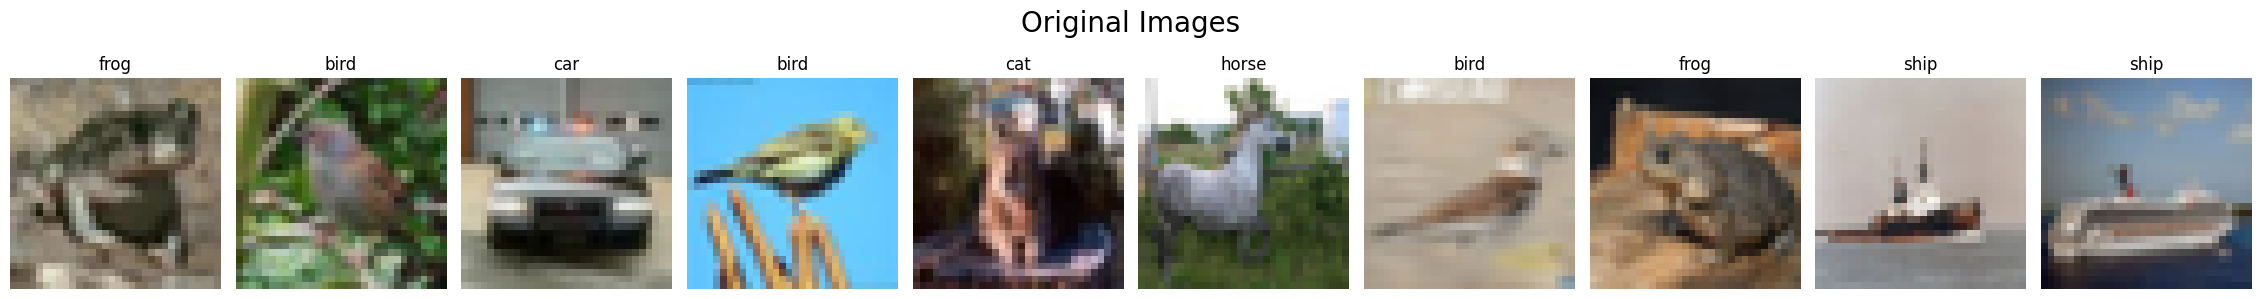

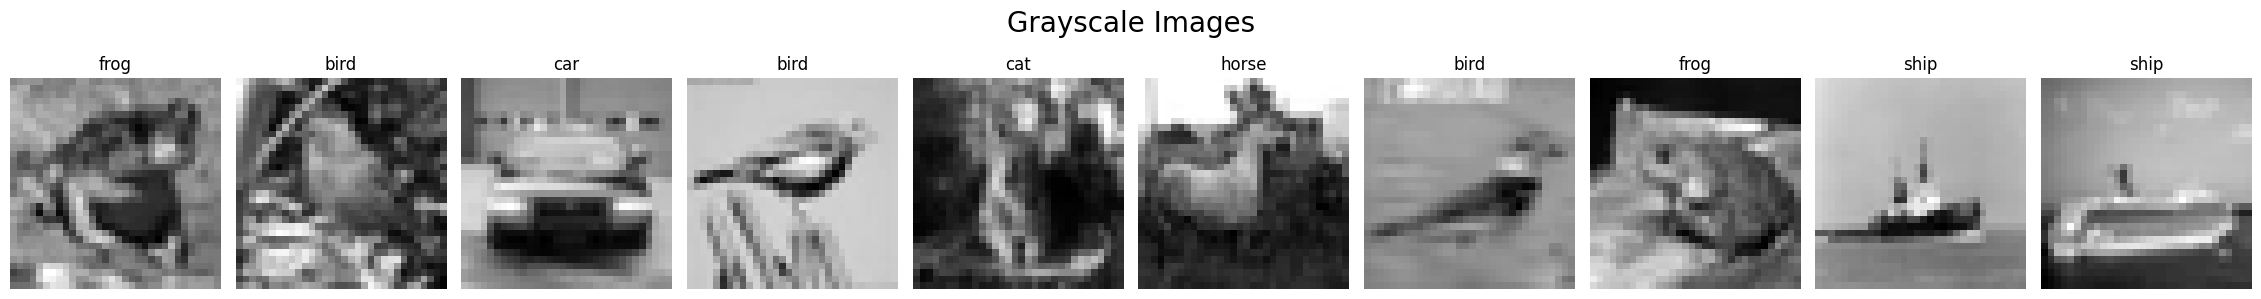

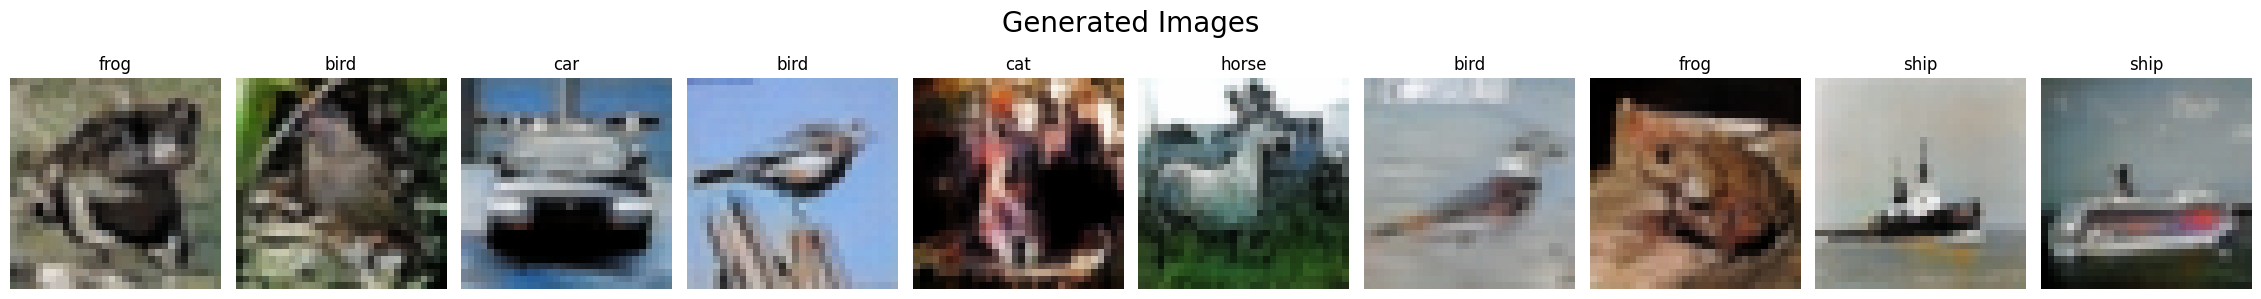

Batch 3


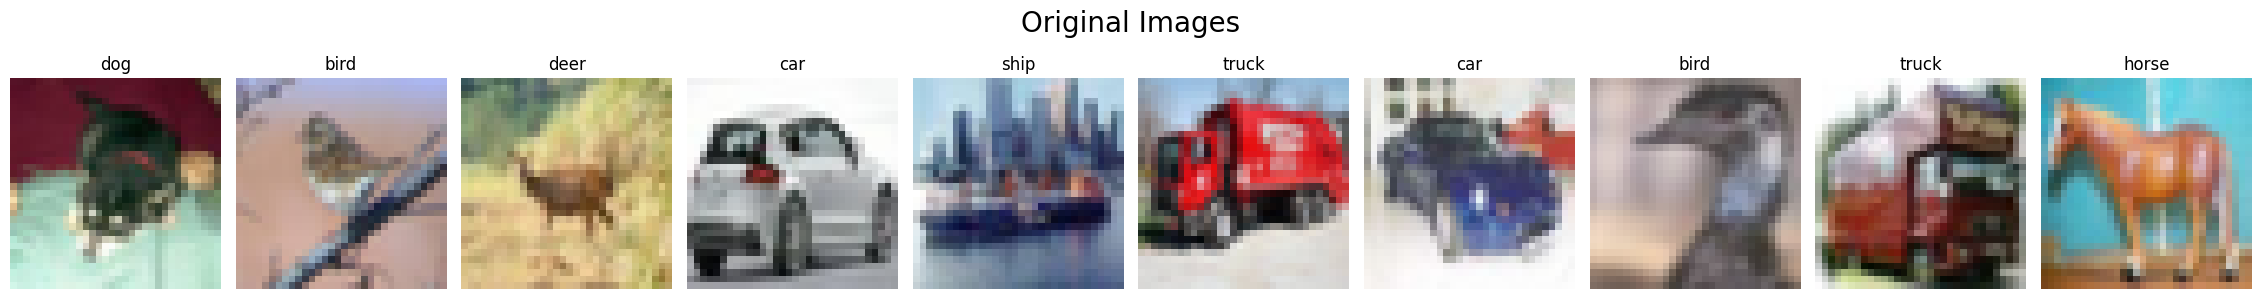

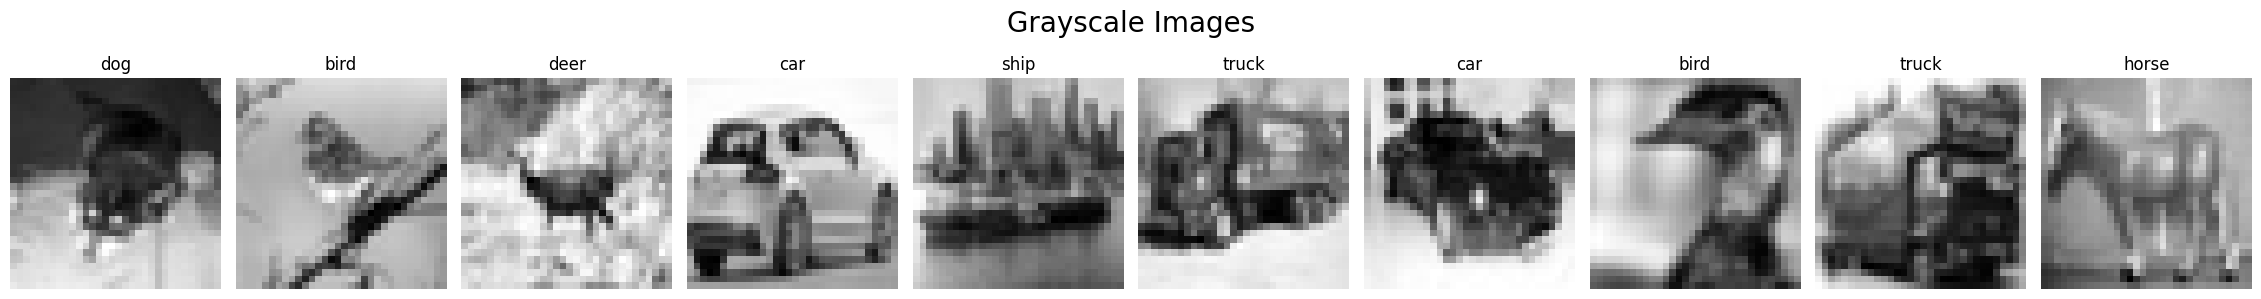

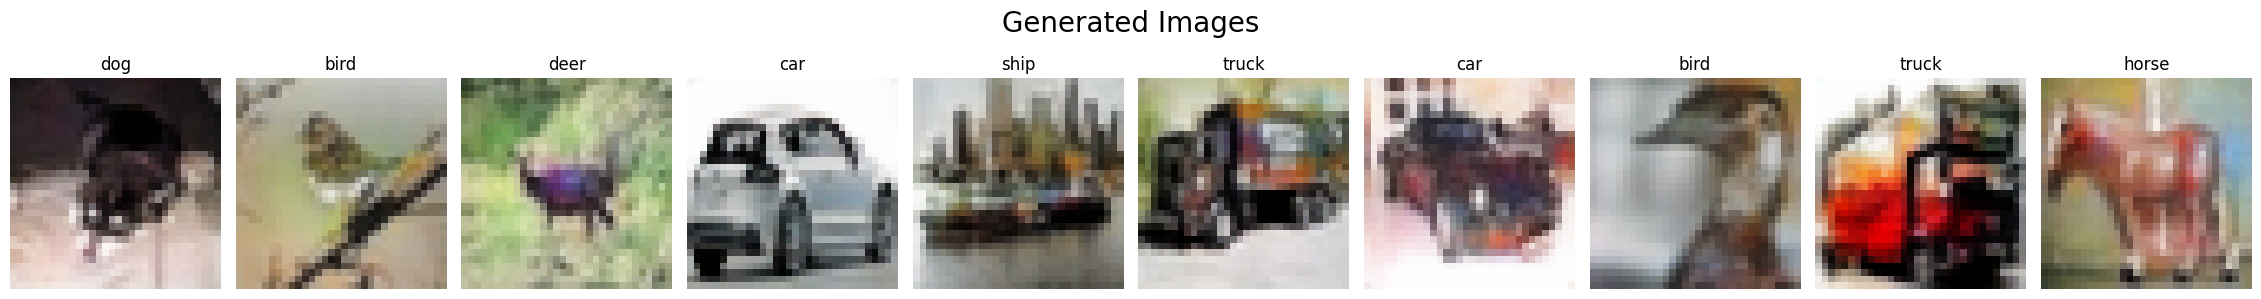

Batch 4


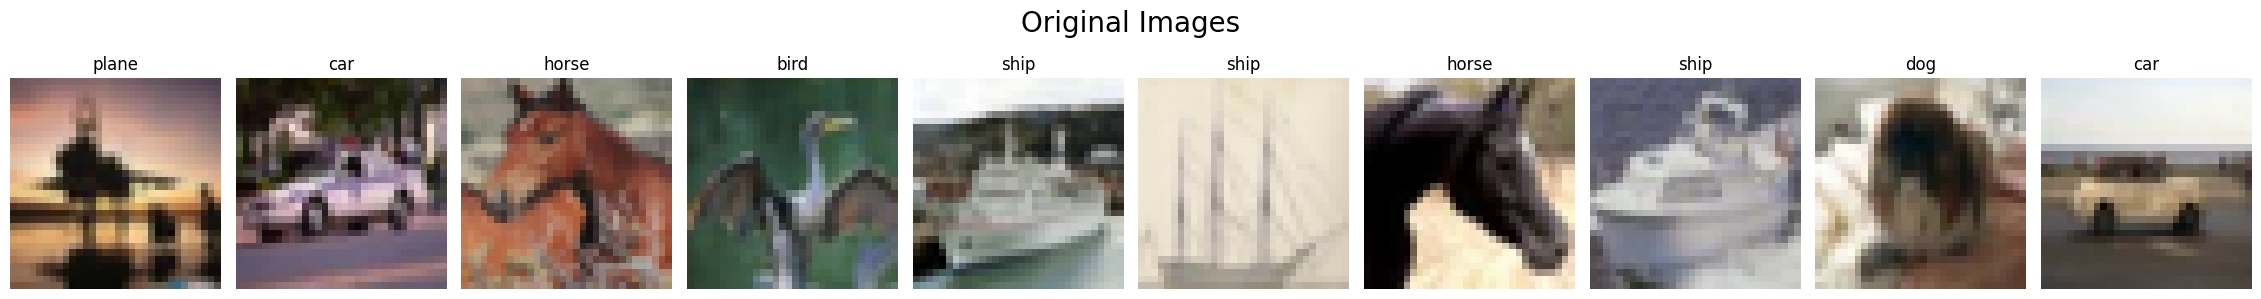

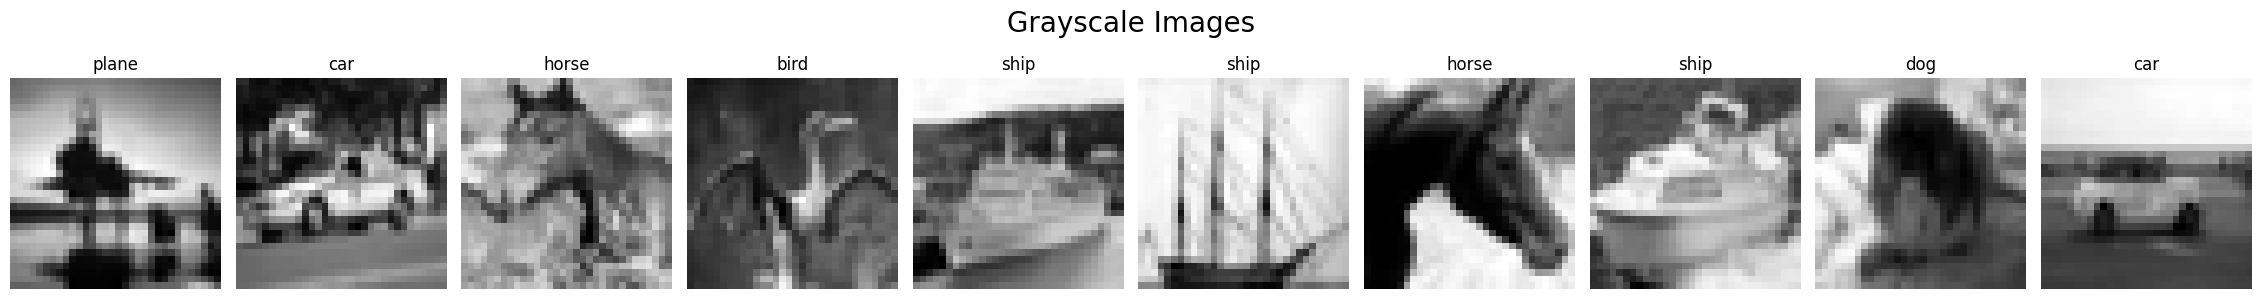

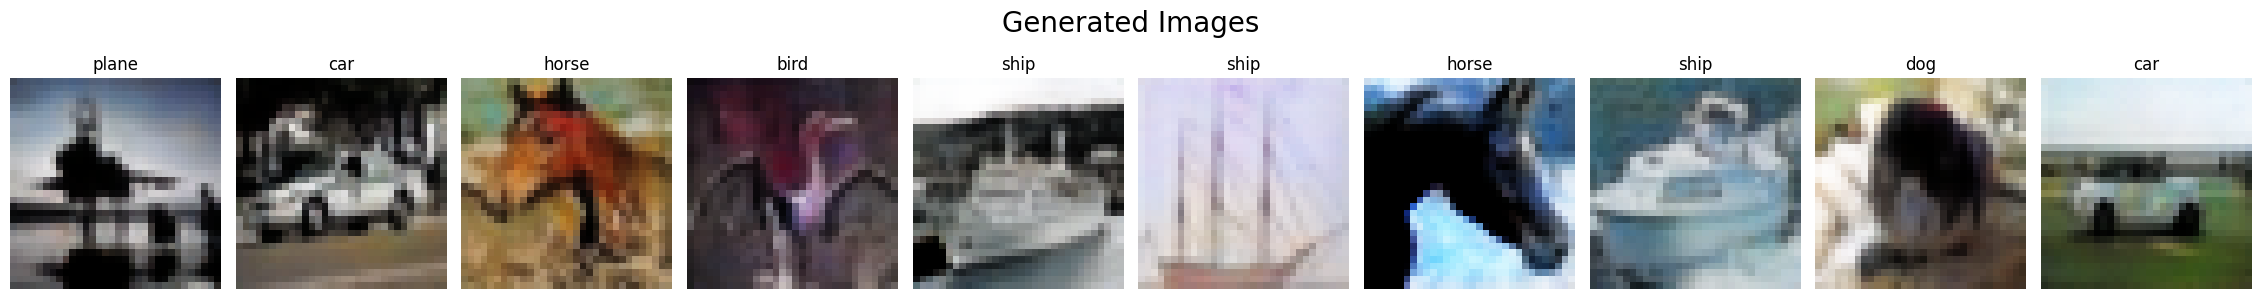

Batch 5


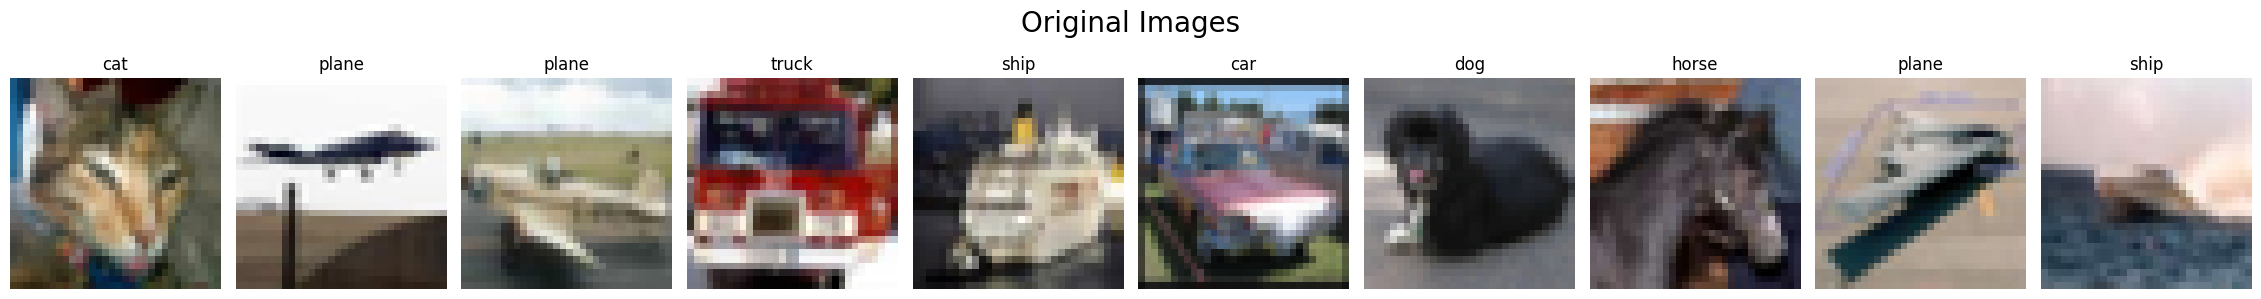

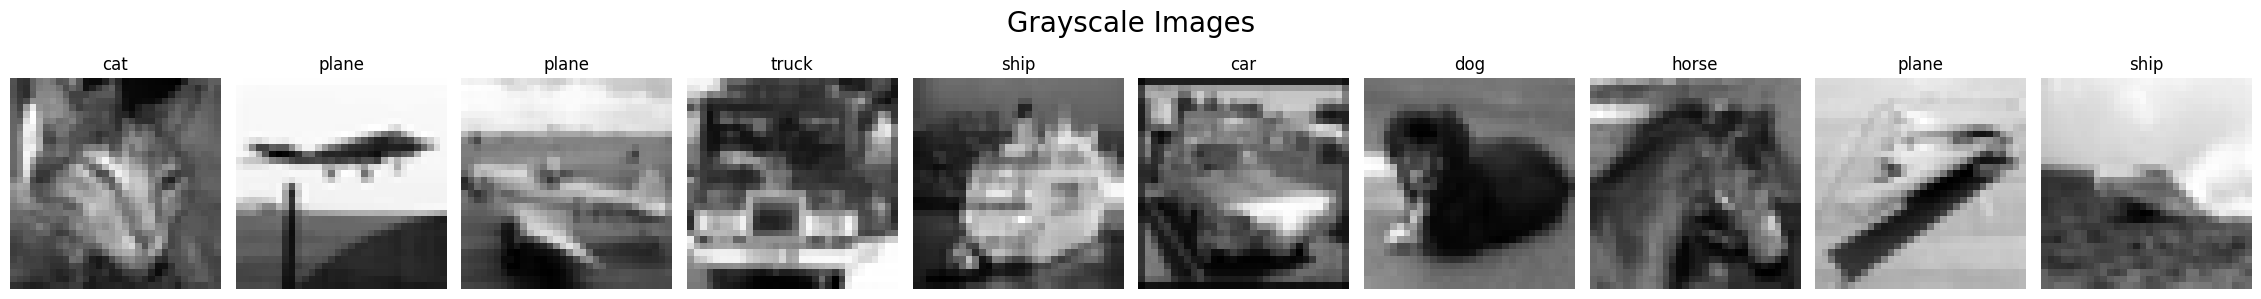

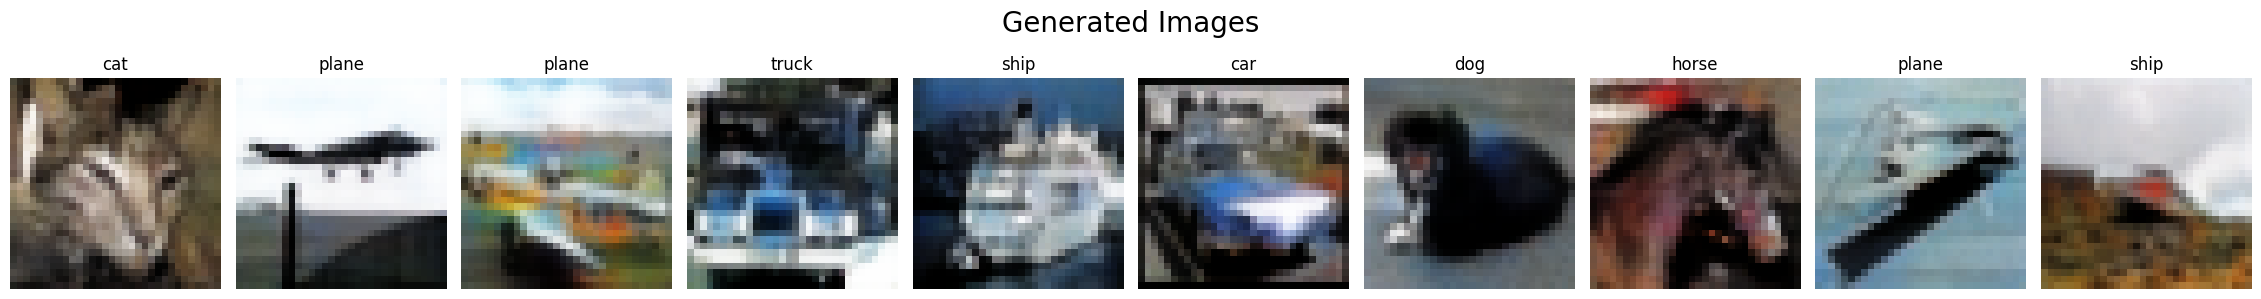

Batch 6


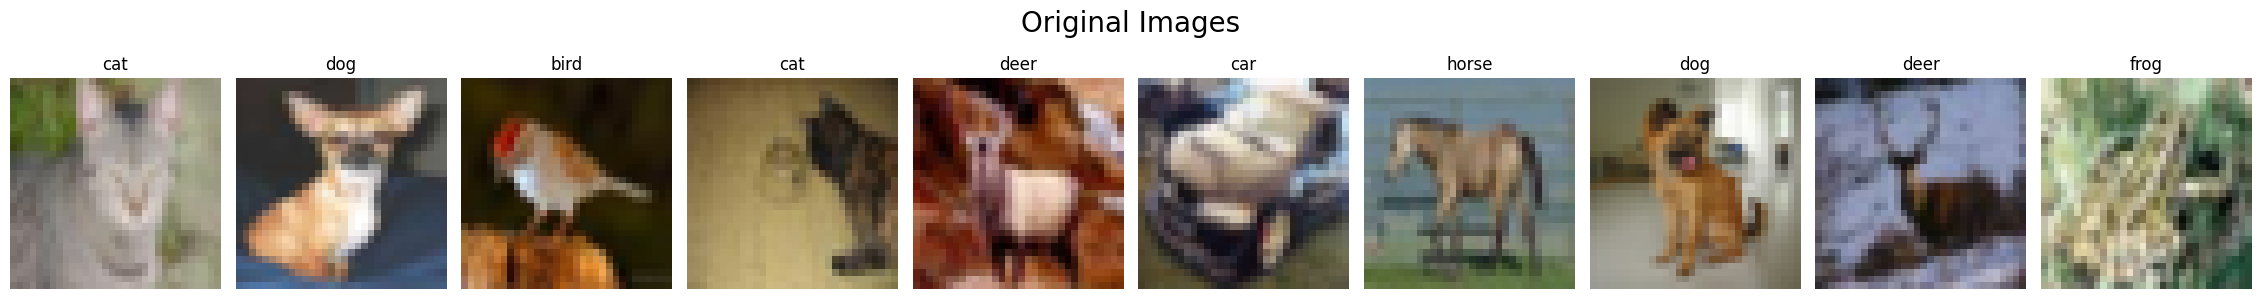

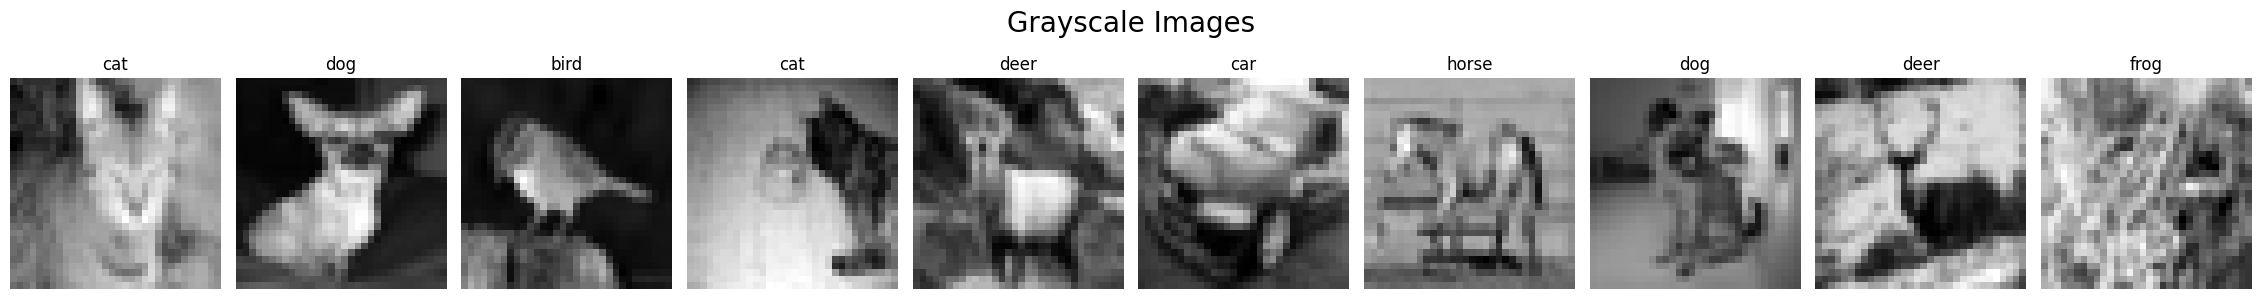

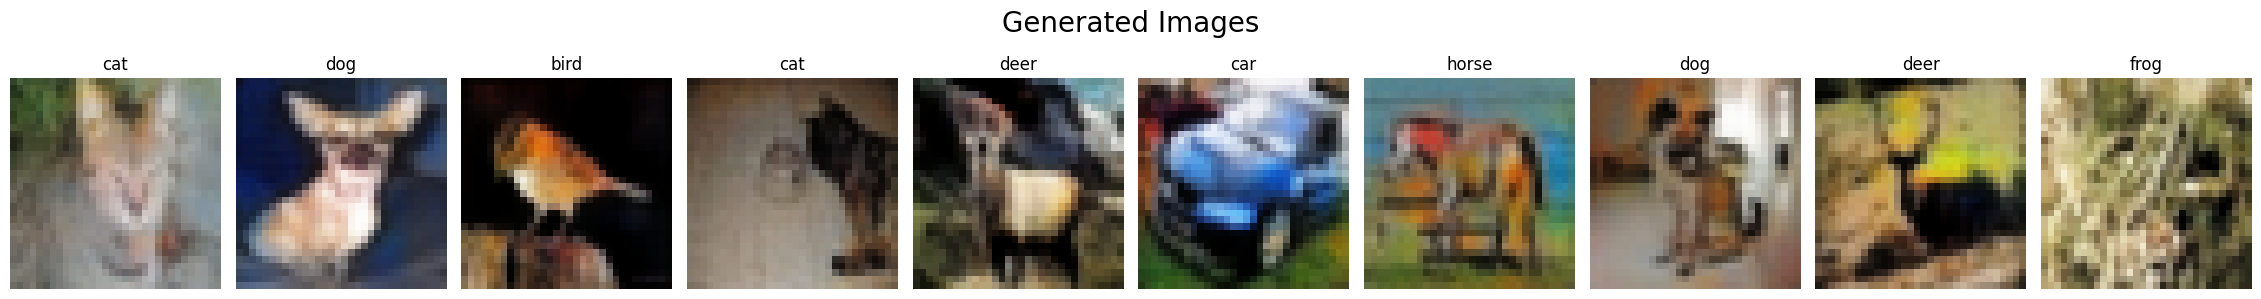

Batch 7


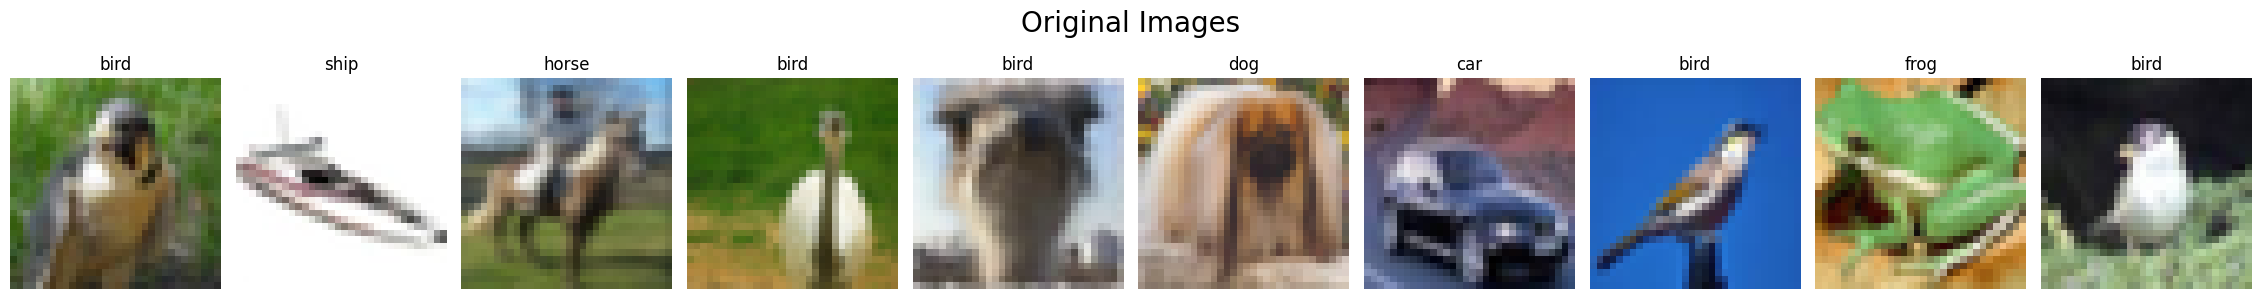

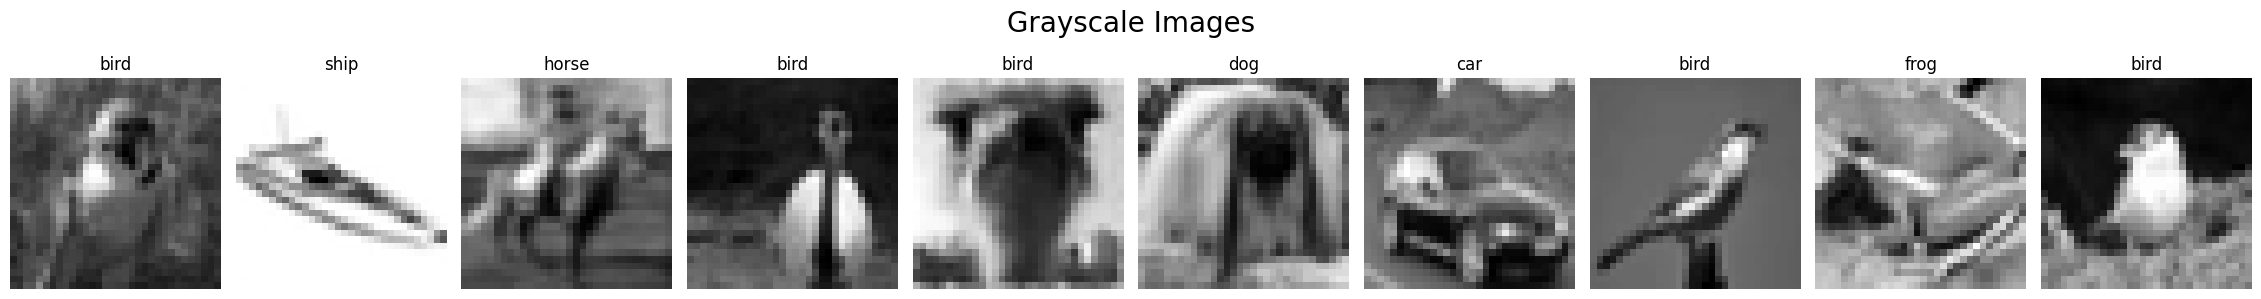

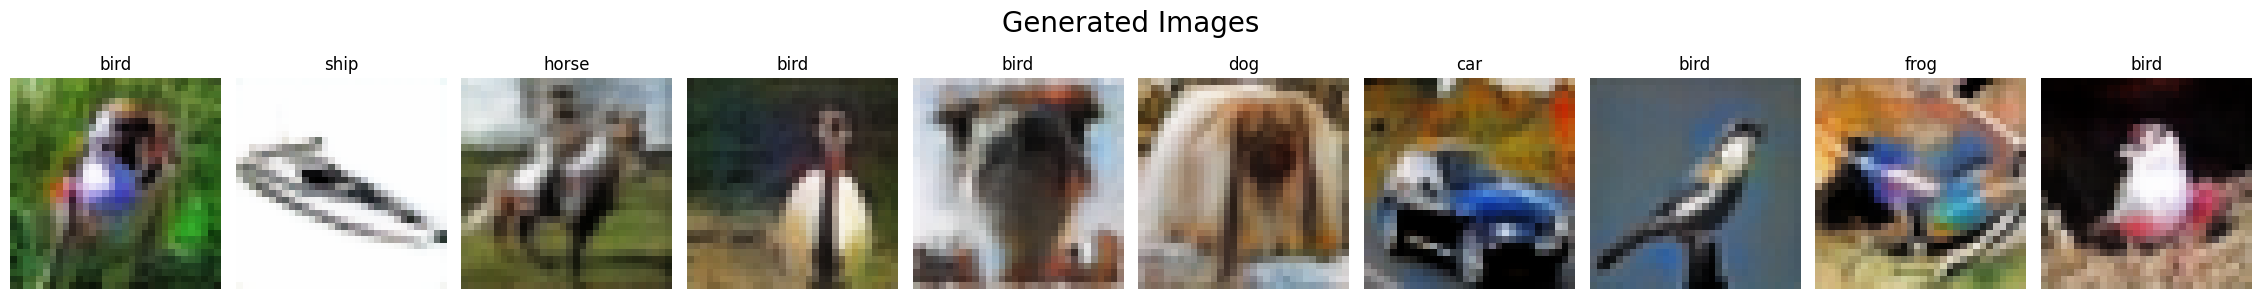

Batch 8


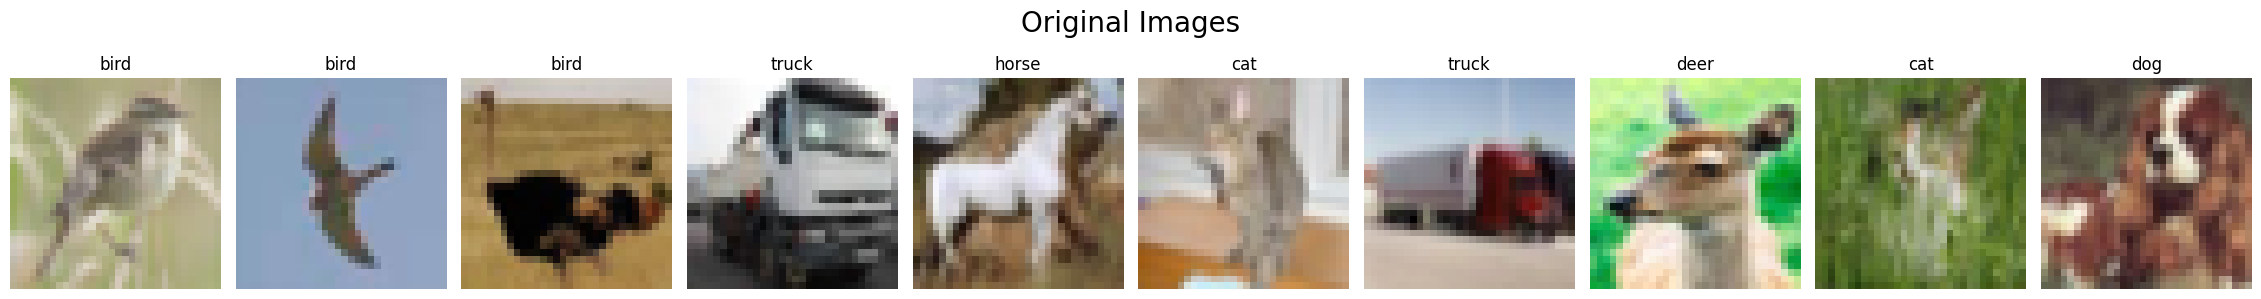

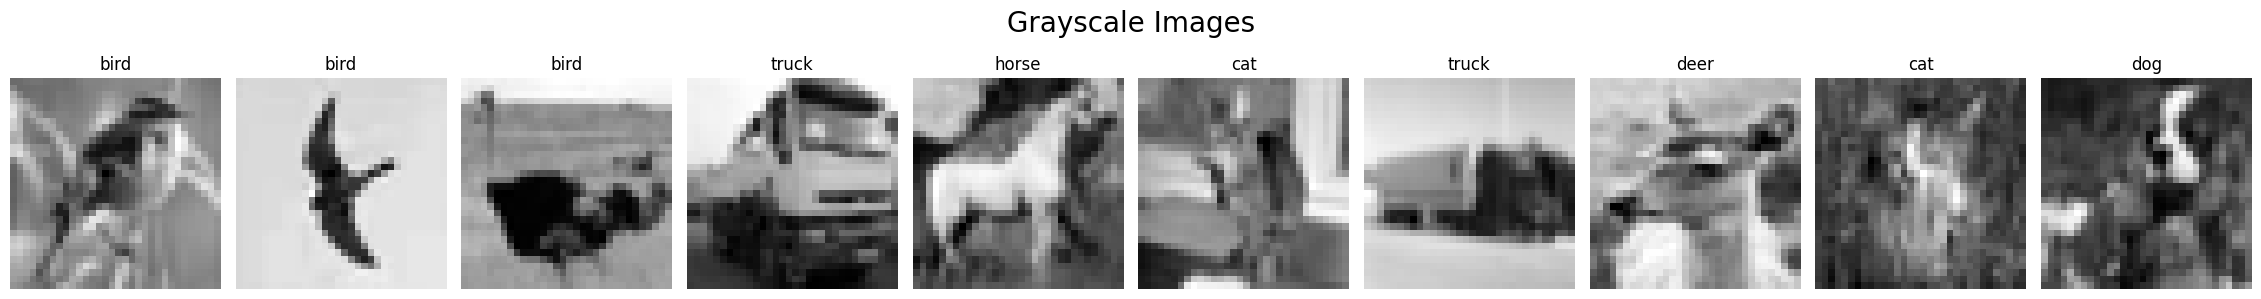

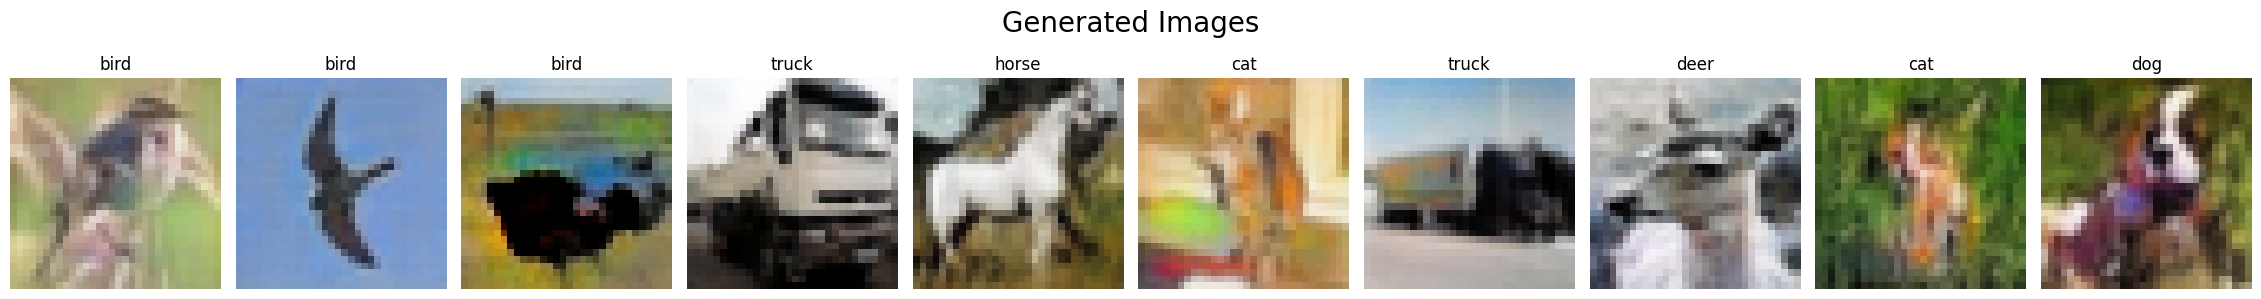

Batch 9


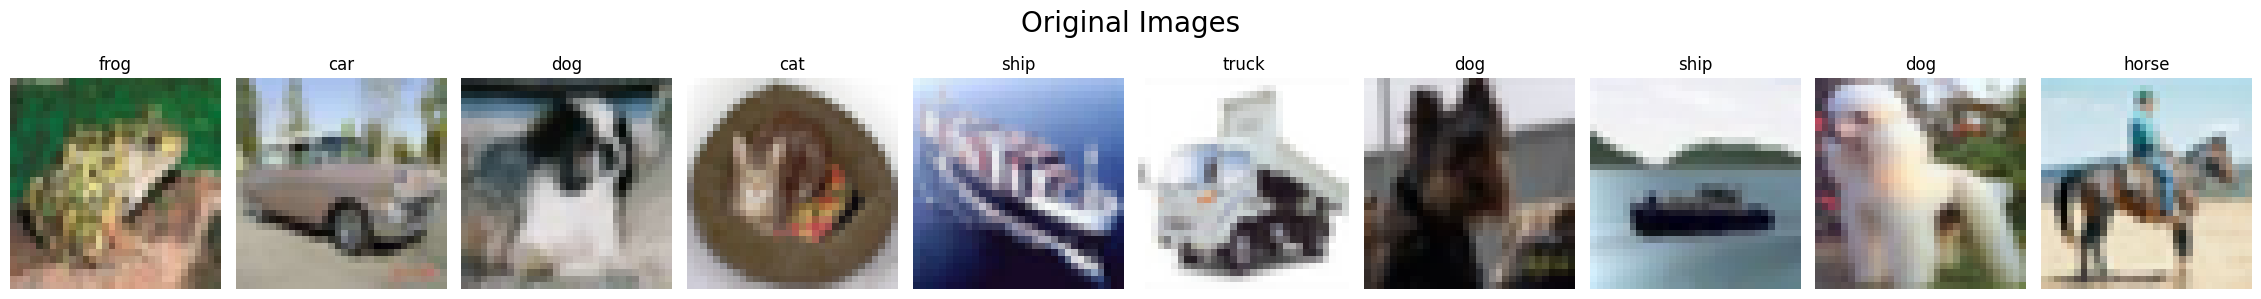

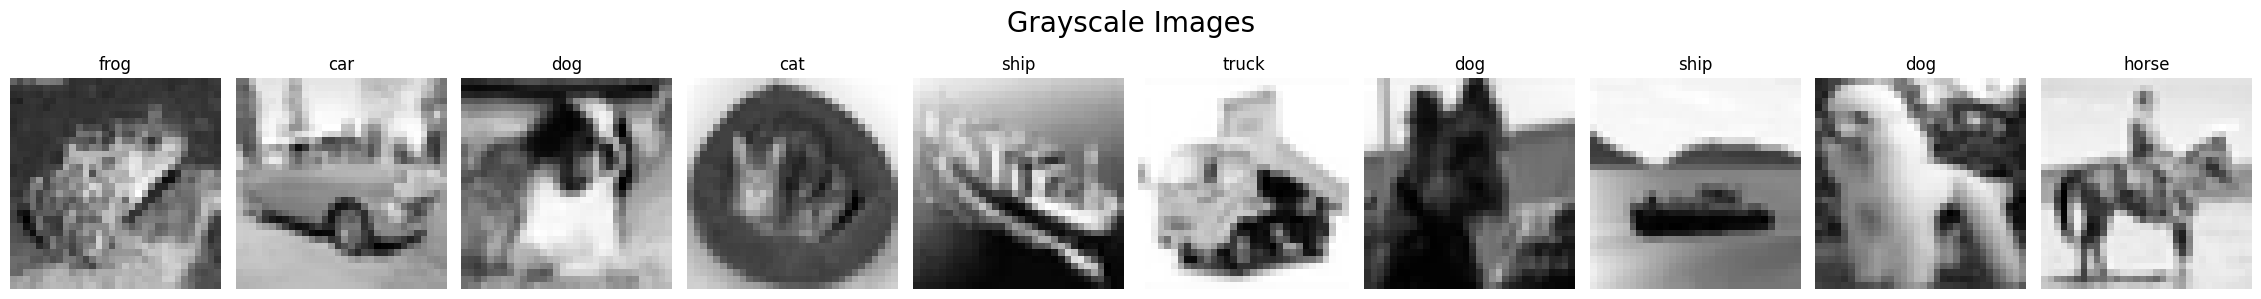

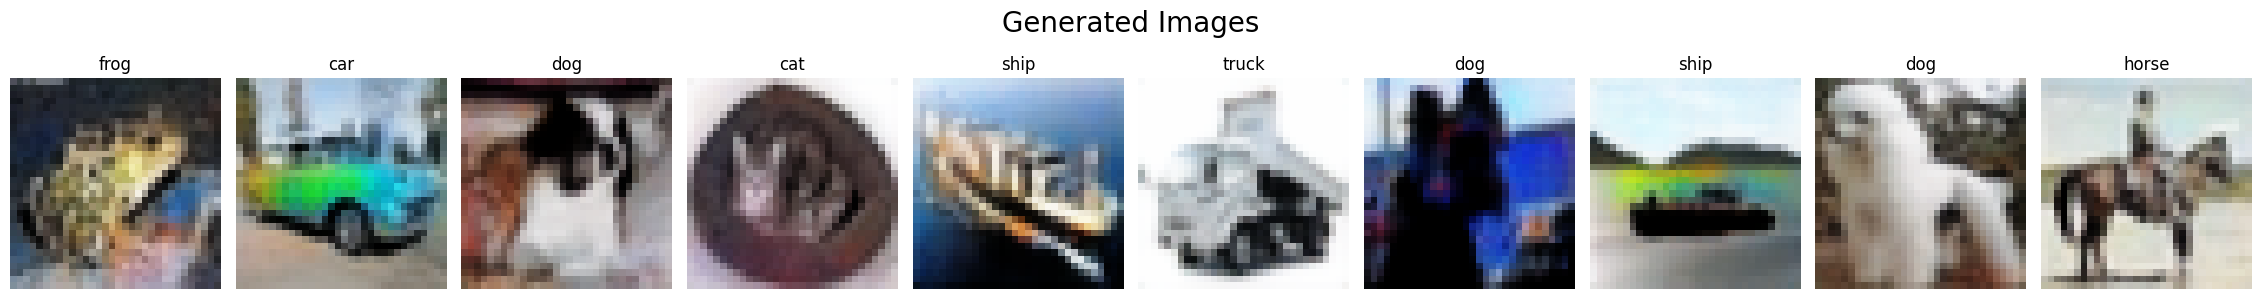

Batch 10


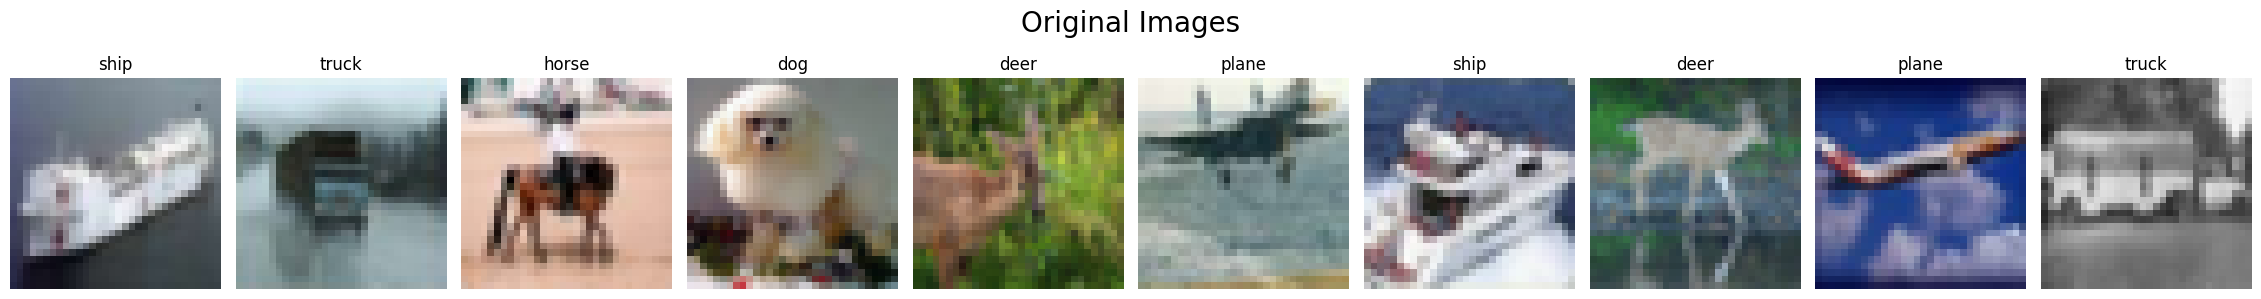

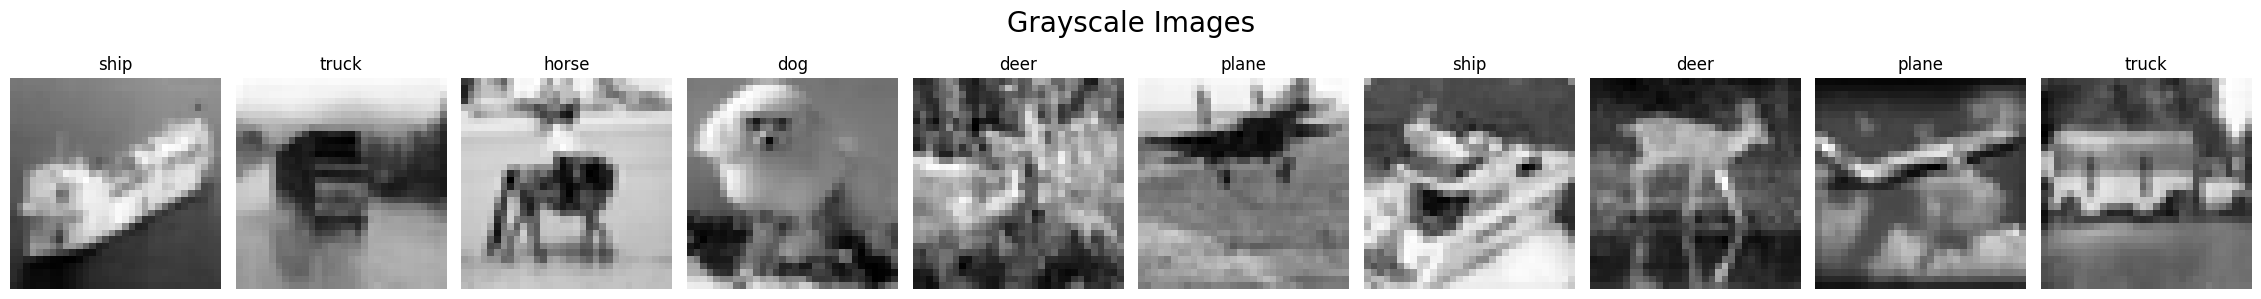

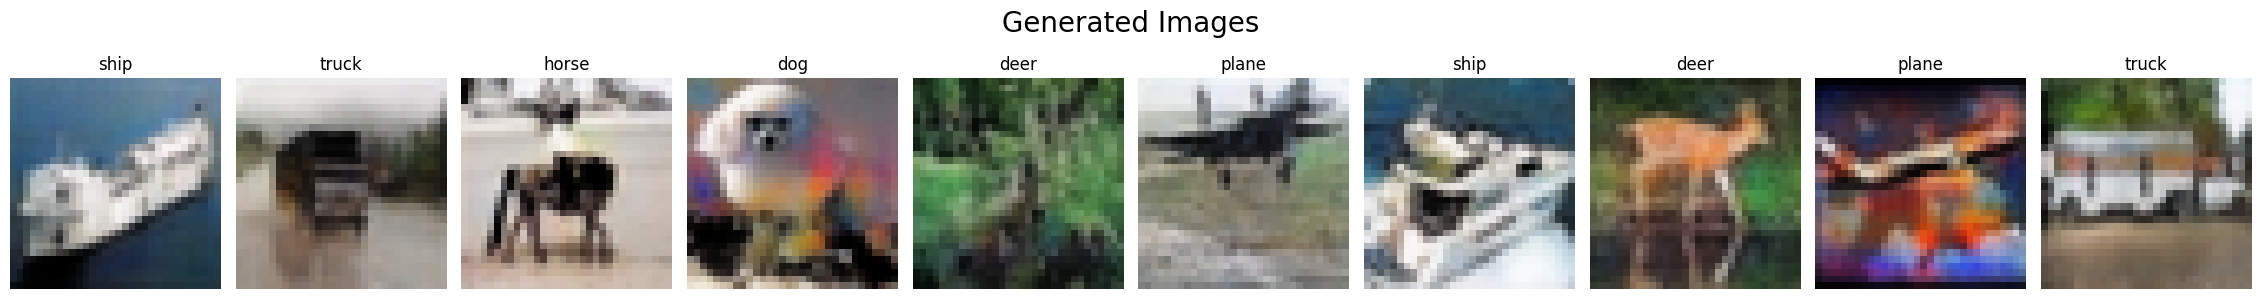

Batch 11


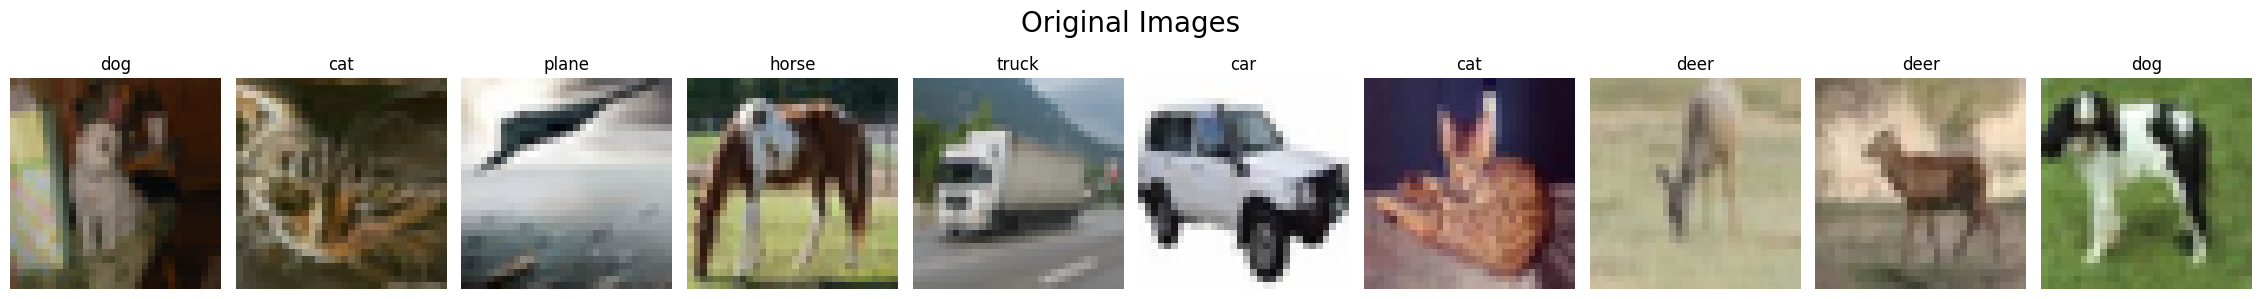

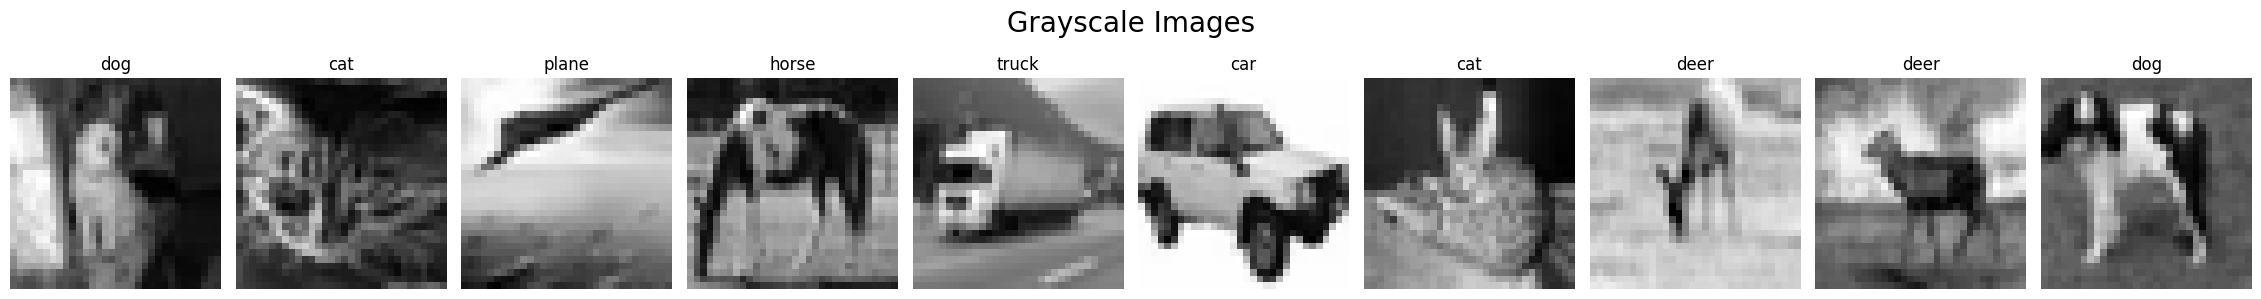

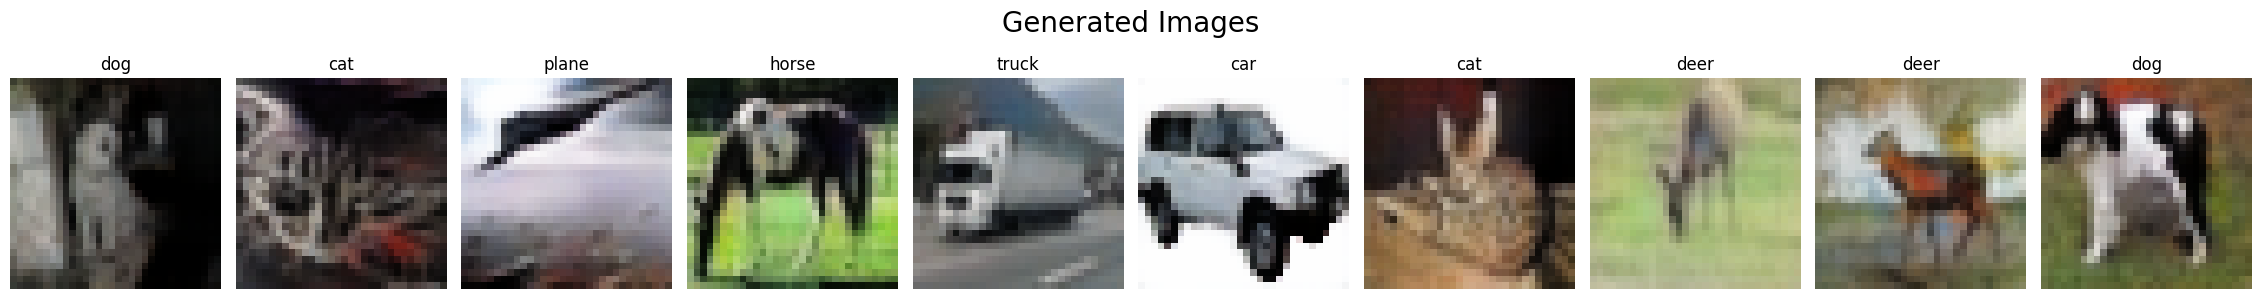

Generator test loss: 0.183274809551239
Discriminator test loss: 0.015738085389137266


In [ ]:
test_GAN(generator, discriminator, 80)

Even if the loss for augmented data increased, the generated images on the test set are looking much better than before. We can now clearly observe the overall color palette (or an approximation of this) from the original images. Nevertheless, there is still a lot of room for improvement as GANs are really tricky to train. We may need more epochs to let the generator converge.